# libraries

In [2]:
library(tidyverse)
library(dplyr)
library(parallel)
library(tibble)
library(data.table)
library(tidyr)
library(ggplot2)
library(beeswarm)
library(vioplot)
library(Hmisc)
library(FSA)
library(ggpubr)
library(stringr)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# reading txt files and creating a merged taxa file (sample IDs as columns , rows specifying species and genus)

In [7]:

# Set the directory to my text files : "/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/meta_txt"
dir_path <- setwd("/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/meta_txt")

# Get a list of all text files in the meta_txt directory , check how many txt files i have , 
file_list <- list.files(dir_path, pattern = "\\.txt$", full.names = TRUE)

length(file_list)


[1] 826

In [8]:
metafile_list <- list.files(dir_path, pattern = "metaphlan\\.txt$", full.names = TRUE)
length(metafile_list)

[1] 814

In [9]:
directory_path <- "/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/meta_txt"

In [10]:
 
process_txt_files_parallel <- function(directory_path) {
  # Step 1: List all .txt files in the directory
  files <- list.files(directory_path, pattern = "metaphlan\\.txt$", full.names = TRUE)
  
  # an empty list to store data frames
  dfs <- list()
  
  # Create a cluster with the number of available cores 
  cl <- makeCluster(detectCores())
  
  # Process each file in parallel (step 2 to 5) , TO SPEED UP
  dfs <- parLapply(cl, files, function(file) {
    # Step 2: Extract file name
    file_name <- basename(file)
    
    # Step 3: Read each text file as a data frame
    df <- read.table(file, header = FALSE, sep= "\t")
    
    # Step 4: Delete rows containing "|t__" in the first column
    df <- df[!grepl("\\|t__", df[[1]]), ]
    
    # Step 5: Select the first and third columns
    df_selected <- df[, c("V1","V3")]
    
    # Step 6: Rename columns
    colnames(df_selected) <- c("clade_name", gsub("\\.txt$", "", file_name))
    
    return(df_selected)
  })
  
  # Close the cluster
  stopCluster(cl)
  
  # Step 7: Merge all data frames based on the first column
  merged_df <- Reduce(function(x, y) merge(x, y, by = "clade_name", all = TRUE), dfs)
  
  return(merged_df)
}

directory_path <- "/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/meta_txt"
merged_data <- process_txt_files_parallel(directory_path)


In [2]:
#dim(merged_data)
#head(merged_data)
#tail(merged_data,10)

In [13]:
df_combined <- merged_data %>% replace(is.na(.), 0)

In [3]:
#dim(df_combined)
#head(df_combined)
#tail(df_combined)

In [15]:
#copy this dataframe and modify column names and remove ".metaphlan" from column names 
x <- df_combined[,-1]
rownames(x) <- df_combined[,1]

In [17]:
col <- colnames(x)
y <- str_remove(col, ".metaphlan")

In [18]:
colnames(x) <- y
#head(x)

df_mod <- tibble::rownames_to_column(x, "clade_name")
#head(df_mod)
#dim(df_mod)

clade_name                                                                                             
1 k__Archaea                                                                                             
2 k__Archaea|p__Euryarchaeota                                                                            
3 k__Archaea|p__Euryarchaeota|c__Methanobacteria                                                         
4 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales                                   
5 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae            
6 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__GGB50949
  ERR1474564 ERR1474565 ERR1474566 ERR1474567 ERR1474568 ERR1474569 ERR1474570
1 0          0          0          0          0          0          0         
2 0          0          0          0          0          0          0         
3 0          0          0          0          0          0          0         
4 0          0          0          0          0          0          0         
5 0          0          0          0          0          0          0         
6 0          0          0          0          0          0          0         
  ERR1474571 ERR1474572 ⋯ SRR23512345 SRR23512349 SRR23512353 SRR23512359
1 0          0          ⋯ 0           0           0           0          
2 0          0          ⋯ 0           0           0           0          
3 0          0          ⋯ 0           0           0           0          
4 0          0          ⋯ 0           0           0           0          
5 0          0          ⋯ 0           0           0           0          
6 0          0          ⋯ 0           0           0           0          
  SRR23512363 SRR346673 SRR346681 SRR511518 SRR514209 SRR514322
1 0           0         0         0         0         0        
2 0           0         0         0         0         0        
3 0           0         0         0         0         0        
4 0           0         0         0         0         0        
5 0           0         0         0         0         0        
6 0           0         0         0         0         0

## selecting species , genera , family for the whole merged dataframe 

In [31]:
#selecting rows containing species , start with "|s__"
df_1 <- df_mod[grepl("\\|s__", df_mod[[1]]), ]
head(df_1)
dim(df_1)
#df_1 <- df_1[,-2]

clade_name                                                                                                                                    
7  k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__GGB50949|s__GGB50949_SGB71159                  
9  k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_oralis
16 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_sp_oral_taxon_183     
18 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_bouchesdurhonensis        
19 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_culturomici               
20 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_dentalis                  
   ERR1474564 ERR1474565 ERR1474566 ERR1474567 ERR1474568 ERR1474569 ERR1474570
7  0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
9  0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
16 0.00000    0.00000    0          0.00000    0.01180    0.00000    0.00436   
18 0.00000    0.00489    0          0.12248    0.00000    0.19646    0.02339   
19 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
20 0.00372    0.00000    0          0.00187    0.02342    0.00000    0.01439   
   ERR1474571 ERR1474572 ⋯ SRR23512345 SRR23512349 SRR23512353 SRR23512359
7  0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
9  0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
16 0.00510    0          ⋯ 0.10502     0.00000     0.02351     0.00000    
18 0.01455    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
19 0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
20 0.00000    0          ⋯ 0.02564     0.11922     0.00125     0.08957    
   SRR23512363 SRR346673 SRR346681 SRR511518 SRR514209 SRR514322
7  0.00000     0.000     0.00000   0.00000   0         0        
9  0.00000     0.000     0.00000   0.00000   0         0        
16 0.30576     0.000     0.00000   1.80098   0         0        
18 0.39268     0.027     0.02314   3.19705   0         0        
19 0.00000     0.000     0.00000   0.00000   0         0        
20 0.09906     0.000     0.00000   0.00000   0         0

[1] 762 815

In [33]:
# check relative abundance
column_sums <- colSums(df_1[,2:ncol(df_1)]) 
summary(column_sums)
summary(100-column_sums)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00  100.00  100.00   99.88  100.00  100.00 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 -0.00015  -0.00002   0.00000   0.12285   0.00002 100.00000 

In [35]:
#save relative abundance dataframe(species-level)
write.table(df_1, file = "combination_allsamples_meta.txt", sep = "\t", row.names = FALSE)

clade_name                                                                                                                                    
7  k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__GGB50949|s__GGB50949_SGB71159                  
9  k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_oralis
16 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_sp_oral_taxon_183     
18 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_bouchesdurhonensis        
19 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_culturomici               
20 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_dentalis                  
   ERR1474564 ERR1474565 ERR1474566 ERR1474567 ERR1474568 ERR1474569 ERR1474570
7  0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
9  0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
16 0.00000    0.00000    0          0.00000    0.01180    0.00000    0.00436   
18 0.00000    0.00489    0          0.12248    0.00000    0.19646    0.02339   
19 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
20 0.00372    0.00000    0          0.00187    0.02342    0.00000    0.01439   
   ERR1474571 ERR1474572 ⋯ SRR23512345 SRR23512349 SRR23512353 SRR23512359
7  0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
9  0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
16 0.00510    0          ⋯ 0.10502     0.00000     0.02351     0.00000    
18 0.01455    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
19 0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
20 0.00000    0          ⋯ 0.02564     0.11922     0.00125     0.08957    
   SRR23512363 SRR346673 SRR346681 SRR511518 SRR514209 SRR514322
7  0.00000     0.000     0.00000   0.00000   0         0        
9  0.00000     0.000     0.00000   0.00000   0         0        
16 0.30576     0.000     0.00000   1.80098   0         0        
18 0.39268     0.027     0.02314   3.19705   0         0        
19 0.00000     0.000     0.00000   0.00000   0         0        
20 0.09906     0.000     0.00000   0.00000   0         0

### group them by their project_ID 
#### i'll create r_notbook for each project biosamples , for the sake of time and understanding, to process each project seprately also. 
##### just planned to have a function for selecting them and further process for each bioproject would be done on corresponding r_notebook

In [39]:
getwd()

[1] "/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/meta_txt"

In [40]:
# Define a function to select columns based on column name patterns and create a new dataframe
create_group_dataframe <- function(df, pattern, group_name) {
  # Find indices of columns that match the pattern
  col_indices <- which(startsWith(names(df), pattern))
  
  # Select columns based on indices and include the "clade_name" column
  selected_cols <- c("clade_name", names(df)[col_indices])
  
  # Create a new dataframe with selected columns
  new_df <- df[selected_cols]
  
  # Rename the dataframe with the group name
  names(new_df)[1] <- "clade_name"
  
  # Save the new dataframe as a text file
  write.table(new_df, file = paste0(group_name, ".txt"), sep = "\t", row.names = FALSE)
  
  # Read the saved dataframe back into R
  read_df <- read.table(paste0(group_name, ".txt"), header = TRUE, sep = "\t")
  
  # Return the new dataframe
  return(read_df)
}



In [42]:
 
# Define column name patterns and corresponding group names
patterns <- c("ERR276", "ERR1474", "SRR14122", "SRR19117" , "SRR2176", "SRR2351")#,"SRR27" )
group_names <- c("PRJEB28422", "PRJEB14383", "PRJNA717815", "PRJNA832909", "PRJNA883997" , "PRJNA934596")#, "PRJNA1057503")

# Initialize an empty list to store the selected dataframes
selected_dfs <- list()

# Loop through each pattern and create the corresponding dataframe
for (i in seq_along(patterns)) {
  selected_dfs[[group_names[i]]] <- create_group_dataframe(df_1, patterns[i], group_names[i])
}


In [ ]:
#one of the bioprojects samples id did not have any pattern : 
new_df <- df_1[, c("clade_name", "SRR062371", "SRR062372", "SRR062389", "SRR062396", "SRR062402" , "SRR062413","SRR062415","SRR062435","SRR062441","SRR062462","SRR1804765" , "SRR346673", "SRR346681","SRR511518","SRR514209","SRR514322")]
#dim(new_df)
#head(new_df)
write.table(new_df, file = "PRJNA48479.txt", sep = "\t", row.names = FALSE)

## further process on the whole merged data, called df_1 
### (combination_allsamples_meta.txt files that i merged)

In [ ]:
setwd("/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/meta_txt")

In [51]:
df_1 <- read.table( file = "combination_allsamples_meta.txt", header = TRUE, sep = "\t")
head(df_1)
dim(df_1)

clade_name                                                                                                                                    
1 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__GGB50949|s__GGB50949_SGB71159                  
2 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_oralis
3 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_sp_oral_taxon_183     
4 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_bouchesdurhonensis        
5 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_culturomici               
6 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_dentalis                  
  ERR1474564 ERR1474565 ERR1474566 ERR1474567 ERR1474568 ERR1474569 ERR1474570
1 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
2 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
3 0.00000    0.00000    0          0.00000    0.01180    0.00000    0.00436   
4 0.00000    0.00489    0          0.12248    0.00000    0.19646    0.02339   
5 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
6 0.00372    0.00000    0          0.00187    0.02342    0.00000    0.01439   
  ERR1474571 ERR1474572 ⋯ SRR23512345 SRR23512349 SRR23512353 SRR23512359
1 0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
2 0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
3 0.00510    0          ⋯ 0.10502     0.00000     0.02351     0.00000    
4 0.01455    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
5 0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
6 0.00000    0          ⋯ 0.02564     0.11922     0.00125     0.08957    
  SRR23512363 SRR346673 SRR346681 SRR511518 SRR514209 SRR514322
1 0.00000     0.000     0.00000   0.00000   0         0        
2 0.00000     0.000     0.00000   0.00000   0         0        
3 0.30576     0.000     0.00000   1.80098   0         0        
4 0.39268     0.027     0.02314   3.19705   0         0        
5 0.00000     0.000     0.00000   0.00000   0         0        
6 0.09906     0.000     0.00000   0.00000   0         0

[1] 762 815

In [52]:
#removing species name from clade name:
df_1$clade <- str_replace(df_1$clade_name, "\\|s__.*", "")
head(df_1)

clade_name                                                                                                                                    
1 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__GGB50949|s__GGB50949_SGB71159                  
2 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_oralis
3 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_sp_oral_taxon_183     
4 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_bouchesdurhonensis        
5 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_culturomici               
6 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_dentalis                  
  ERR1474564 ERR1474565 ERR1474566 ERR1474567 ERR1474568 ERR1474569 ERR1474570
1 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
2 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
3 0.00000    0.00000    0          0.00000    0.01180    0.00000    0.00436   
4 0.00000    0.00489    0          0.12248    0.00000    0.19646    0.02339   
5 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
6 0.00372    0.00000    0          0.00187    0.02342    0.00000    0.01439   
  ERR1474571 ERR1474572 ⋯ SRR23512349 SRR23512353 SRR23512359 SRR23512363
1 0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
2 0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
3 0.00510    0          ⋯ 0.00000     0.02351     0.00000     0.30576    
4 0.01455    0          ⋯ 0.00000     0.00000     0.00000     0.39268    
5 0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
6 0.00000    0          ⋯ 0.11922     0.00125     0.08957     0.09906    
  SRR346673 SRR346681 SRR511518 SRR514209 SRR514322
1 0.000     0.00000   0.00000   0         0        
2 0.000     0.00000   0.00000   0         0        
3 0.000     0.00000   1.80098   0         0        
4 0.027     0.02314   3.19705   0         0        
5 0.000     0.00000   0.00000   0         0        
6 0.000     0.00000   0.00000   0         0        
  clade                                                                                                            
1 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__GGB50949          
2 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter
3 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum           
4 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces             
5 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces             
6 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces

In [53]:

df_1$clade <- str_replace_all(df_1$clade, "\\|", ";")

head(df_1)

clade_name                                                                                                                                    
1 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__GGB50949|s__GGB50949_SGB71159                  
2 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_oralis
3 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_sp_oral_taxon_183     
4 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_bouchesdurhonensis        
5 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_culturomici               
6 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_dentalis                  
  ERR1474564 ERR1474565 ERR1474566 ERR1474567 ERR1474568 ERR1474569 ERR1474570
1 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
2 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
3 0.00000    0.00000    0          0.00000    0.01180    0.00000    0.00436   
4 0.00000    0.00489    0          0.12248    0.00000    0.19646    0.02339   
5 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
6 0.00372    0.00000    0          0.00187    0.02342    0.00000    0.01439   
  ERR1474571 ERR1474572 ⋯ SRR23512349 SRR23512353 SRR23512359 SRR23512363
1 0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
2 0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
3 0.00510    0          ⋯ 0.00000     0.02351     0.00000     0.30576    
4 0.01455    0          ⋯ 0.00000     0.00000     0.00000     0.39268    
5 0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
6 0.00000    0          ⋯ 0.11922     0.00125     0.08957     0.09906    
  SRR346673 SRR346681 SRR511518 SRR514209 SRR514322
1 0.000     0.00000   0.00000   0         0        
2 0.000     0.00000   0.00000   0         0        
3 0.000     0.00000   1.80098   0         0        
4 0.027     0.02314   3.19705   0         0        
5 0.000     0.00000   0.00000   0         0        
6 0.000     0.00000   0.00000   0         0        
  clade                                                                                                            
1 k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949          
2 k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter
3 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum           
4 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces             
5 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces             
6 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces

In [54]:
df_1 <- df_1 %>% relocate(clade, .after = clade_name)
head(df_1)

clade_name                                                                                                                                    
1 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__GGB50949|s__GGB50949_SGB71159                  
2 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_oralis
3 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_sp_oral_taxon_183     
4 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_bouchesdurhonensis        
5 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_culturomici               
6 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_dentalis                  
  clade                                                                                                            
1 k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949          
2 k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter
3 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum           
4 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces             
5 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces             
6 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces             
  ERR1474564 ERR1474565 ERR1474566 ERR1474567 ERR1474568 ERR1474569 ERR1474570
1 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
2 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
3 0.00000    0.00000    0          0.00000    0.01180    0.00000    0.00436   
4 0.00000    0.00489    0          0.12248    0.00000    0.19646    0.02339   
5 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
6 0.00372    0.00000    0          0.00187    0.02342    0.00000    0.01439   
  ERR1474571 ⋯ SRR23512345 SRR23512349 SRR23512353 SRR23512359 SRR23512363
1 0.00000    ⋯ 0.00000     0.00000     0.00000     0.00000     0.00000    
2 0.00000    ⋯ 0.00000     0.00000     0.00000     0.00000     0.00000    
3 0.00510    ⋯ 0.10502     0.00000     0.02351     0.00000     0.30576    
4 0.01455    ⋯ 0.00000     0.00000     0.00000     0.00000     0.39268    
5 0.00000    ⋯ 0.00000     0.00000     0.00000     0.00000     0.00000    
6 0.00000    ⋯ 0.02564     0.11922     0.00125     0.08957     0.09906    
  SRR346673 SRR346681 SRR511518 SRR514209 SRR514322
1 0.000     0.00000   0.00000   0         0        
2 0.000     0.00000   0.00000   0         0        
3 0.000     0.00000   1.80098   0         0        
4 0.027     0.02314   3.19705   0         0        
5 0.000     0.00000   0.00000   0         0        
6 0.000     0.00000   0.00000   0         0

In [55]:
df_1 <- df_1[,-1]
head(df_1)

clade                                                                                                            
1 k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949          
2 k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter
3 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum           
4 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces             
5 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces             
6 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces             
  ERR1474564 ERR1474565 ERR1474566 ERR1474567 ERR1474568 ERR1474569 ERR1474570
1 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
2 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
3 0.00000    0.00000    0          0.00000    0.01180    0.00000    0.00436   
4 0.00000    0.00489    0          0.12248    0.00000    0.19646    0.02339   
5 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
6 0.00372    0.00000    0          0.00187    0.02342    0.00000    0.01439   
  ERR1474571 ERR1474572 ⋯ SRR23512345 SRR23512349 SRR23512353 SRR23512359
1 0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
2 0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
3 0.00510    0          ⋯ 0.10502     0.00000     0.02351     0.00000    
4 0.01455    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
5 0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
6 0.00000    0          ⋯ 0.02564     0.11922     0.00125     0.08957    
  SRR23512363 SRR346673 SRR346681 SRR511518 SRR514209 SRR514322
1 0.00000     0.000     0.00000   0.00000   0         0        
2 0.00000     0.000     0.00000   0.00000   0         0        
3 0.30576     0.000     0.00000   1.80098   0         0        
4 0.39268     0.027     0.02314   3.19705   0         0        
5 0.00000     0.000     0.00000   0.00000   0         0        
6 0.09906     0.000     0.00000   0.00000   0         0

In [56]:
df_com_gen <- aggregate(. ~ clade, data = df_1, FUN = sum)
head(df_com_gen)
dim(df_com_gen)

clade                                                                                                            
1 k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949          
2 k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter
3 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum           
4 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces             
5 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Fannyhessea             
6 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__GGB9835                 
  ERR1474564 ERR1474565 ERR1474566 ERR1474567 ERR1474568 ERR1474569 ERR1474570
1 0.00000    0.00000    0.00000    0.00000    0.00000    0.00000    0.00000   
2 0.00000    0.00000    0.00000    0.00000    0.00000    0.00000    0.00000   
3 0.00000    0.00000    0.00000    0.00000    0.01180    0.00000    0.00436   
4 0.74679    1.14947    0.25657    2.18281    4.37597    2.44363    8.13699   
5 0.00000    0.00000    0.00000    0.00000    0.00000    0.00000    0.00000   
6 0.00000    0.00000    0.00000    0.00000    0.00000    0.00000    0.00000   
  ERR1474571 ERR1474572 ⋯ SRR23512345 SRR23512349 SRR23512353 SRR23512359
1 0.00000    0.00000    ⋯ 0.00000     0.00000     0.00000     0.00000    
2 0.00000    0.00000    ⋯ 0.00000     0.00000     0.00000     0.00000    
3 0.00510    0.00000    ⋯ 0.10502     0.00000     0.02351     0.00000    
4 0.44192    0.19208    ⋯ 2.72867     3.05597     3.01144     1.58452    
5 0.00000    0.00000    ⋯ 0.00000     0.00000     0.00000     0.00000    
6 0.00000    0.00000    ⋯ 0.00000     0.00000     0.00000     0.00000    
  SRR23512363 SRR346673 SRR346681 SRR511518 SRR514209 SRR514322
1 0.00000     0.00000   0.00000    0.00000   0.00000  0.00000  
2 0.00000     0.00000   0.00000    0.00000   0.00000  0.00000  
3 0.30576     0.00000   0.00000    1.80098   0.00000  0.00000  
4 5.58624     0.36742   0.35292   17.38390  14.62571  1.51948  
5 0.00000     0.00000   0.00000    0.00000   0.00000  0.00000  
6 0.00000     0.00000   0.00000    0.00000   0.00000  0.00000

[1] 279 815

In [57]:
column_sums <- colSums(df_com_gen[,2:ncol(df_com_gen)]) 
summary(column_sums)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00  100.00  100.00   99.88  100.00  100.00 

In [59]:
setwd("/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/")

In [60]:
write.table(df_com_gen, file = "genera_allsamples_814_10april.txt", sep = "\t", row.names = FALSE)

In [61]:
df_com_gen <- read.table( file = "genera_allsamples_814_10april.txt", header = TRUE, sep = "\t")
head(df_com_gen)
dim(df_com_gen)

clade                                                                                                            
1 k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949          
2 k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter
3 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum           
4 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces             
5 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Fannyhessea             
6 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__GGB9835                 
  ERR1474564 ERR1474565 ERR1474566 ERR1474567 ERR1474568 ERR1474569 ERR1474570
1 0.00000    0.00000    0.00000    0.00000    0.00000    0.00000    0.00000   
2 0.00000    0.00000    0.00000    0.00000    0.00000    0.00000    0.00000   
3 0.00000    0.00000    0.00000    0.00000    0.01180    0.00000    0.00436   
4 0.74679    1.14947    0.25657    2.18281    4.37597    2.44363    8.13699   
5 0.00000    0.00000    0.00000    0.00000    0.00000    0.00000    0.00000   
6 0.00000    0.00000    0.00000    0.00000    0.00000    0.00000    0.00000   
  ERR1474571 ERR1474572 ⋯ SRR23512345 SRR23512349 SRR23512353 SRR23512359
1 0.00000    0.00000    ⋯ 0.00000     0.00000     0.00000     0.00000    
2 0.00000    0.00000    ⋯ 0.00000     0.00000     0.00000     0.00000    
3 0.00510    0.00000    ⋯ 0.10502     0.00000     0.02351     0.00000    
4 0.44192    0.19208    ⋯ 2.72867     3.05597     3.01144     1.58452    
5 0.00000    0.00000    ⋯ 0.00000     0.00000     0.00000     0.00000    
6 0.00000    0.00000    ⋯ 0.00000     0.00000     0.00000     0.00000    
  SRR23512363 SRR346673 SRR346681 SRR511518 SRR514209 SRR514322
1 0.00000     0.00000   0.00000    0.00000   0.00000  0.00000  
2 0.00000     0.00000   0.00000    0.00000   0.00000  0.00000  
3 0.30576     0.00000   0.00000    1.80098   0.00000  0.00000  
4 5.58624     0.36742   0.35292   17.38390  14.62571  1.51948  
5 0.00000     0.00000   0.00000    0.00000   0.00000  0.00000  
6 0.00000     0.00000   0.00000    0.00000   0.00000  0.00000

[1] 279 815

# species level , and richness

In [65]:
setwd('/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/meta_txt')

In [66]:
sp <- read.table( file = "combination_allsamples_meta.txt", header = TRUE, sep = "\t")
head(sp)

clade_name                                                                                                                                    
1 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__GGB50949|s__GGB50949_SGB71159                  
2 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_oralis
3 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_sp_oral_taxon_183     
4 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_bouchesdurhonensis        
5 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_culturomici               
6 k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_dentalis                  
  ERR1474564 ERR1474565 ERR1474566 ERR1474567 ERR1474568 ERR1474569 ERR1474570
1 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
2 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
3 0.00000    0.00000    0          0.00000    0.01180    0.00000    0.00436   
4 0.00000    0.00489    0          0.12248    0.00000    0.19646    0.02339   
5 0.00000    0.00000    0          0.00000    0.00000    0.00000    0.00000   
6 0.00372    0.00000    0          0.00187    0.02342    0.00000    0.01439   
  ERR1474571 ERR1474572 ⋯ SRR23512345 SRR23512349 SRR23512353 SRR23512359
1 0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
2 0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
3 0.00510    0          ⋯ 0.10502     0.00000     0.02351     0.00000    
4 0.01455    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
5 0.00000    0          ⋯ 0.00000     0.00000     0.00000     0.00000    
6 0.00000    0          ⋯ 0.02564     0.11922     0.00125     0.08957    
  SRR23512363 SRR346673 SRR346681 SRR511518 SRR514209 SRR514322
1 0.00000     0.000     0.00000   0.00000   0         0        
2 0.00000     0.000     0.00000   0.00000   0         0        
3 0.30576     0.000     0.00000   1.80098   0         0        
4 0.39268     0.027     0.02314   3.19705   0         0        
5 0.00000     0.000     0.00000   0.00000   0         0        
6 0.09906     0.000     0.00000   0.00000   0         0

In [67]:
sp_x <- sp[,-1]
rownames(sp_x) <- sp[,1]
head(sp_x)

ERR1474564
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__GGB50949|s__GGB50949_SGB71159                   0.00000   
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_oralis 0.00000   
k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_sp_oral_taxon_183      0.00000   
k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_bouchesdurhonensis         0.00000   
k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_culturomici                0.00000   
k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_dentalis                   0.00372   
                                                                                                                                               ERR1474565
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__GGB50949|s__GGB50949_SGB71159                   0.00000   
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_oralis 0.00000   
k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_sp_oral_taxon_183      0.00000   
k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_bouchesdurhonensis         0.00489   
k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_culturomici                0.00000   
k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_dentalis                   0.00000   
                                                                                                                                               ERR1474566
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__GGB50949|s__GGB50949_SGB71159                   0         
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_oralis 0         
k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_sp_oral_taxon_183      0         
k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_bouchesdurhonensis         0         
k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_culturomici                0         
k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_dentalis                   0         
                                                                                                                                               ERR1474567
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__GGB50949|s__GGB50949_SGB71159                   0.00000   
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_oralis 0.00000   
k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_sp_oral_taxon_183      0.00000   
k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_bouchesdurhonensis         0.12248   
k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_culturomici            

In [69]:
#check if columns add up to 100%
sample_sums <- colSums(sp_x)
summary(sample_sums)



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00  100.00  100.00   99.88  100.00  100.00 

## richness , = observed species

In [70]:
# Create an empty dataframe to store the results
richness <- data.frame()

# Loop through each column in the original dataframe
for (col_name in names(sp_x)) {
  # Count the number of rows greater than 0 in the current column
  count <- sum(sp_x[, col_name] > 0)
    zeros_count <- sum(sp_x[, col_name] == 0)
  # Create a new row in the result dataframe with column name and count
  richness <- rbind(richness, c(Column = col_name, Count = count , Zeros = zeros_count))
}

colnames(richness) <- c("SAMPLE_ID","count","Zeros")
head(richness)
dim(richness)

SAMPLE_ID  count Zeros
1 ERR1474564 233   529  
2 ERR1474565 317   445  
3 ERR1474566 348   414  
4 ERR1474567 339   423  
5 ERR1474568 300   462  
6 ERR1474569 311   451

[1] 814   3

In [71]:
#grouping by project ID :
#library(dplyr)
#library(stringr)

richness_gr <- richness %>%
  mutate(group = case_when(
    startsWith(SAMPLE_ID, "ERR276") ~ "PRJEB28422",
    startsWith(SAMPLE_ID, "SRR2176") ~ "PRJNA883997",
    startsWith(SAMPLE_ID, "ERR1474") ~ "PRJEB14383",
    startsWith(SAMPLE_ID, "SRR14122") ~ "PRJNA717815",
    startsWith(SAMPLE_ID, "SRR19117") ~ "PRJNA832909",
     startsWith(SAMPLE_ID, "SRR2351") ~ "PRJNA934596", 
      #startsWith(SAMPLE_ID, "SRR27") ~ "PRJNA1057503", 
    TRUE ~ "PRJNA48479"
  ))

# Group the dataframe based on the 'group' column
grouped_richness <- richness_gr %>% group_by(group)
head(grouped_richness)

SAMPLE_ID  count Zeros group     
1 ERR1474564 233   529   PRJEB14383
2 ERR1474565 317   445   PRJEB14383
3 ERR1474566 348   414   PRJEB14383
4 ERR1474567 339   423   PRJEB14383
5 ERR1474568 300   462   PRJEB14383
6 ERR1474569 311   451   PRJEB14383

In [76]:
grouped_richness$count <- as.numeric(grouped_richness$count)
grouped_richness$Zeros <- as.numeric(grouped_richness$Zeros)

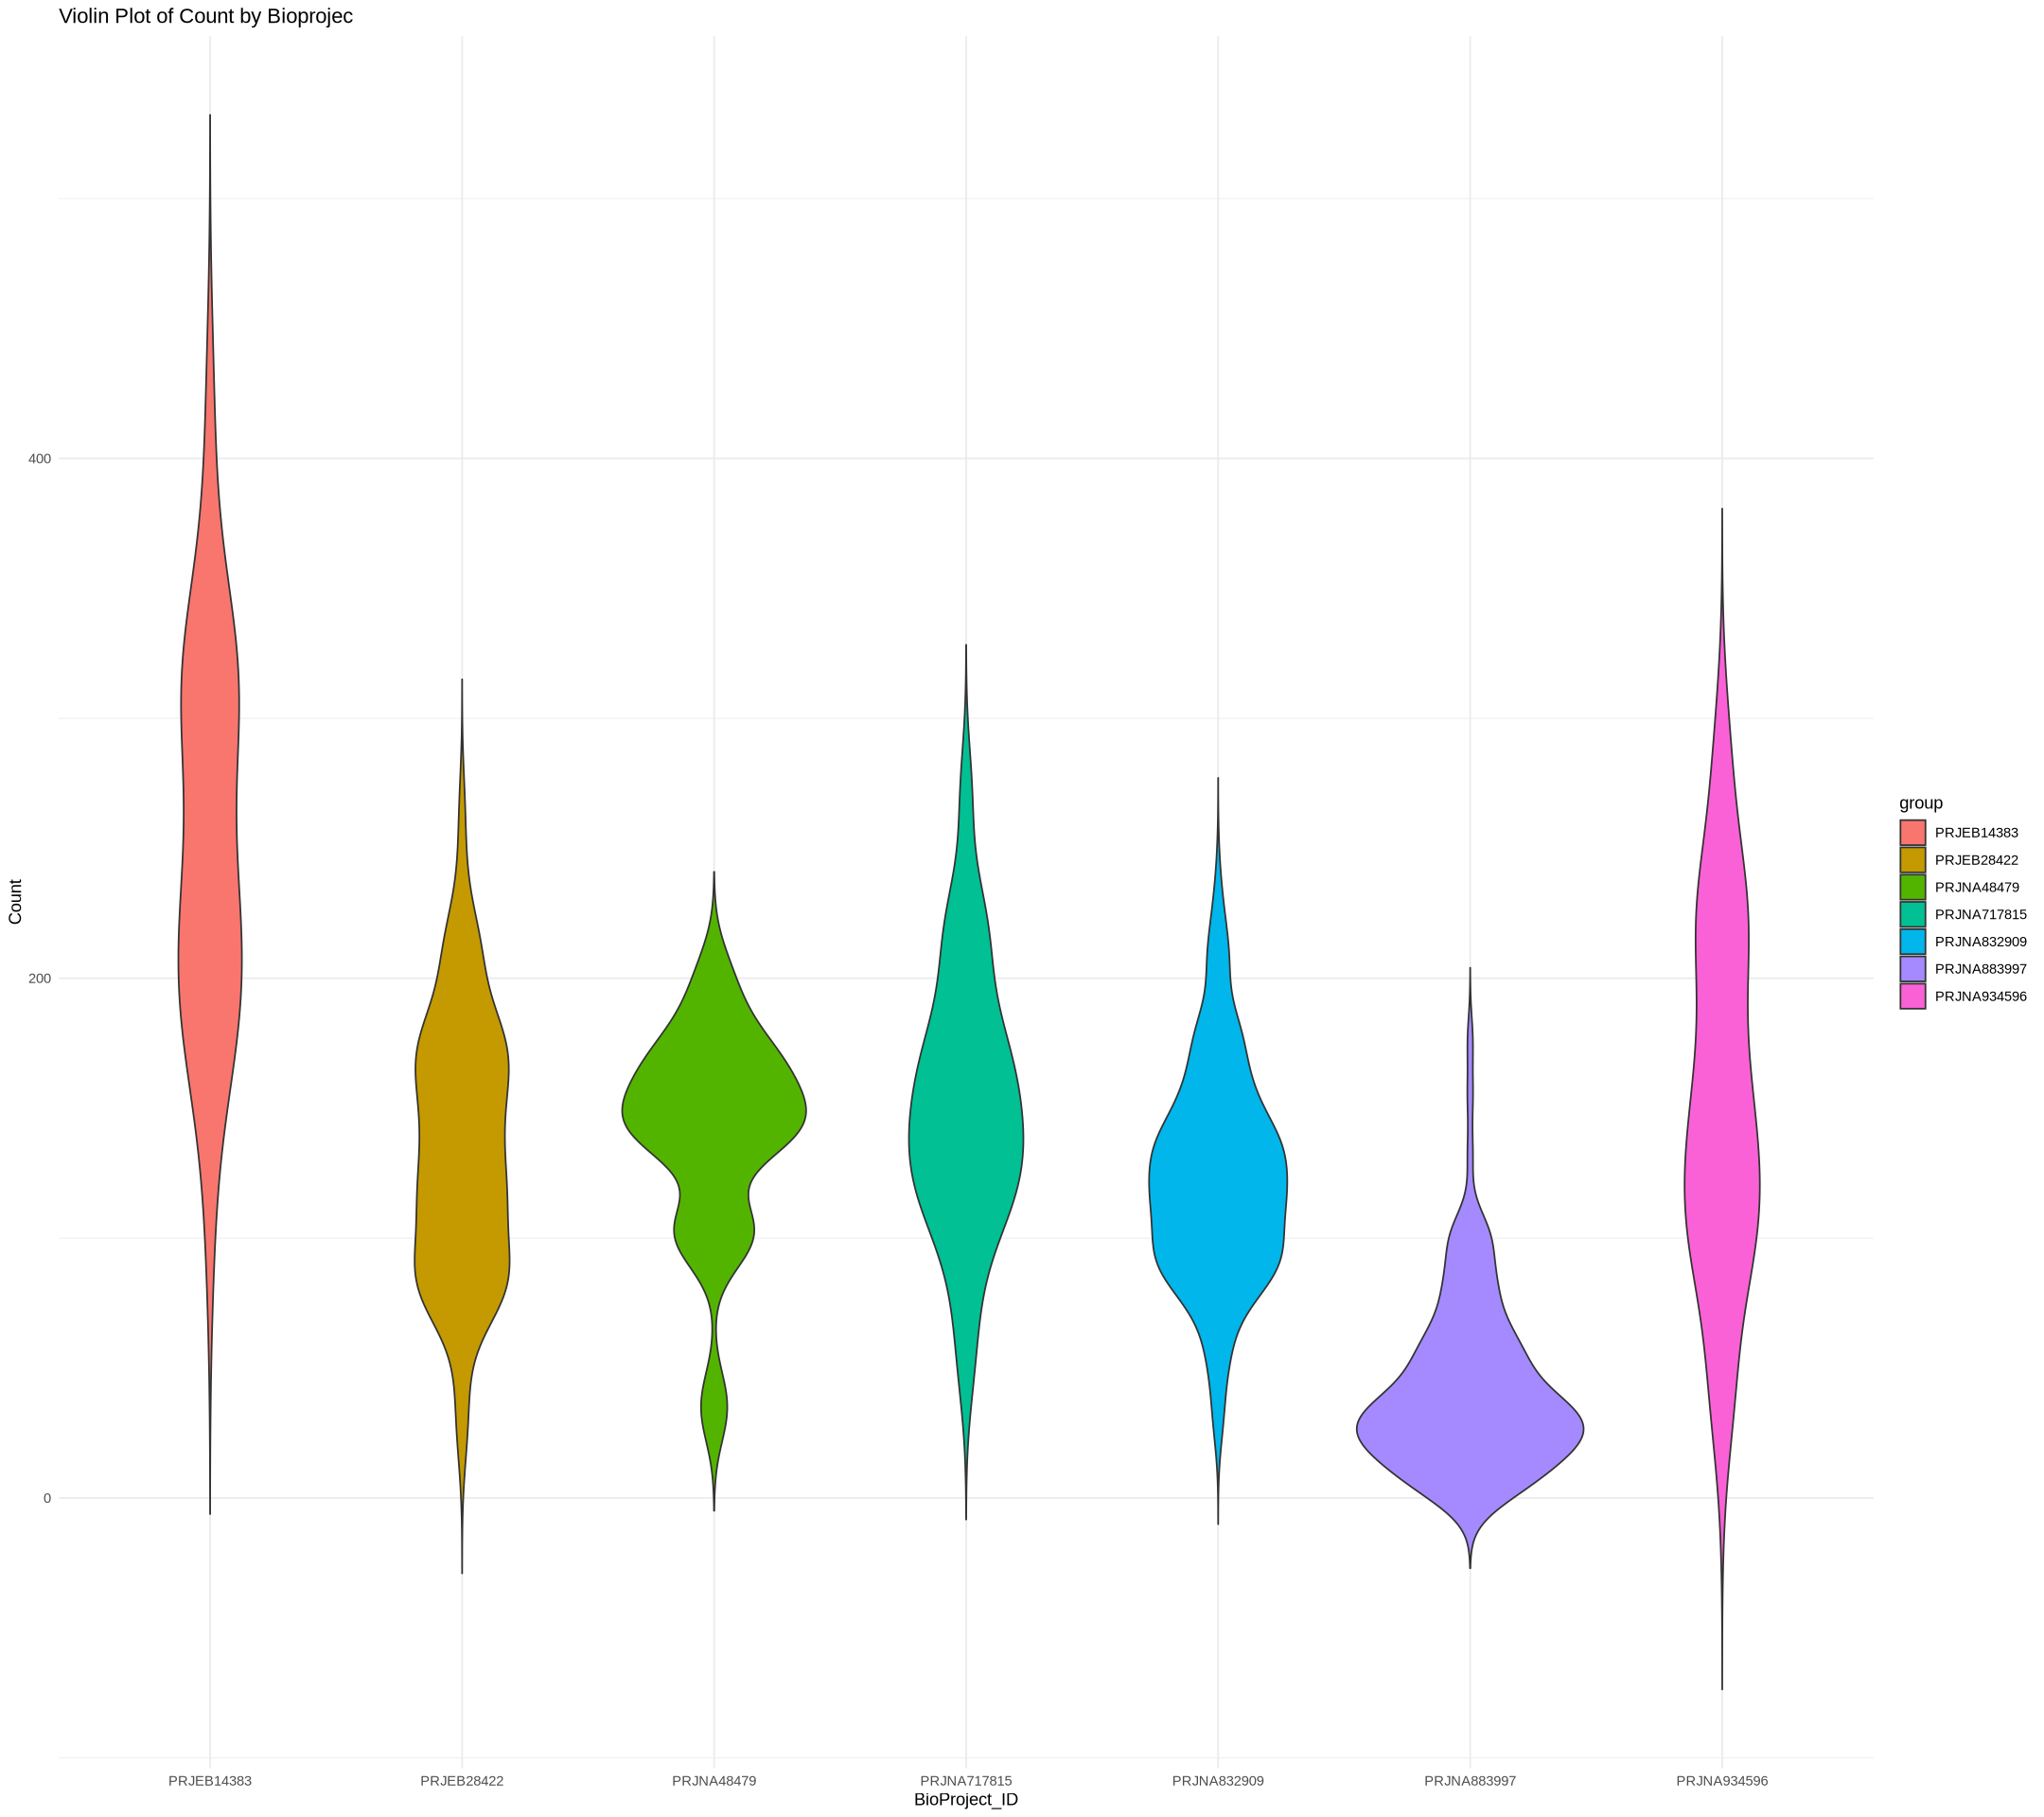

In [77]:
#library(ggplot2)
options(repr.plot.width=18 , repr.plot.height= 16)
# Create a violin plot
ggplot(grouped_richness, aes(x = group, y = count, fill = group)) +
  geom_violin(trim = FALSE) +
  labs(title = "Violin Plot of Count by Bioprojec",
       x = "BioProject_ID",
       y = "Count") +
  theme_minimal()


In [82]:
group_names <- unique(grouped_richness$group)
colors <- rainbow(length(group_names))

In [83]:
options(repr.plot.width=20 , repr.plot.height= 18)
violin <- ggplot(grouped_richness, aes(x = group, y = count, fill = group)) +
  geom_violin(trim = FALSE) +
  scale_fill_manual(values = colors) +  # Assign colors based on group
  labs(title = "Violin Plot of Count by BioProject", 
       x = "BioProject_ID", 
       y = "Count" , size = 18) +
  theme_minimal() + 
theme(text = element_text(size = 18))

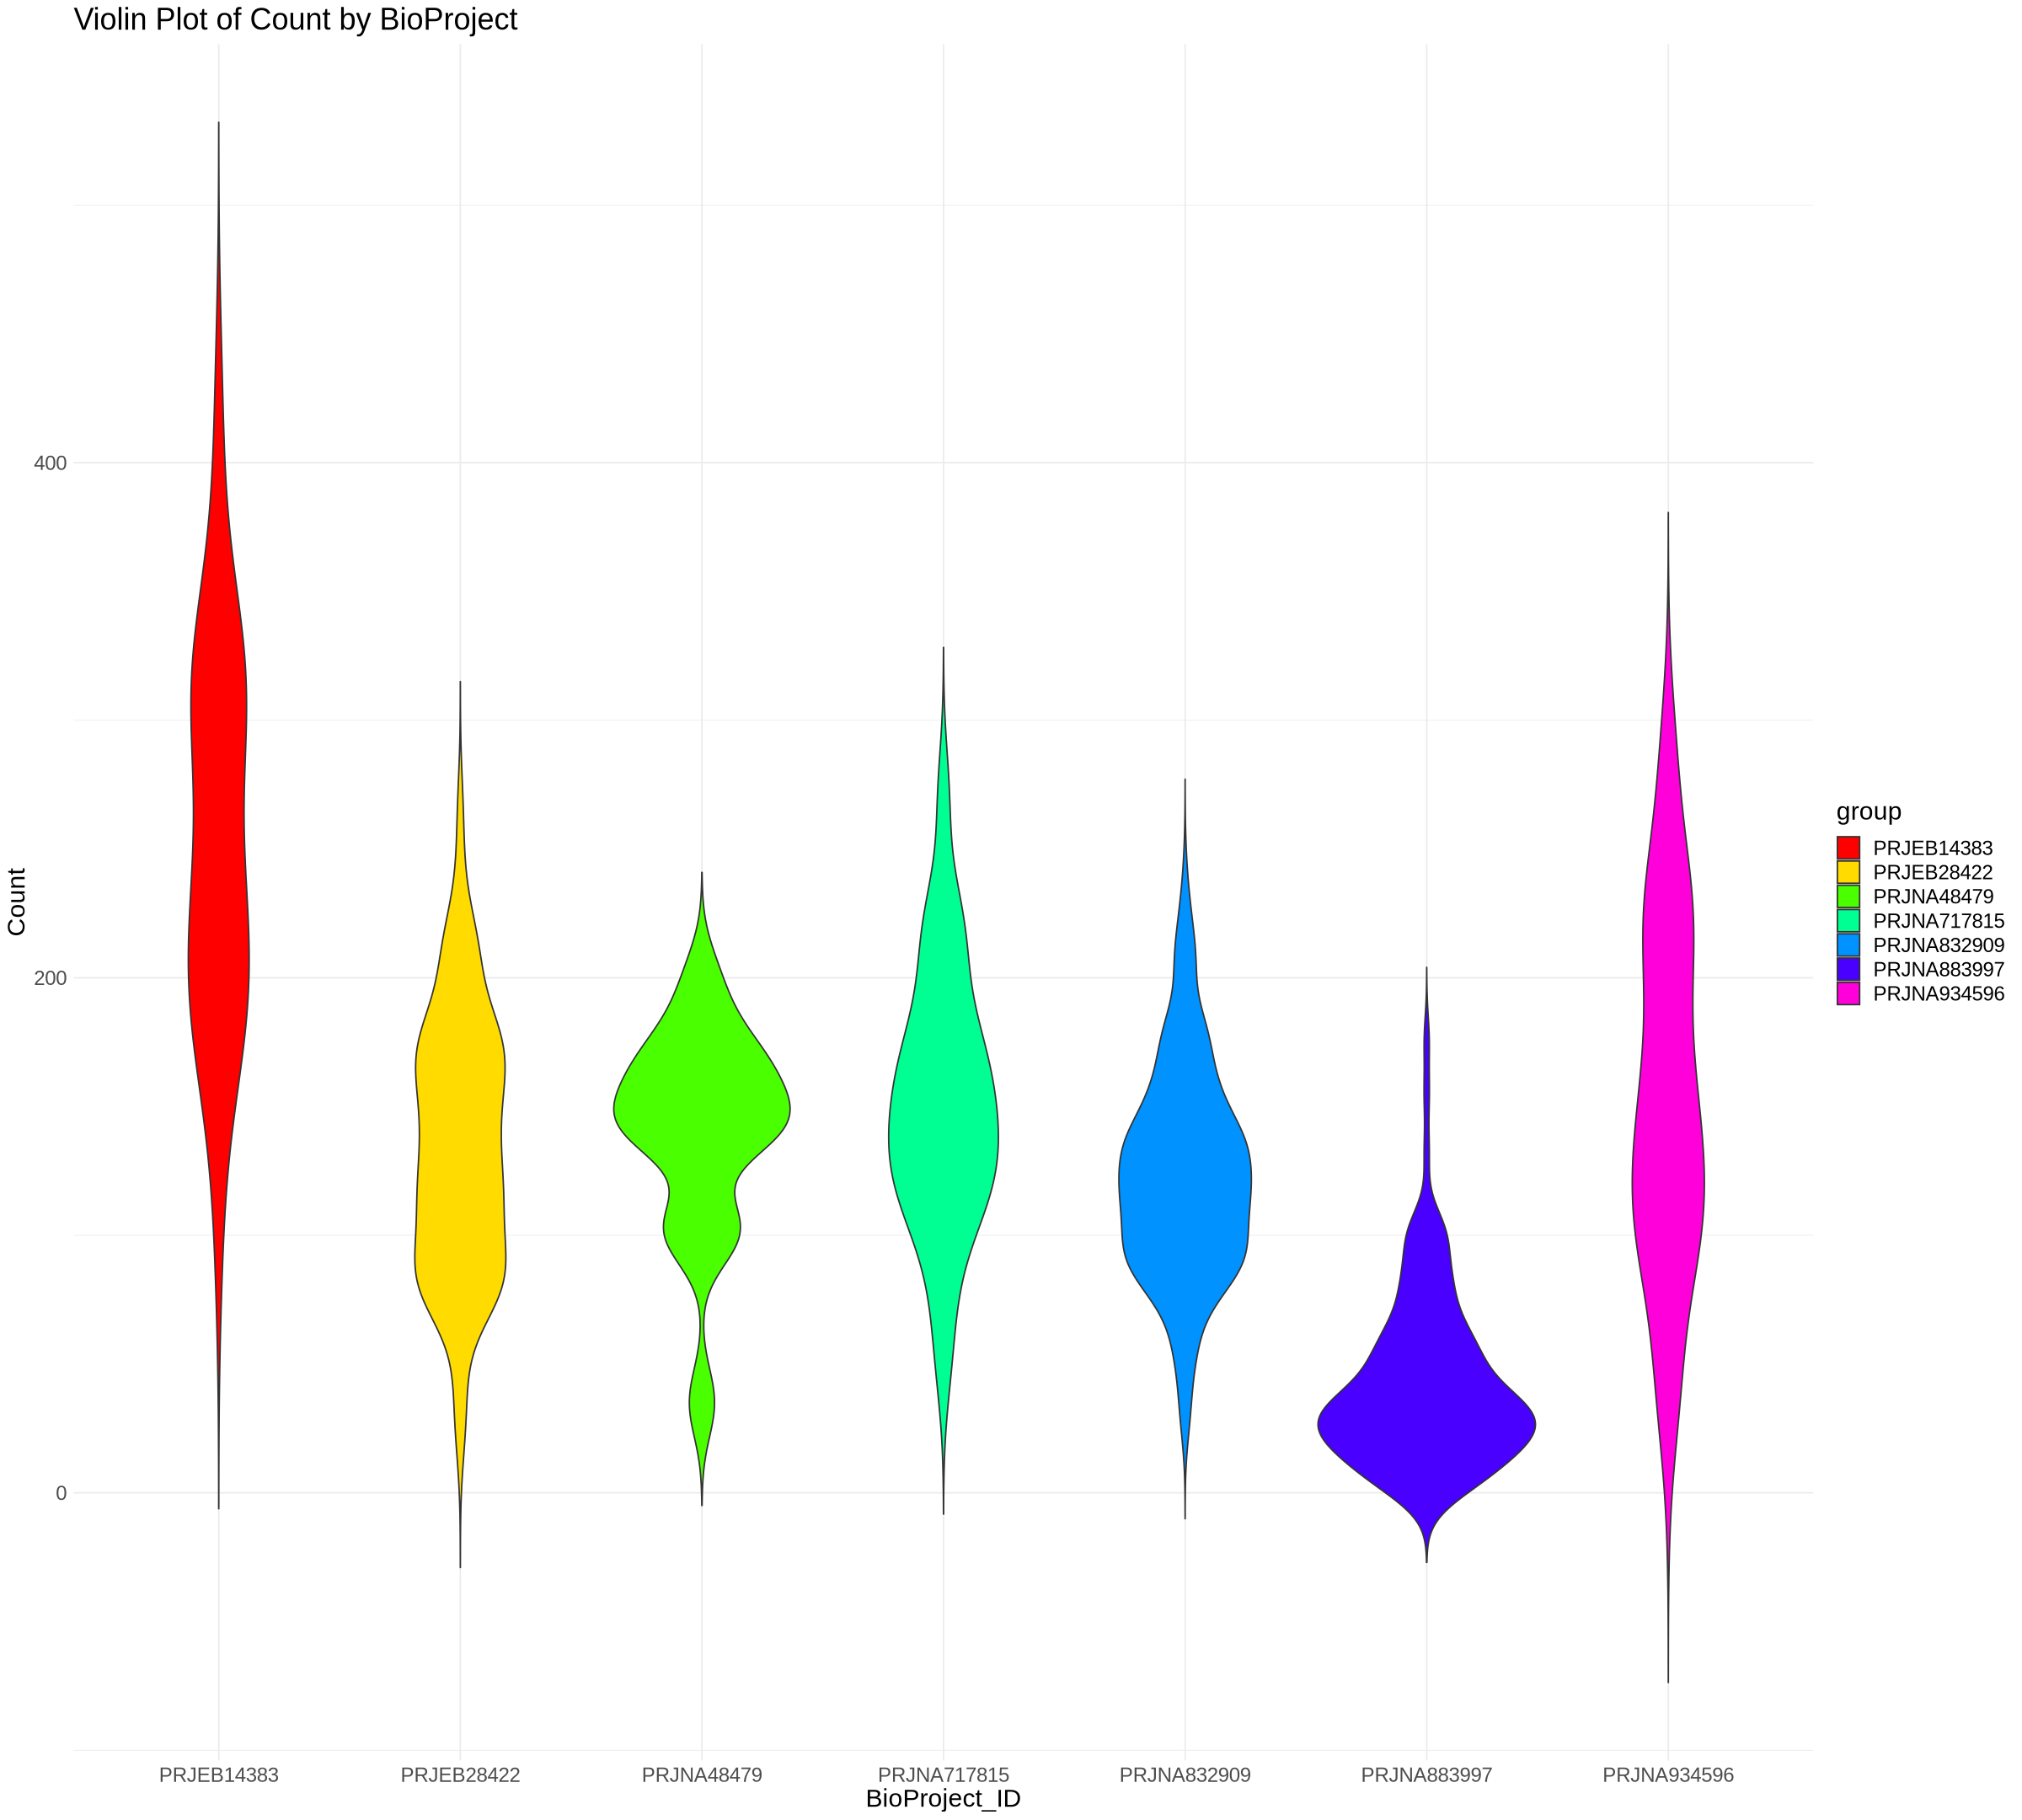

In [84]:
violin

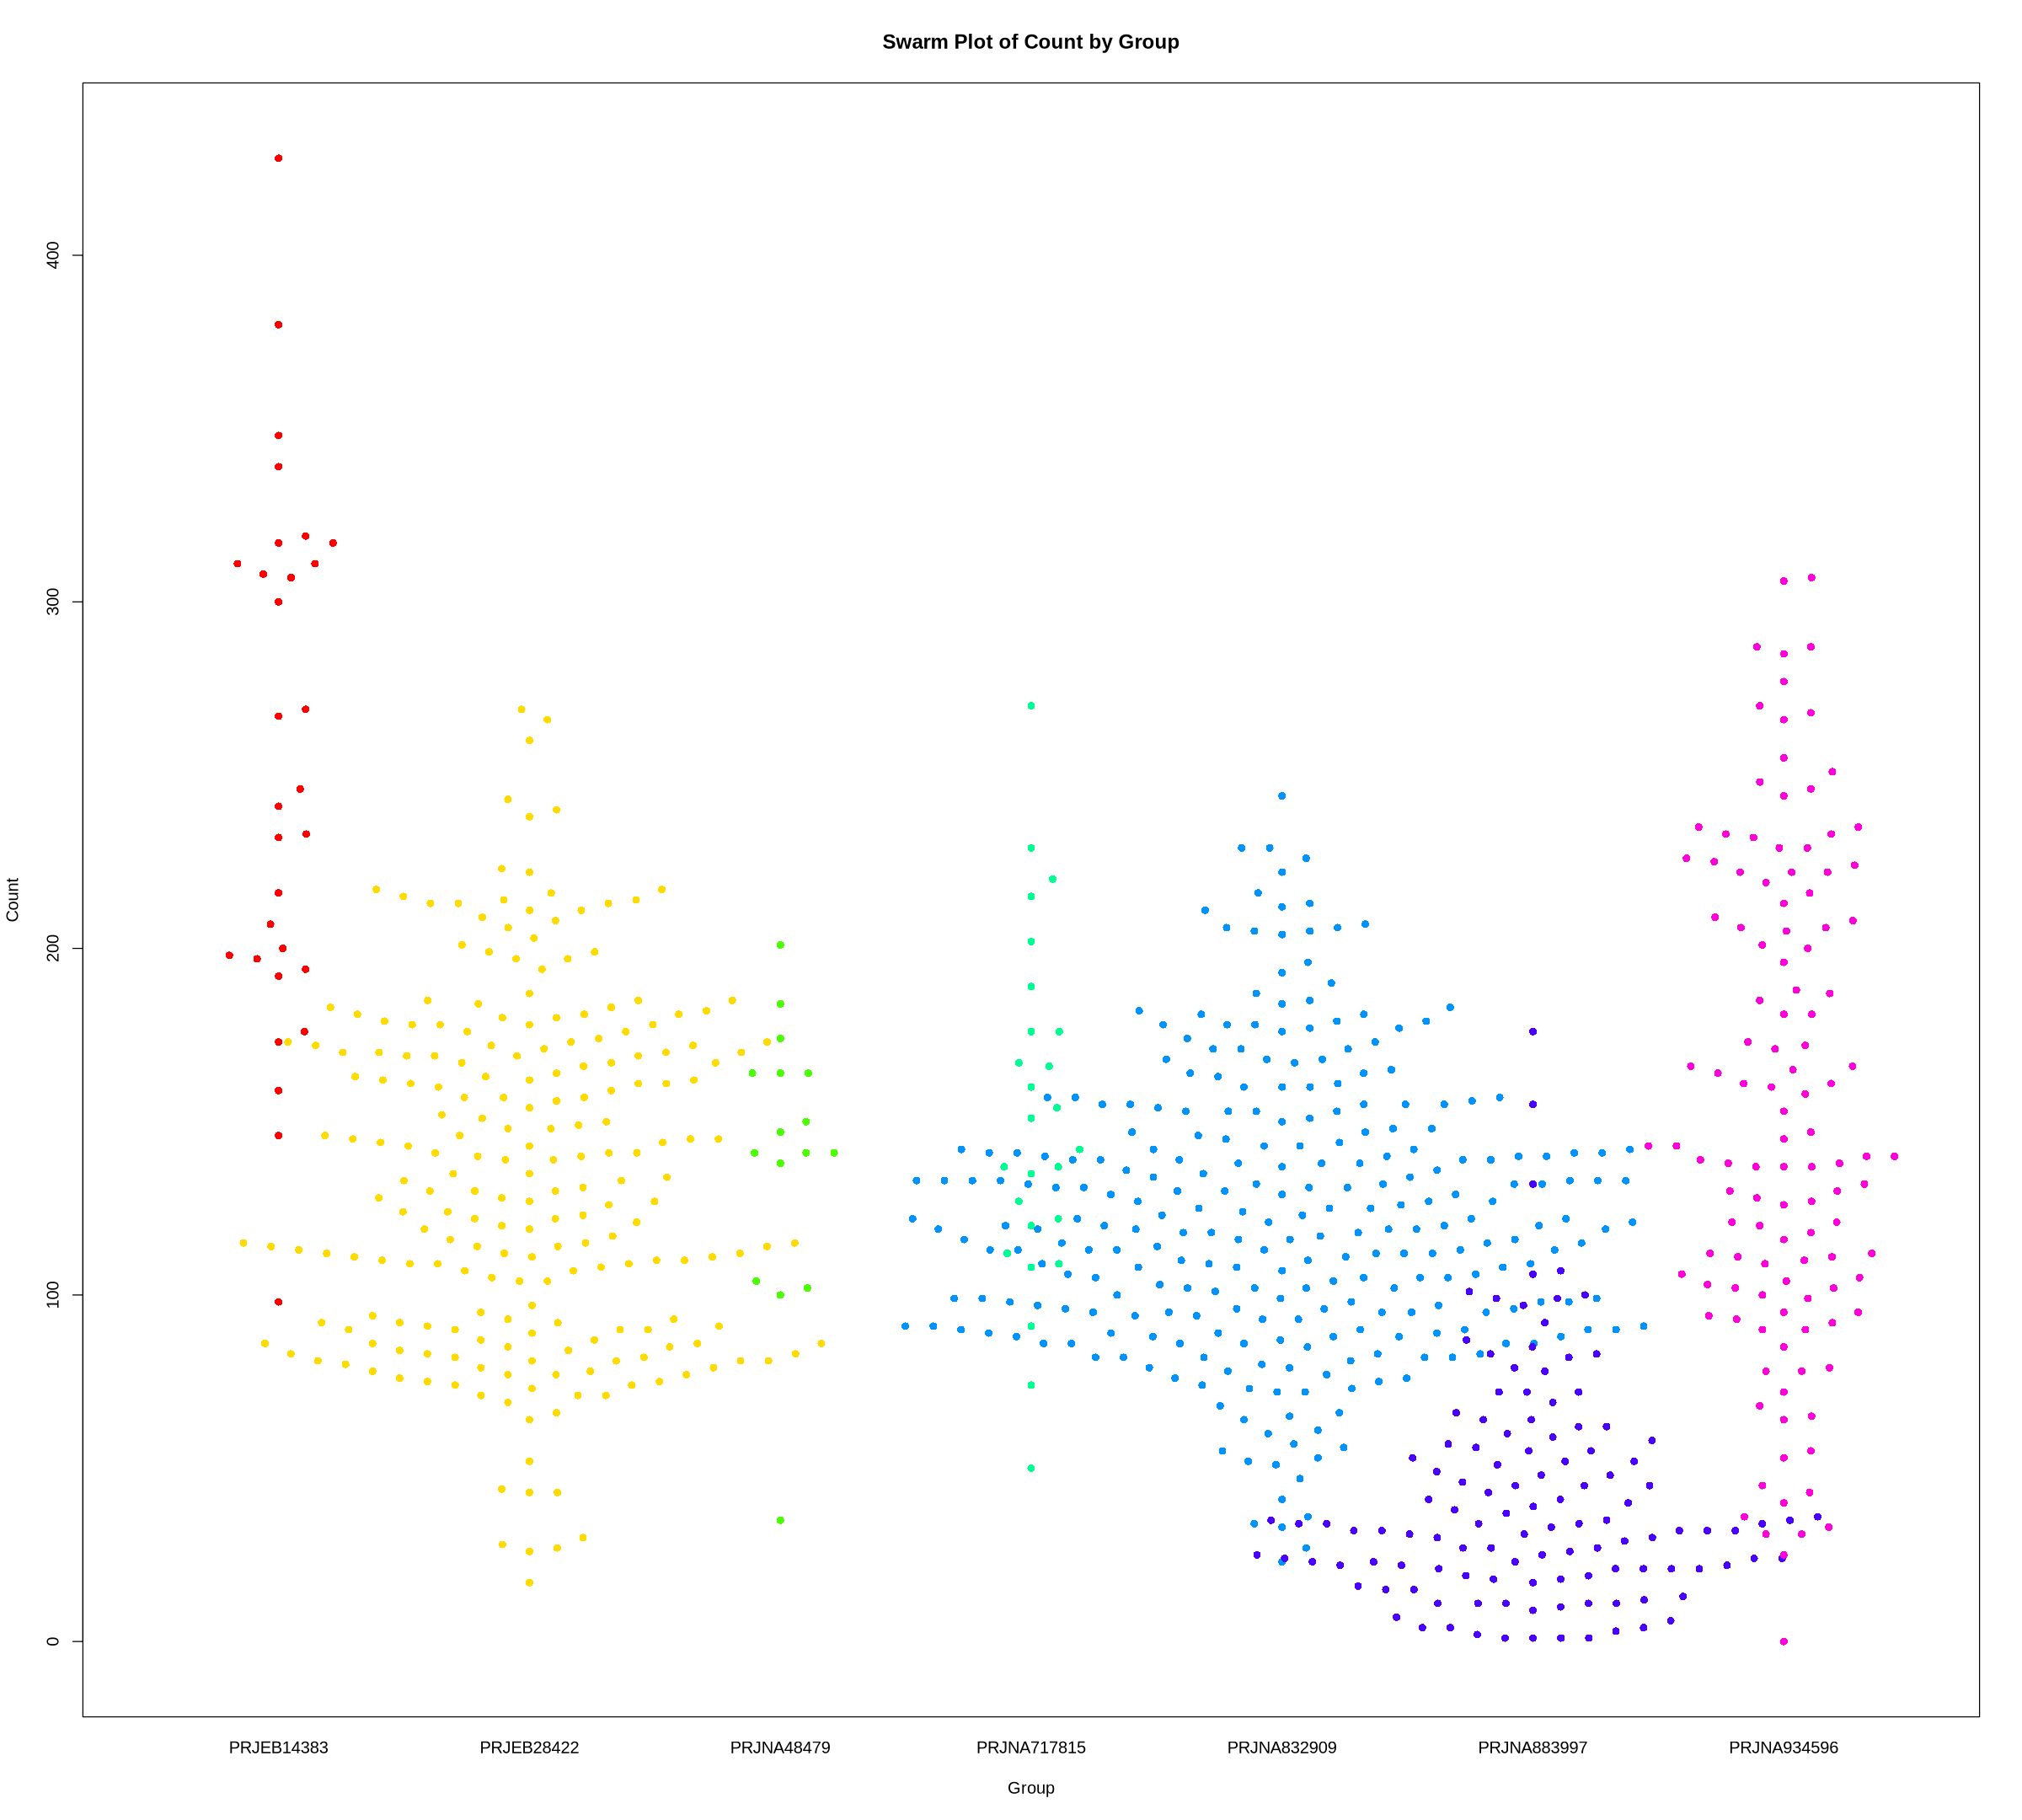

In [85]:
# Create a swarm plot
beeswarm(count ~ group, data = grouped_richness, pch = 16, col = colors ,
         main = "Swarm Plot of Count by Group",
         xlab = "Group", ylab = "Count")


In [236]:
#anova : to see if the differences are statistically significant between bioprojects

In [64]:

anova_result <- aov(count ~ group, data = grouped_richness)
summary(anova_result)

              Df  Sum Sq Mean Sq F value Pr(>F)    
group          7 1582696  226099   88.62 <2e-16 ***
Residuals   1197 3053907    2551                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [65]:
#library(FSA)
dunn_result  <- dunnTest(count ~ group, data = grouped_richness, method="bonferroni")
# Print the results
print(dunn_result)

Warning message:
“group was coerced to a factor.”
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




                   Comparison            Z      P.unadj        P.adj
1     PRJEB14383 - PRJEB28422   6.70654760 1.992829e-11 5.579920e-10
2   PRJEB14383 - PRJNA1057503   5.92019638 3.215574e-09 9.003608e-08
3   PRJEB28422 - PRJNA1057503  -2.17739715 2.945095e-02 8.246265e-01
4     PRJEB14383 - PRJNA48479   3.55225007 3.819517e-04 1.069465e-02
5     PRJEB28422 - PRJNA48479  -0.79151594 4.286430e-01 1.000000e+00
6   PRJNA1057503 - PRJNA48479  -0.08588424 9.315584e-01 1.000000e+00
7    PRJEB14383 - PRJNA717815   3.77934193 1.572434e-04 4.402815e-03
8    PRJEB28422 - PRJNA717815  -1.40820406 1.590707e-01 1.000000e+00
9  PRJNA1057503 - PRJNA717815  -0.53777433 5.907329e-01 1.000000e+00
10   PRJNA48479 - PRJNA717815  -0.27383760 7.842094e-01 1.000000e+00
11   PRJEB14383 - PRJNA832909   7.88997248 3.022532e-15 8.463089e-14
12   PRJEB28422 - PRJNA832909   2.34758525 1.889555e-02 5.290754e-01
13 PRJNA1057503 - PRJNA832909   5.03824718 4.698145e-07 1.315481e-05
14   PRJNA48479 - PRJNA832909   1.

## Number of reads for each samples and effect of depth to the observed species 

In [86]:
setwd("/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/meta_txt/")

In [87]:
#reading the results of staG-mwc TO control number of reads per sample 
reads <- read.table("preprocessing_read_counts.txt", header = TRUE, sep = "\t")

In [88]:
#head(reads)
#dim(reads)

Sample    duplication before_fastp after_fastp after_bowtie2_host_removal
1 DRR494463 0.2397890   32923803     32753620    NA                        
2 DRR494464 0.0894025   33884485     33676595    NA                        
3 DRR494465 0.1502560   32921498     32694452    NA                        
4 DRR494466 0.1582700   38429065     37997497    NA                        
5 DRR494467 0.0873856   40279612     39860069    NA                        
6 DRR494468 0.3094680   75516641     75078745    NA

[1] 1220    5

In [91]:
# removing biosamples with (DRR49, they made errors in qc , so we excluded them)
reads_fl <- reads[!startsWith(reads[[1]], "DRR49"), ]
head(reads_fl)
dim(reads_fl)

Sample     duplication before_fastp after_fastp after_bowtie2_host_removal
16 ERR1474564 0.00562895   7118199      7074239     7062514                  
17 ERR1474565 0.00196505  12261800     10301760    10253957                  
18 ERR1474566 0.00466686  12642324     12627010    12612072                  
19 ERR1474567 0.00154929   7732579      7698204     7680057                  
20 ERR1474568 0.00711808  41891239     41722328    41692821                  
21 ERR1474569 0.00144597   8379176      8225009     8145665

[1] 1205    5

In [93]:
reads_fl <- reads_fl[!startsWith(reads_fl[[1]], "SRR27"), ]
head(reads_fl)
dim(reads_fl)

Sample     duplication before_fastp after_fastp after_bowtie2_host_removal
16 ERR1474564 0.00562895   7118199      7074239     7062514                  
17 ERR1474565 0.00196505  12261800     10301760    10253957                  
18 ERR1474566 0.00466686  12642324     12627010    12612072                  
19 ERR1474567 0.00154929   7732579      7698204     7680057                  
20 ERR1474568 0.00711808  41891239     41722328    41692821                  
21 ERR1474569 0.00144597   8379176      8225009     8145665

[1] 814   5

In [94]:
head(grouped_richness)
dim(grouped_richness)

SAMPLE_ID  count Zeros group     
1 ERR1474564 233   529   PRJEB14383
2 ERR1474565 317   445   PRJEB14383
3 ERR1474566 348   414   PRJEB14383
4 ERR1474567 339   423   PRJEB14383
5 ERR1474568 300   462   PRJEB14383
6 ERR1474569 311   451   PRJEB14383

[1] 814   4

In [275]:
## merge the 2 dataframe "grouped_richness" & "reads_fl"

In [95]:
read_rich <- merge (grouped_richness, reads_fl, by.x = "SAMPLE_ID" , by.y="Sample" )
dim(read_rich)
head(read_rich)

[1] 814   8

SAMPLE_ID  count Zeros group      duplication before_fastp after_fastp
1 ERR1474564 233   529   PRJEB14383 0.00562895   7118199      7074239   
2 ERR1474565 317   445   PRJEB14383 0.00196505  12261800     10301760   
3 ERR1474566 348   414   PRJEB14383 0.00466686  12642324     12627010   
4 ERR1474567 339   423   PRJEB14383 0.00154929   7732579      7698204   
5 ERR1474568 300   462   PRJEB14383 0.00711808  41891239     41722328   
6 ERR1474569 311   451   PRJEB14383 0.00144597   8379176      8225009   
  after_bowtie2_host_removal
1  7062514                  
2 10253957                  
3 12612072                  
4  7680057                  
5 41692821                  
6  8145665

In [96]:
write.table(read_rich, file = "merged_read_richness_814_7bio.txt", sep = "\t", row.names = FALSE)

In [98]:
getwd()

[1] "/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/meta_txt"

### finding threshold, if needed, not necessarily required

In [99]:
setwd("/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/meta_txt")

In [100]:
read_rich <- read.table("merged_read_richness_814_7bio.txt", header = TRUE, sep = "\t")

In [101]:
d <- read_rich
setDT(d)

# Calculate summary statistics by group, i could not use dyplr , i need to figure it out
summary_data <- d[, .(mean_reads = mean(after_bowtie2_host_removal),
                              median_reads = median(after_bowtie2_host_removal),
                              quantile_5 = quantile(after_bowtie2_host_removal, 0.05),
                              quantile_95 = quantile(after_bowtie2_host_removal, 0.95)),
                          by = group]

In [102]:
head(read_rich)

SAMPLE_ID  count Zeros group      duplication before_fastp after_fastp
1 ERR1474564 233   529   PRJEB14383 0.00562895   7118199      7074239   
2 ERR1474565 317   445   PRJEB14383 0.00196505  12261800     10301760   
3 ERR1474566 348   414   PRJEB14383 0.00466686  12642324     12627010   
4 ERR1474567 339   423   PRJEB14383 0.00154929   7732579      7698204   
5 ERR1474568 300   462   PRJEB14383 0.00711808  41891239     41722328   
6 ERR1474569 311   451   PRJEB14383 0.00144597   8379176      8225009   
  after_bowtie2_host_removal
1  7062514                  
2 10253957                  
3 12612072                  
4  7680057                  
5 41692821                  
6  8145665

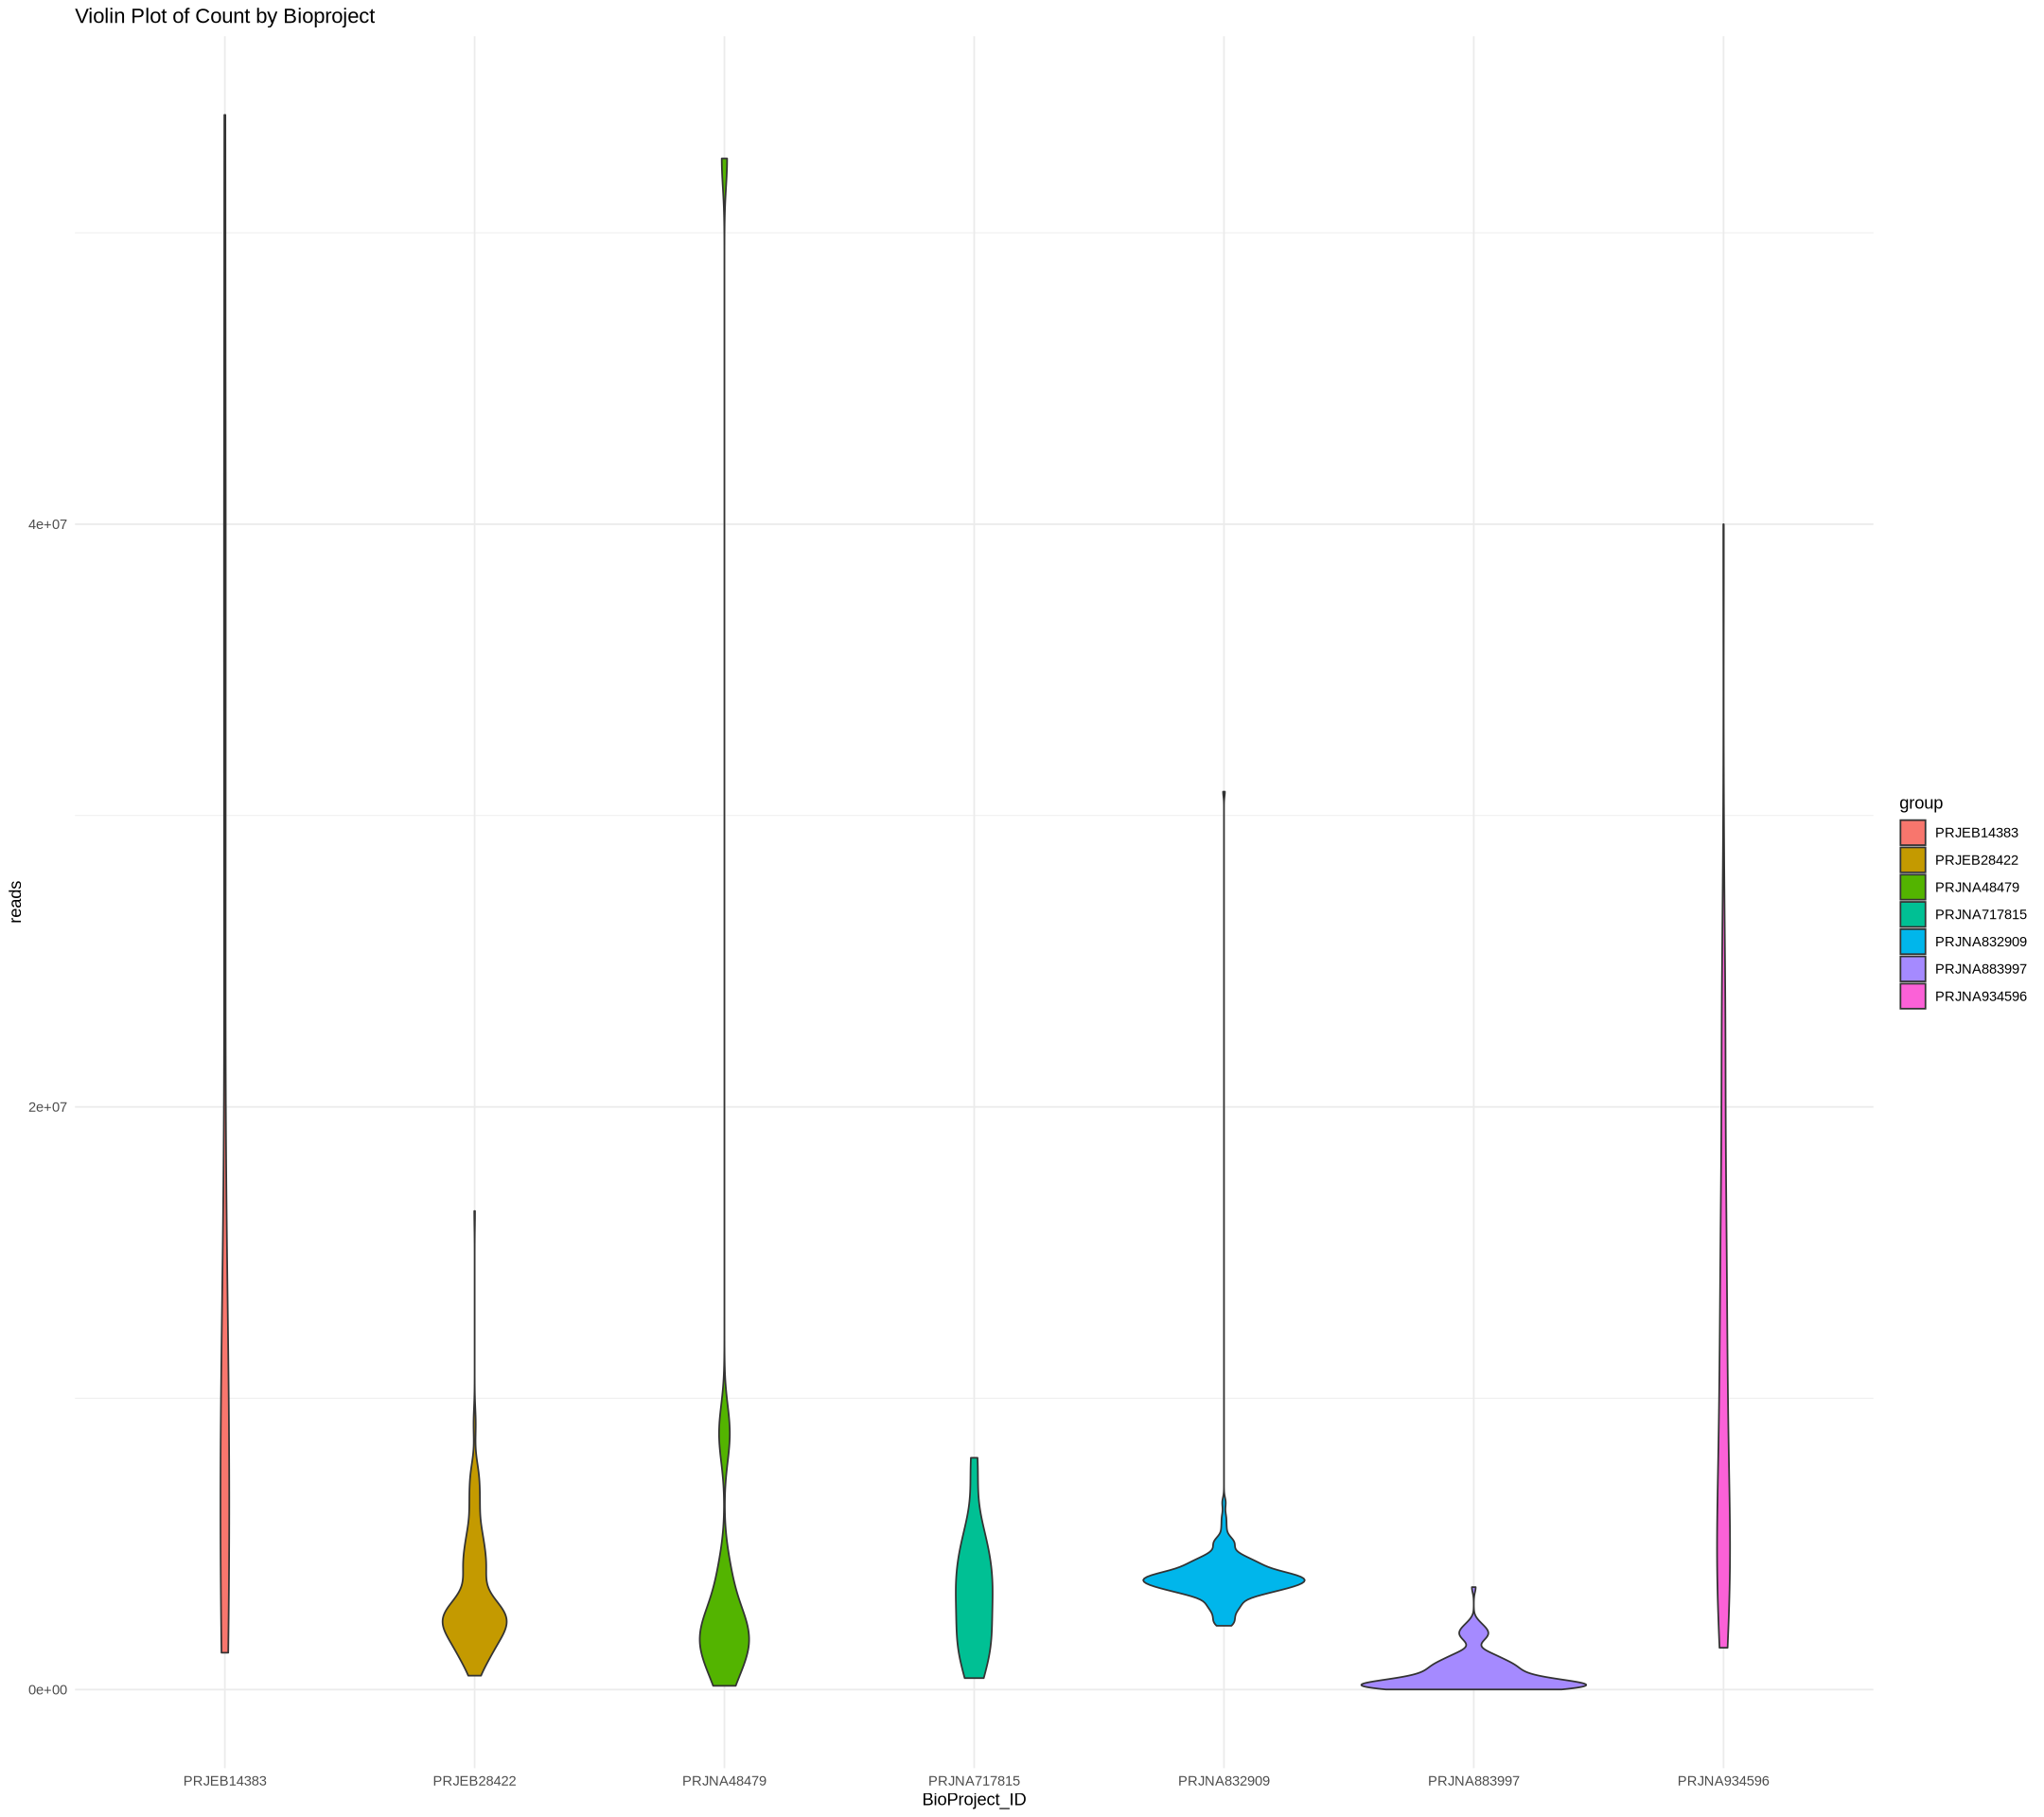

In [103]:
#library(ggplot2)
options(repr.plot.width=18 , repr.plot.height= 16)
# Create a violin plot
ggplot(read_rich, aes(x = group, y = after_bowtie2_host_removal , fill = group)) +
  geom_violin() +
  labs(title = "Violin Plot of Count by Bioproject",
       x = "BioProject_ID",
       y = "reads") +
  theme_minimal()


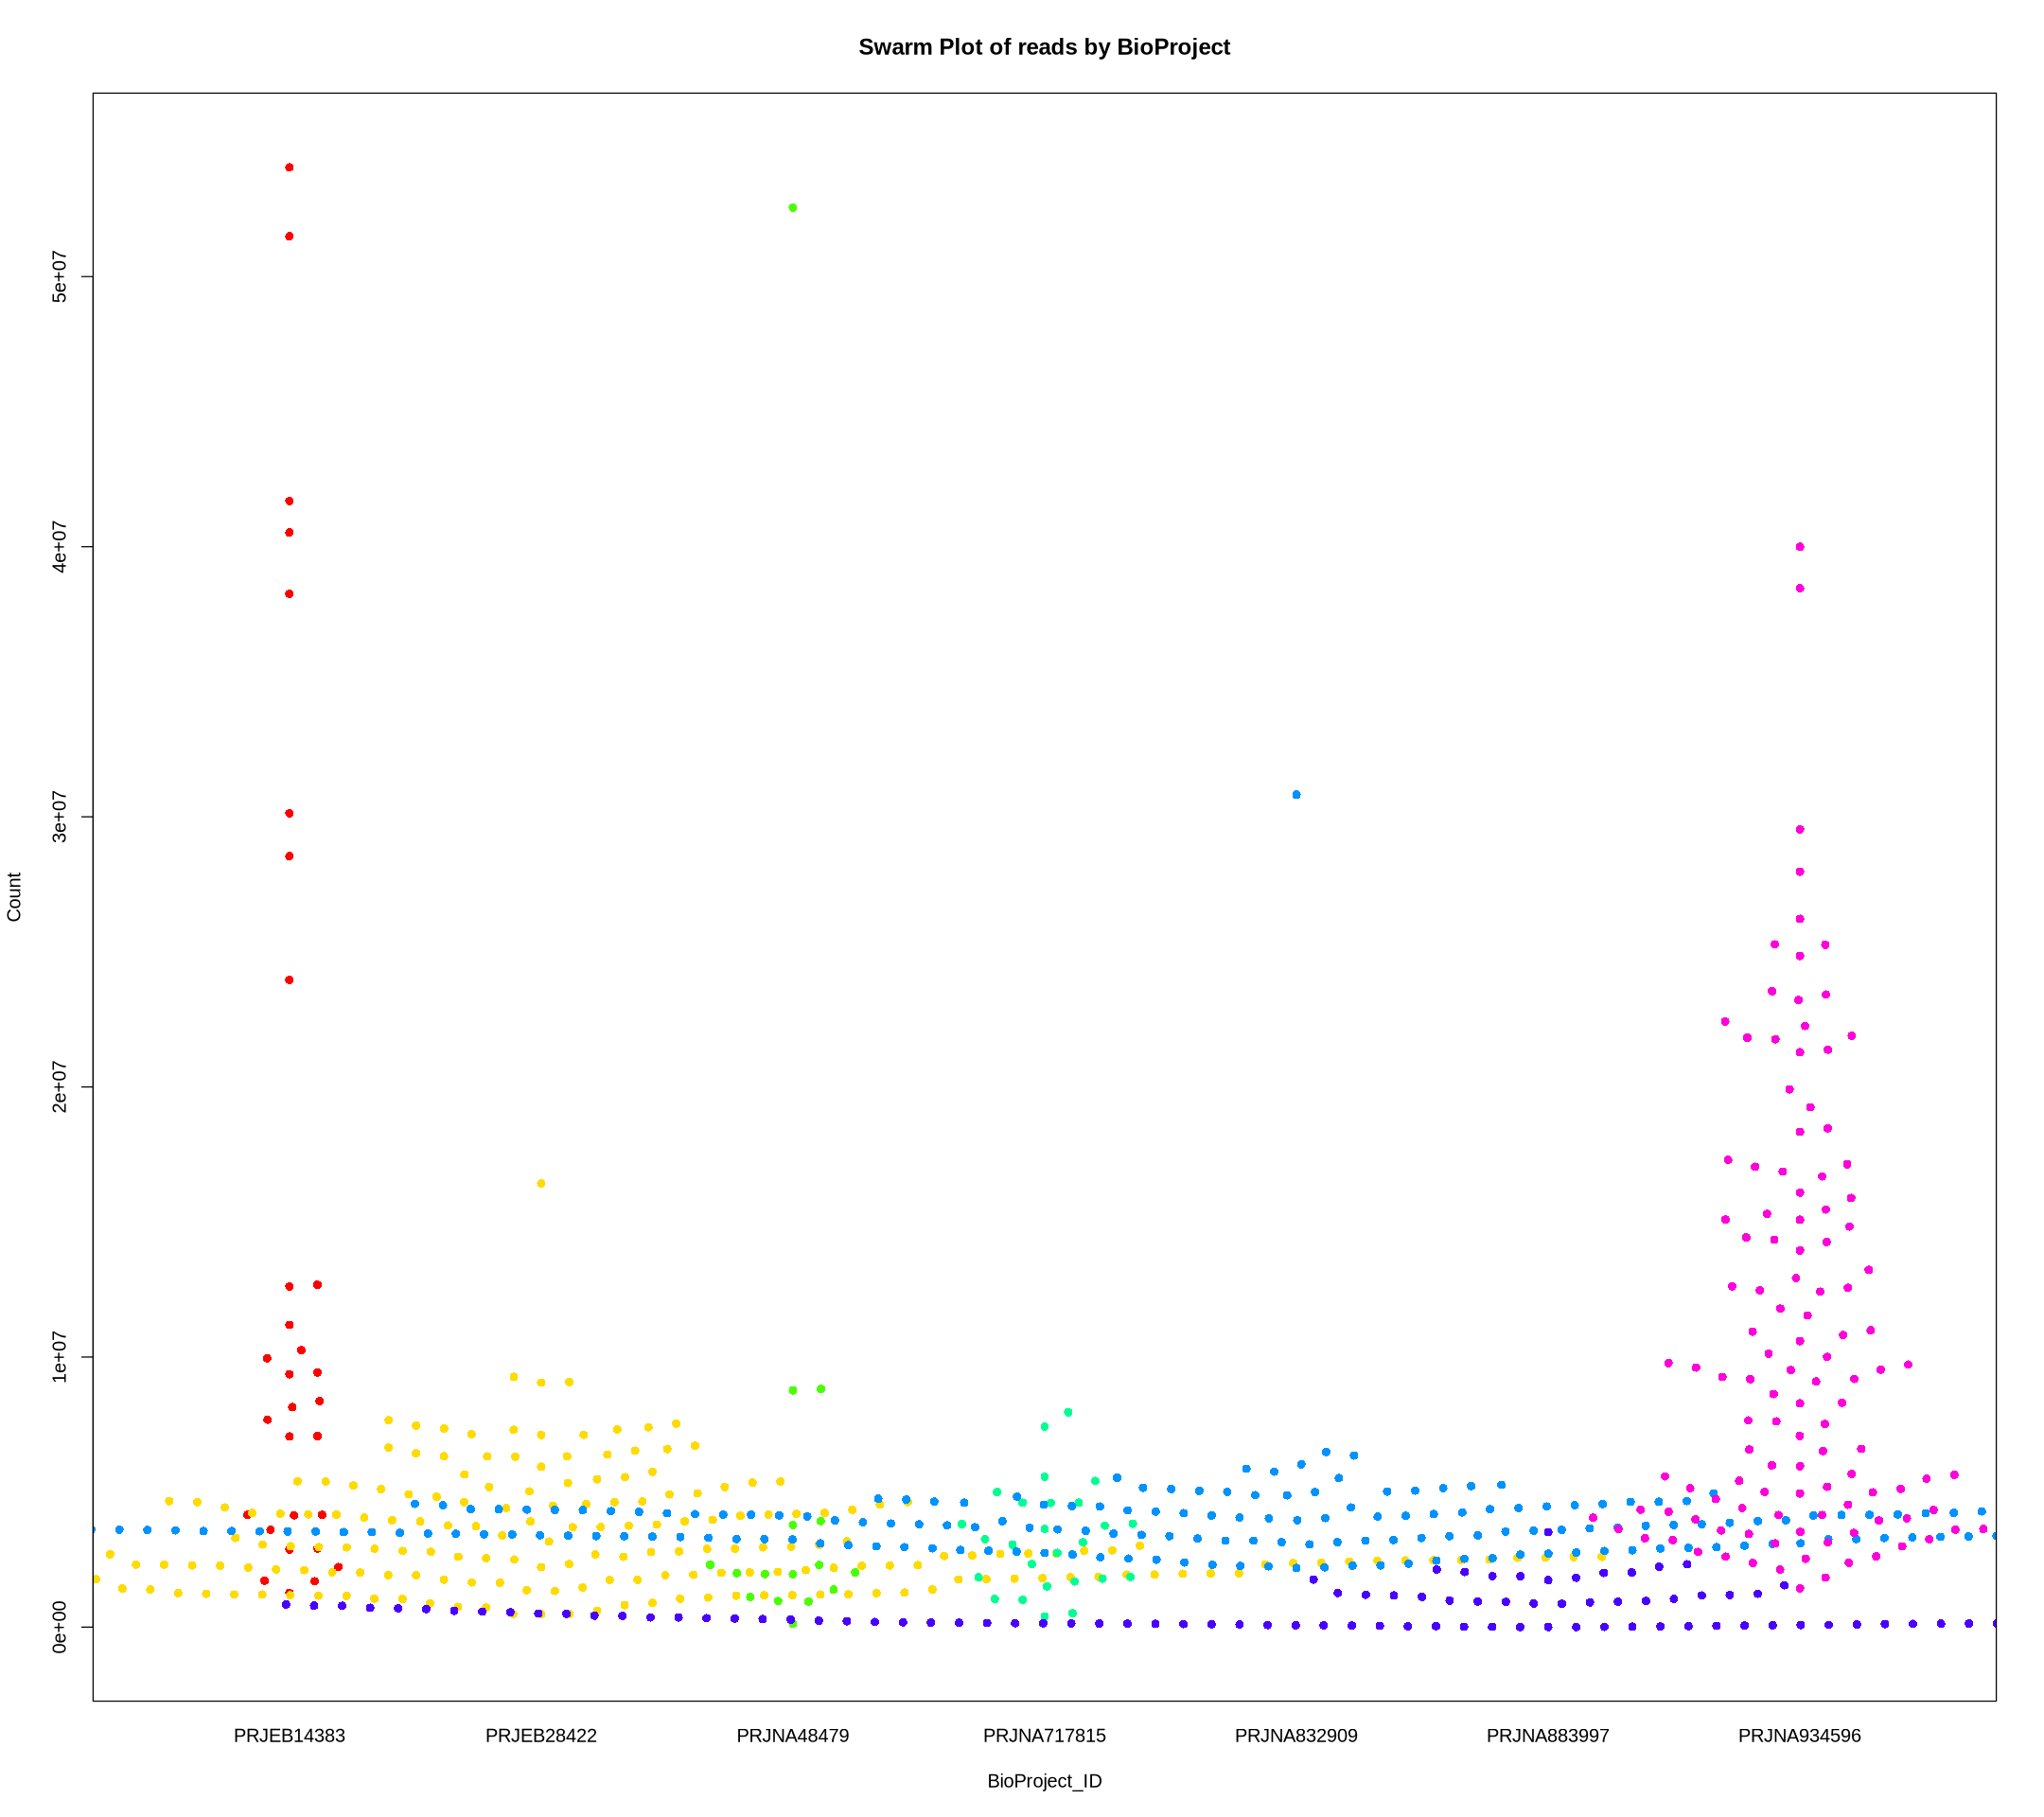

In [105]:
group_names <- unique(read_rich$group)

# Create a color palette with a different color for each group
colors <- rainbow(length(group_names))
beeswarm(after_bowtie2_host_removal ~ group, data = read_rich, pch = 16, col = colors ,
         main = "Swarm Plot of reads by BioProject",
         xlab = "BioProject_ID", ylab = "Count")


In [106]:
anova_result1 <- aov(after_bowtie2_host_removal ~ group, data = read_rich)
summary(anova_result1)

             Df    Sum Sq   Mean Sq F value Pr(>F)    
group         6 1.060e+16 1.766e+15   74.98 <2e-16 ***
Residuals   807 1.901e+16 2.356e+13                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [107]:
library(FSA)
dunn_result1  <- dunnTest(after_bowtie2_host_removal ~ group, data = read_rich, method="bonferroni")
# Print the results
print(dunn_result1)

Warning message:
“group was coerced to a factor.”
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




                  Comparison           Z      P.unadj        P.adj
1    PRJEB14383 - PRJEB28422   5.7893829 7.064547e-09 1.483555e-07
2    PRJEB14383 - PRJNA48479   4.2573518 2.068627e-05 4.344117e-04
3    PRJEB28422 - PRJNA48479   0.7409583 4.587187e-01 1.000000e+00
4   PRJEB14383 - PRJNA717815   3.8378339 1.241244e-04 2.606612e-03
5   PRJEB28422 - PRJNA717815  -0.4719019 6.369968e-01 1.000000e+00
6   PRJNA48479 - PRJNA717815  -0.9114739 3.620458e-01 1.000000e+00
7   PRJEB14383 - PRJNA832909   3.4036374 6.649495e-04 1.396394e-02
8   PRJEB28422 - PRJNA832909  -5.2662236 1.392586e-07 2.924431e-06
9   PRJNA48479 - PRJNA832909  -2.5849264 9.739978e-03 2.045395e-01
10 PRJNA717815 - PRJNA832909  -1.8281618 6.752528e-02 1.000000e+00
11  PRJEB14383 - PRJNA883997  11.4388976 2.672597e-30 5.612453e-29
12  PRJEB28422 - PRJNA883997  10.6686908 1.426216e-26 2.995054e-25
13  PRJNA48479 - PRJNA883997   3.8212527 1.327755e-04 2.788286e-03
14 PRJNA717815 - PRJNA883997   6.0402039 1.539196e-09 3.232311

`geom_smooth()` using formula = 'y ~ x'


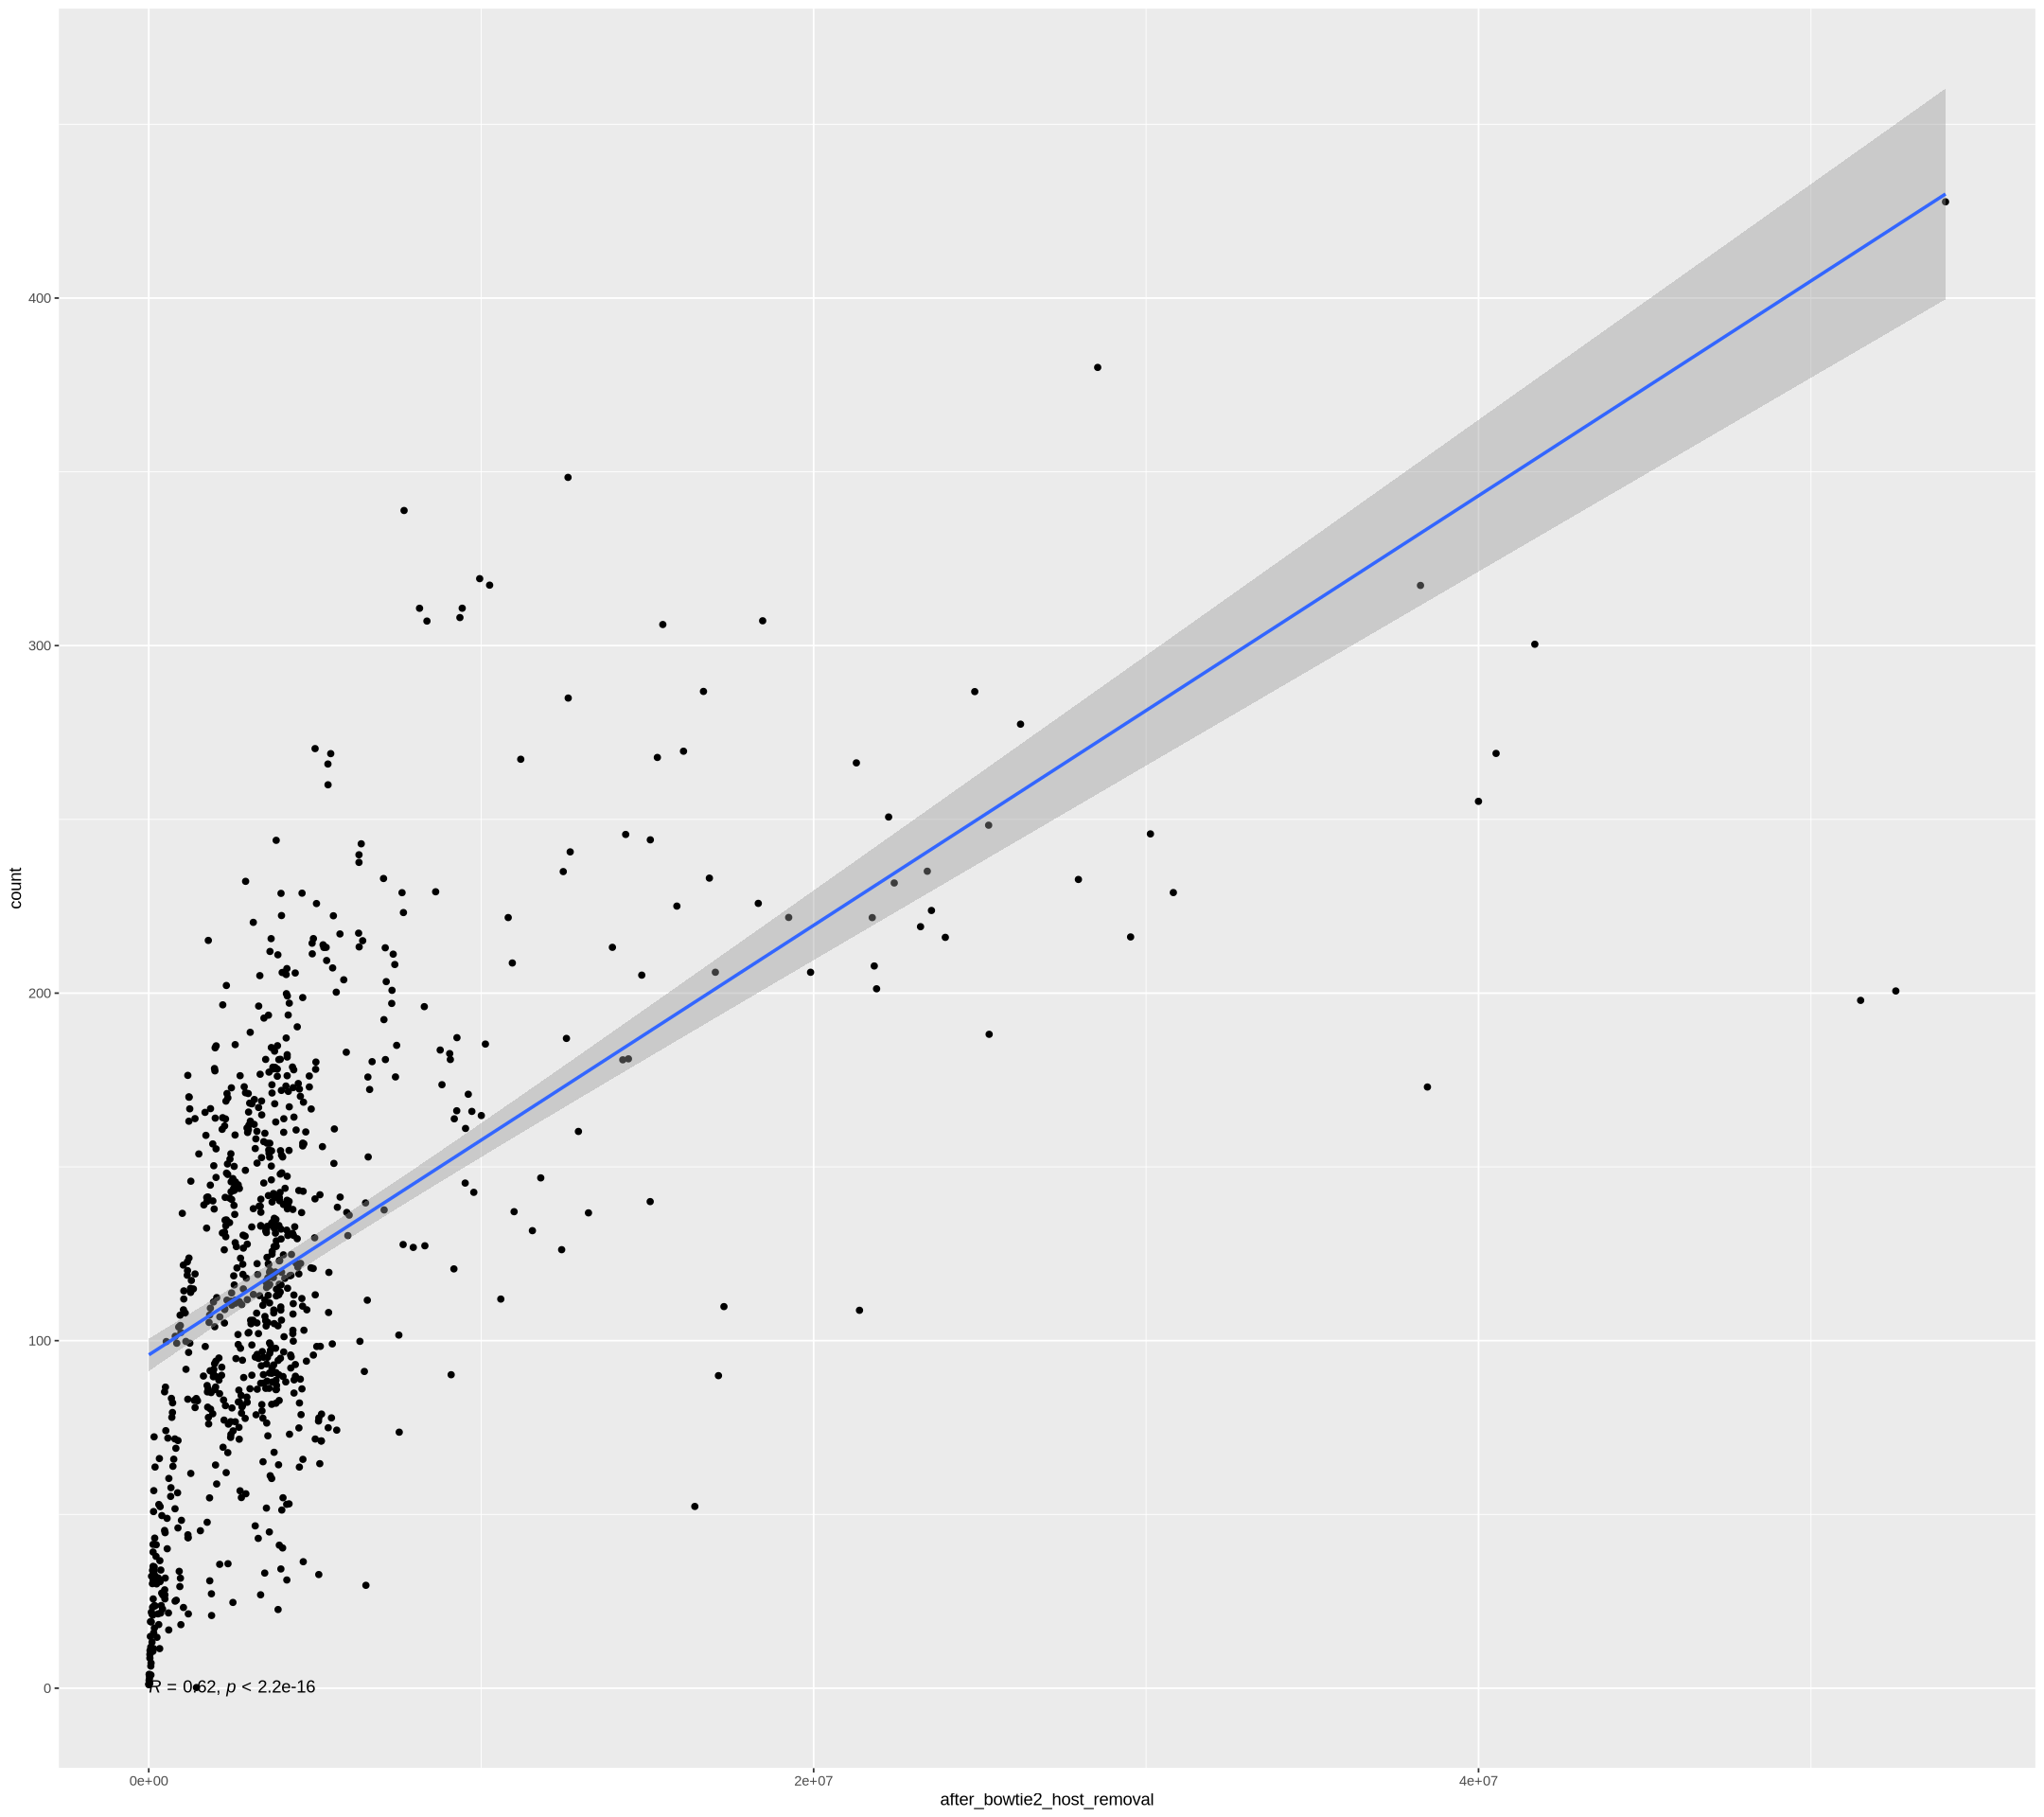

In [108]:
b3 <- ggplot(read_rich, aes(y = count , x = after_bowtie2_host_removal))
# Scatter plot with regression line
b3 + geom_point(position = position_jitter(width = 0.4, height = 0.4))+
  geom_smooth(method = "lm" , fullrange = FALSE) +
 stat_cor(method = "spearman", 
           label.x = 0, label.y = 0) 

`geom_smooth()` using formula = 'y ~ x'


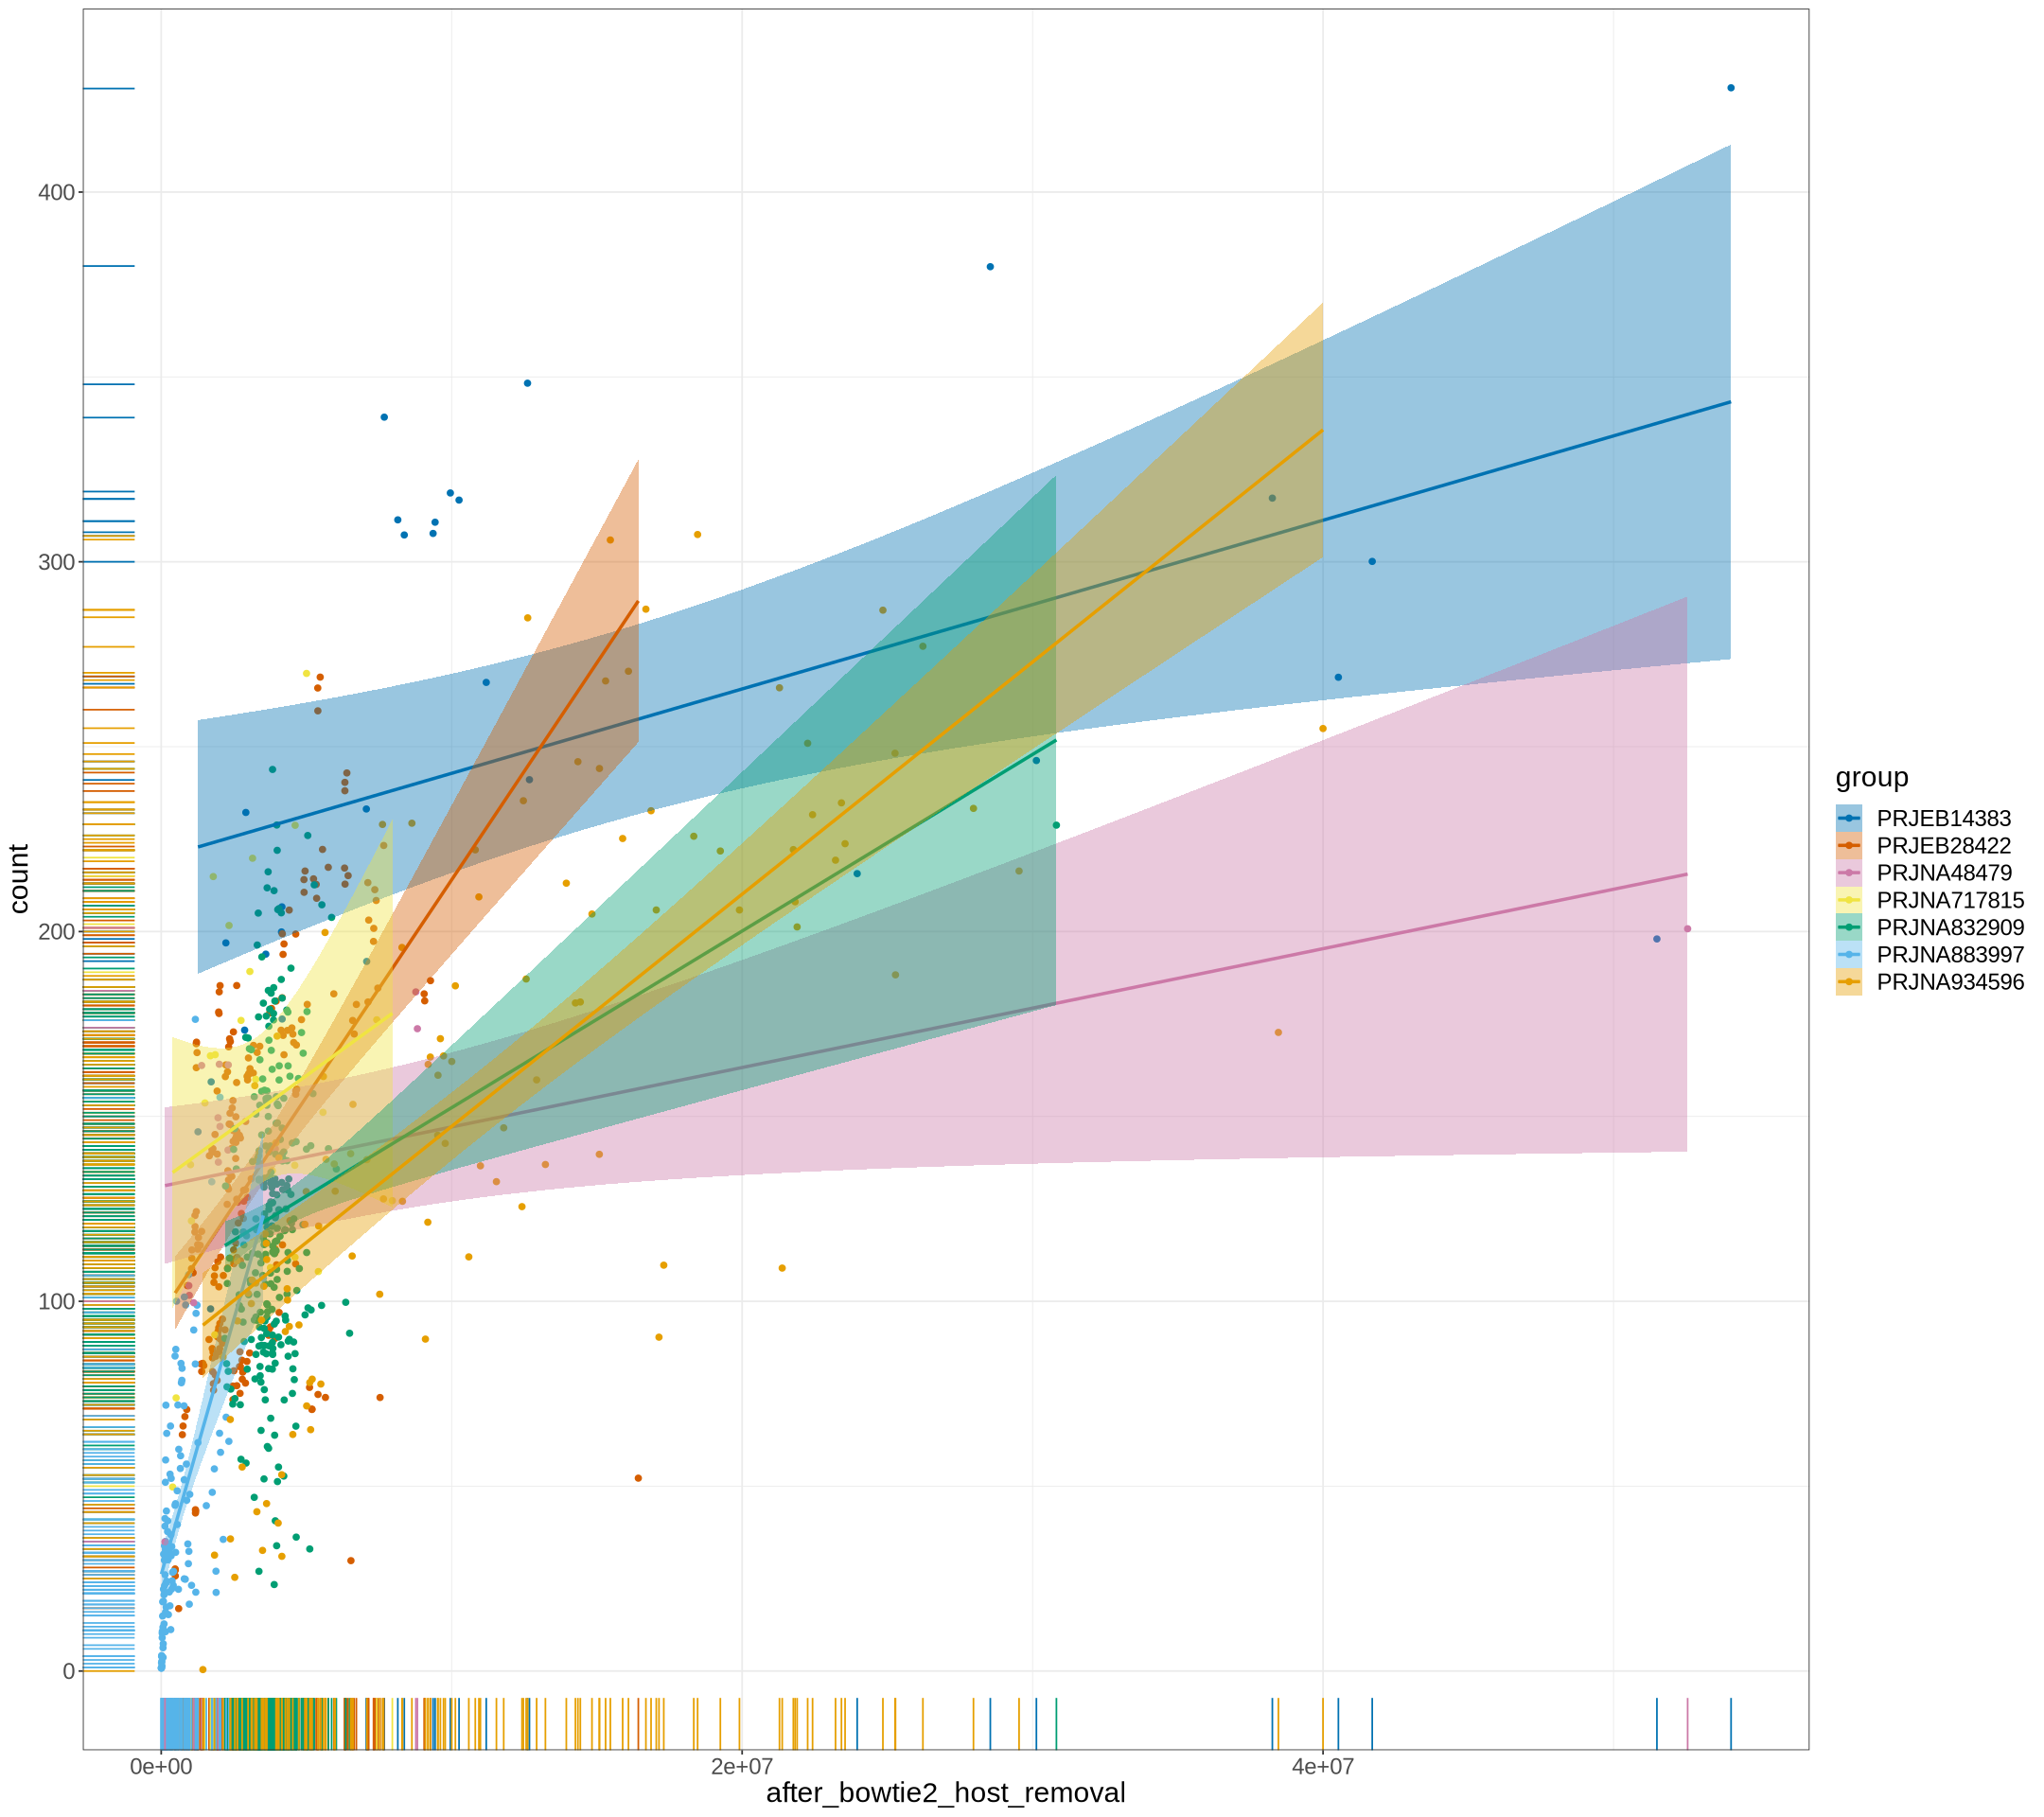

In [109]:

  p <- b3 +
  geom_point(position = position_jitter(width = 0.4, height = 0.4), aes(color = group)) +
  geom_smooth(aes(color = group, fill = group), method = "lm" , fullrange = FALSE) +
  geom_rug(aes(color = group)) +
  scale_color_manual(values = c("#0072B2", "#D55E00", "#CC79A7", "#F0E442", "#009E73", "#56B4E9", "#E69F00")) +
  scale_fill_manual(values = c("#0072B2", "#D55E00", "#CC79A7", "#F0E442", "#009E73", "#56B4E9", "#E69F00" )) +
  theme_bw()+ 
  theme(text = element_text(size = 18))
p


In [113]:
options(repr.plot.width=16, repr.plot.height=12)

`geom_smooth()` using formula = 'y ~ x'


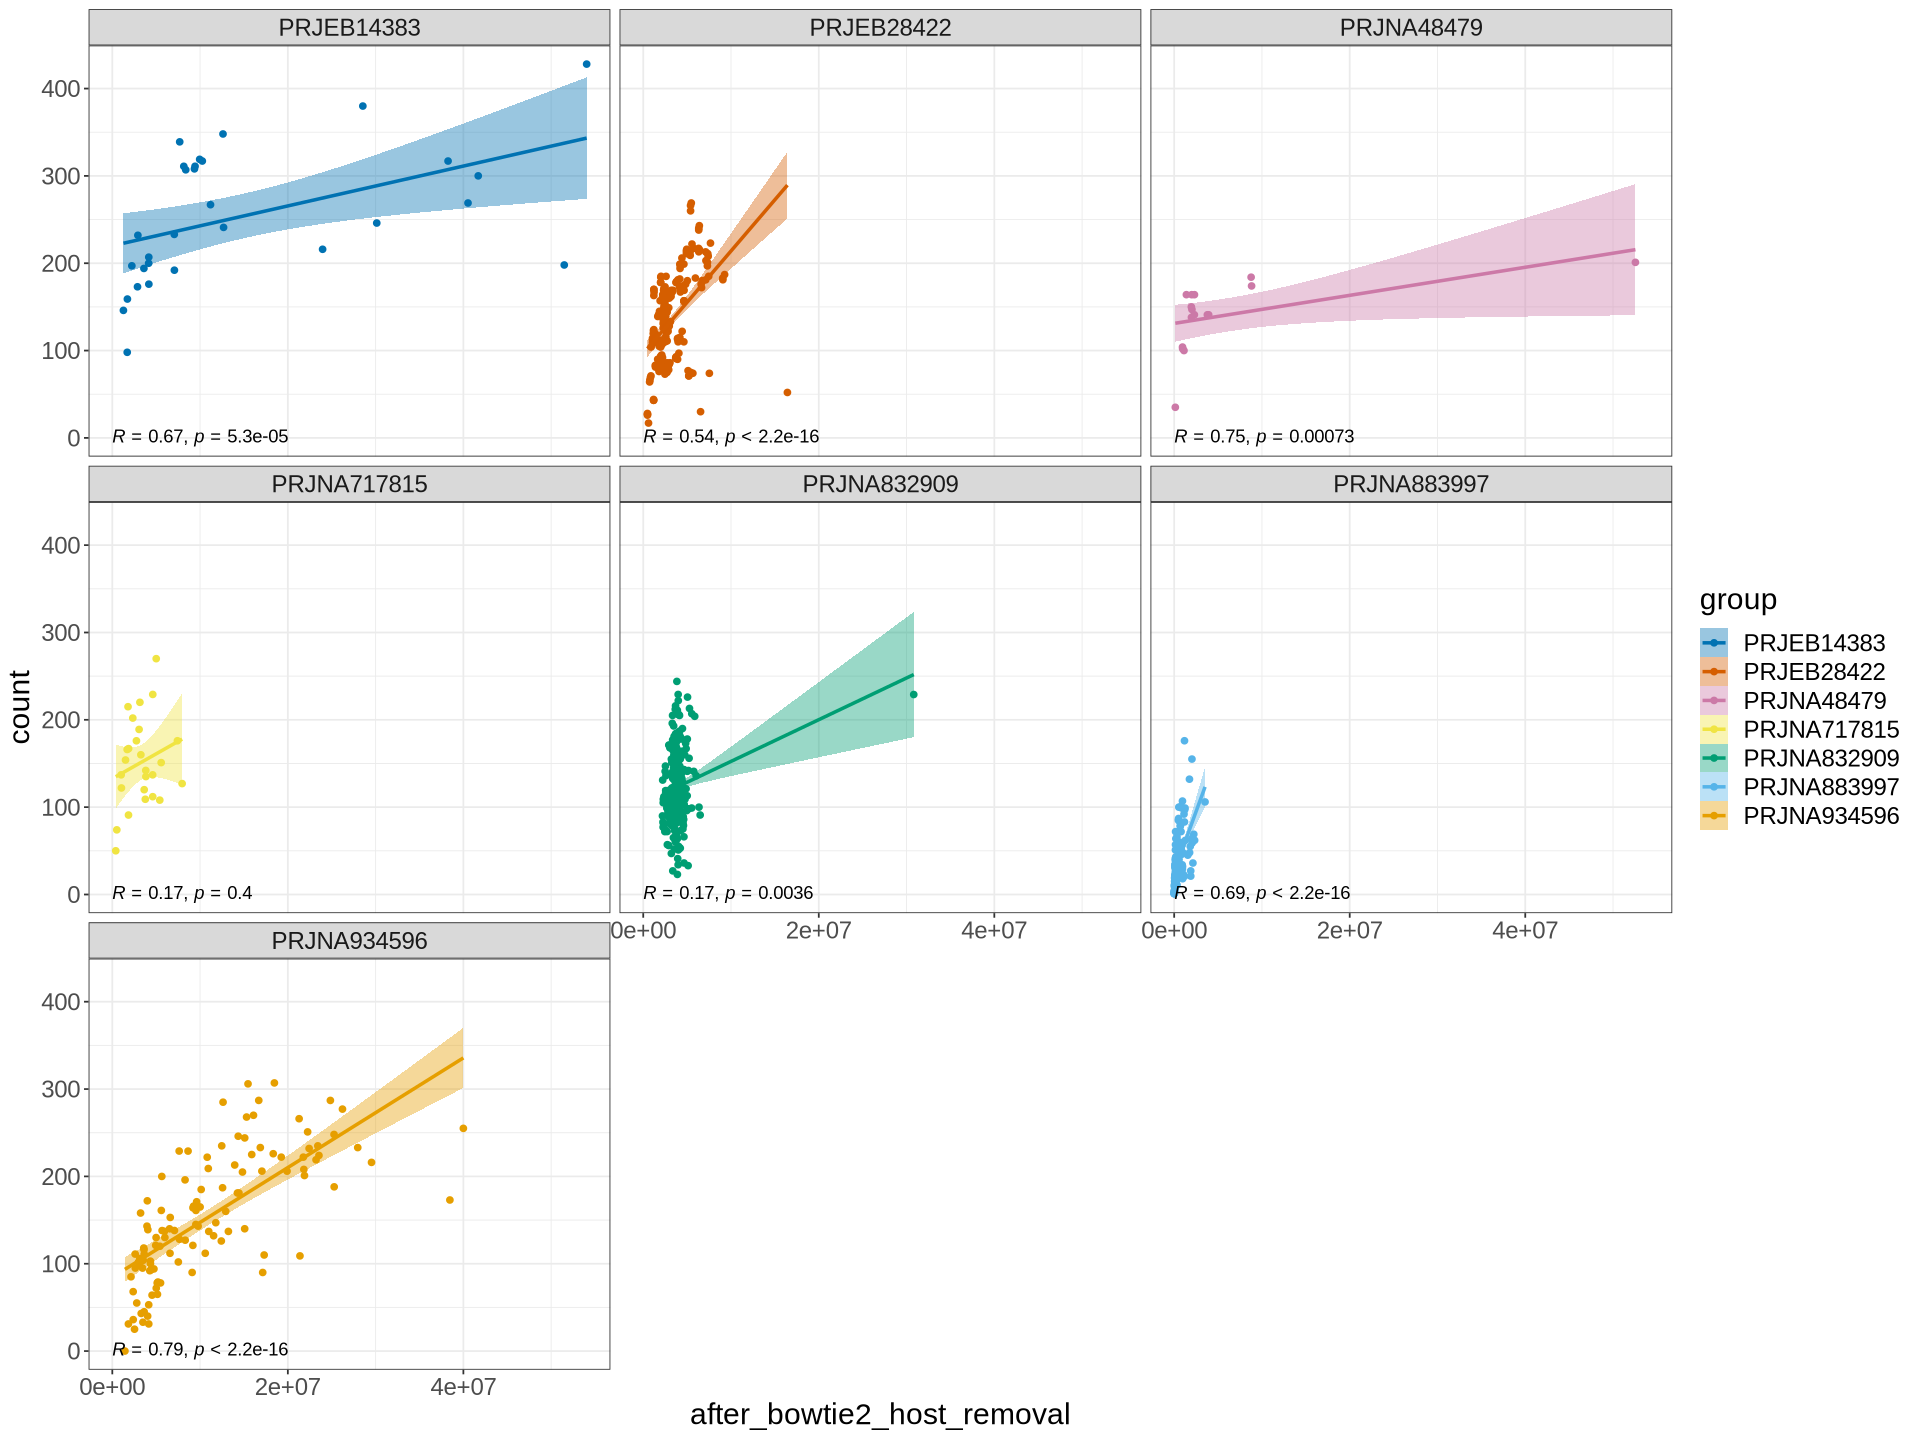

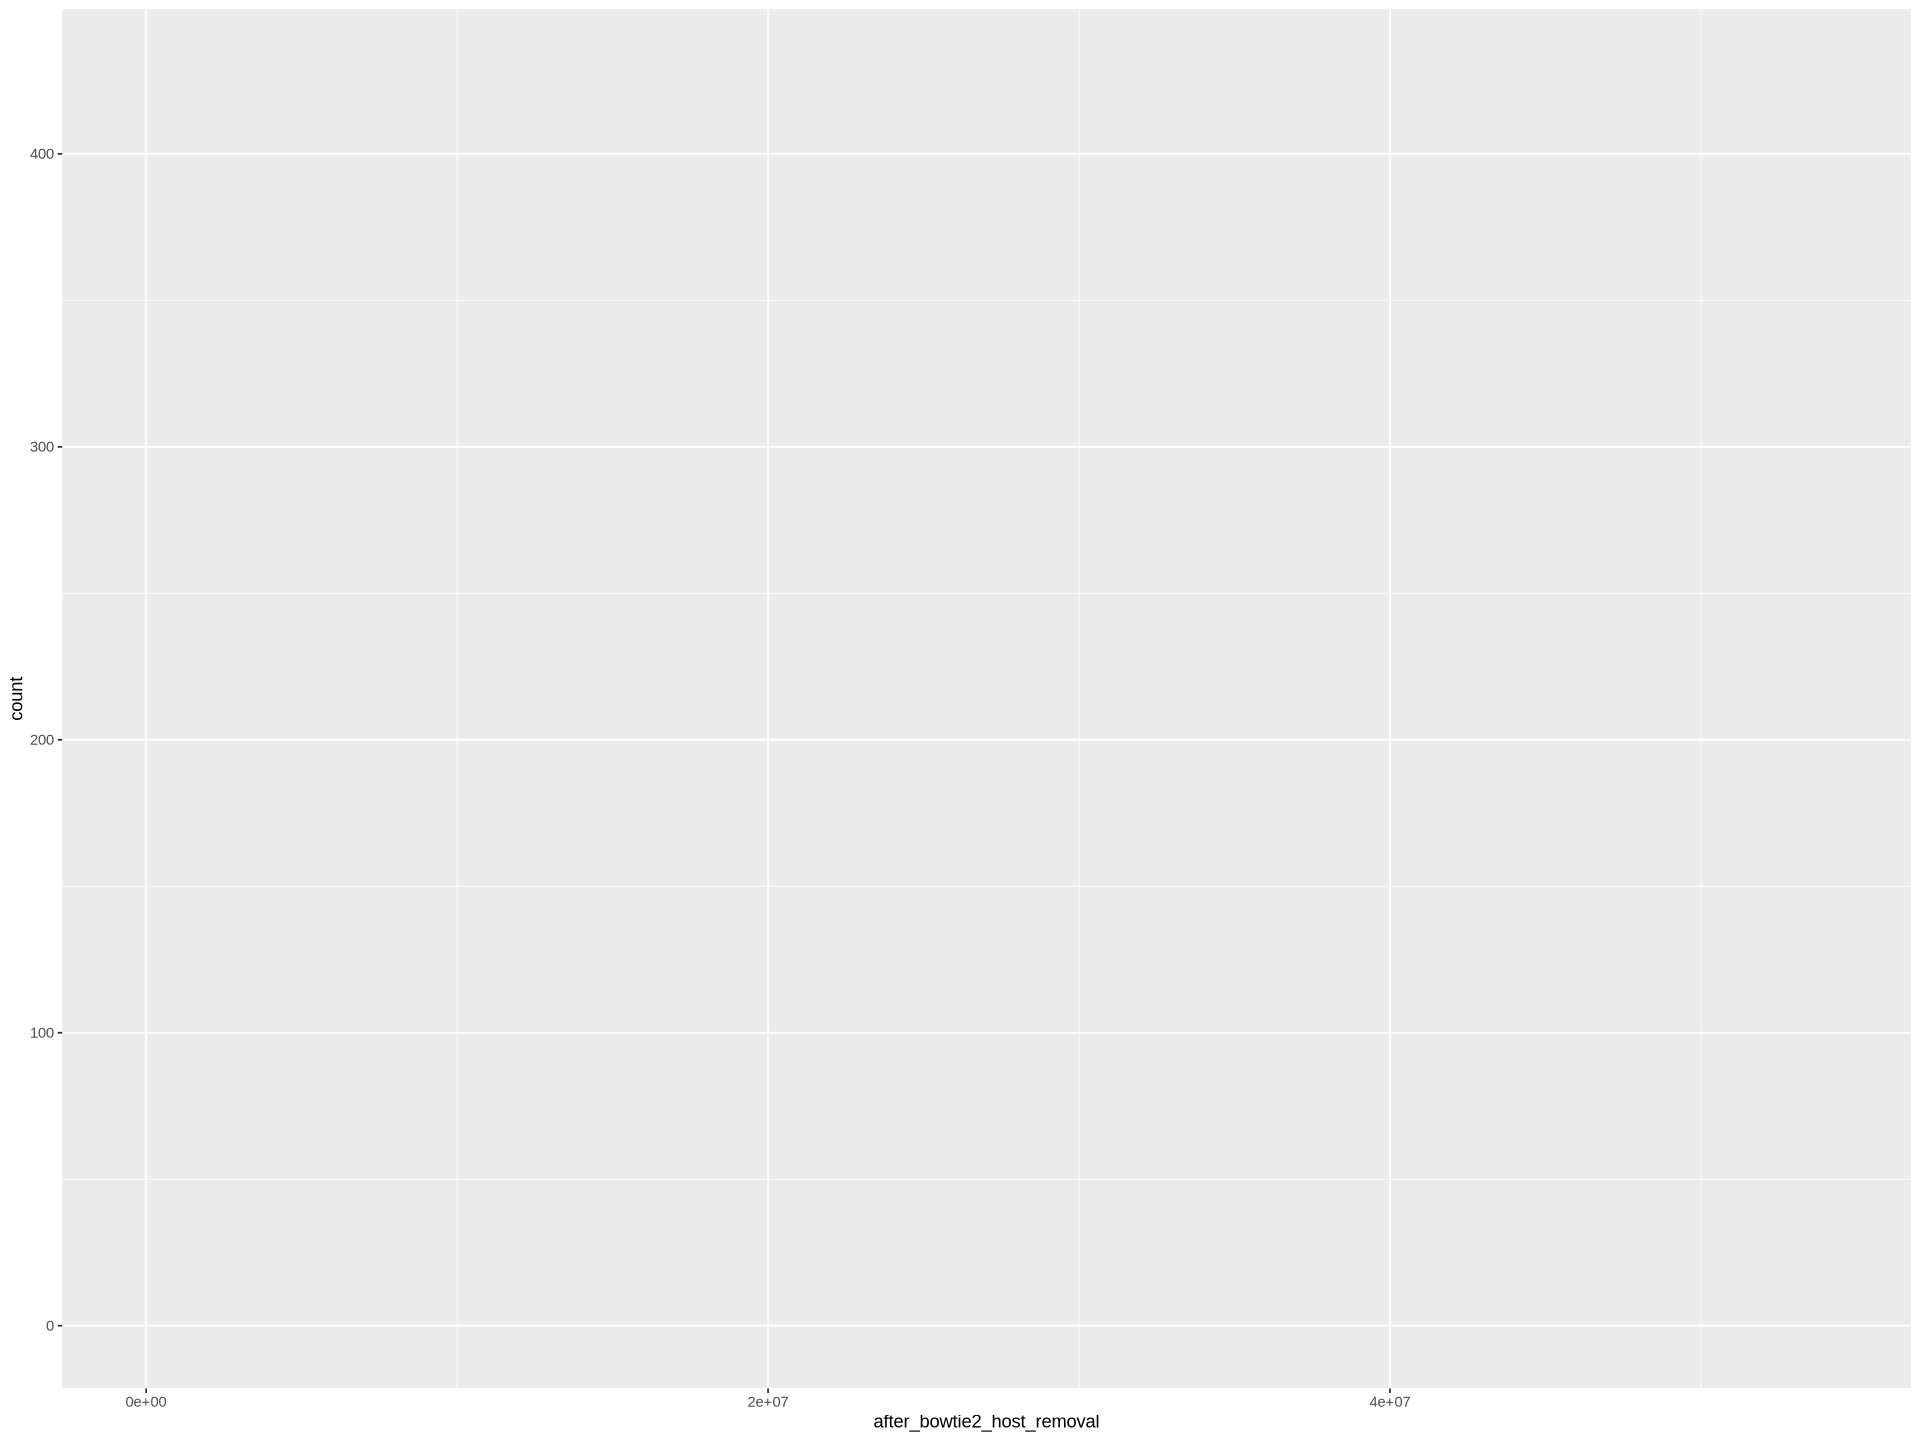

In [114]:
b3 + geom_point(position = position_jitter(width = 0.05, height = 0.05),aes(color = group))+
  geom_smooth(aes(color = group, fill = group), 
              method = "lm", fullrange = FALSE) +
stat_cor(method = "spearman", 
           label.x = 0, label.y = 0) + 
  facet_wrap(~group) +
  scale_color_manual(values = c("#0072B2", "#D55E00", "#CC79A7", "#F0E442", "#009E73", "#56B4E9", "#E69F00")) +
  scale_fill_manual(values = c("#0072B2", "#D55E00", "#CC79A7", "#F0E442", "#009E73", "#56B4E9" , "#E69F00")) +
  theme_bw()+ 
theme(text = element_text(size = 18))



In [115]:
plot <- b3 + geom_point(position = position_jitter(width = 0.4, height = 0.4),aes(color = group))+
  geom_smooth(aes(color = group, fill = group), 
              method = "lm", fullrange = TRUE) +
stat_cor(method = "spearman", 
           label.x = 0, label.y = 0) + 
  facet_wrap(~group) +
  scale_color_manual(values = c("#0072B2", "#D55E00", "#CC79A7", "#F0E442", "#009E73", "#56B4E9", "#E69F00")) +
  scale_fill_manual(values = c("#0072B2", "#D55E00", "#CC79A7", "#F0E442", "#009E73", "#56B4E9", "#E69F00")) +
  theme_bw() + 
    theme(text = element_text(size = 18))
options(repr.plot.width=18)

`geom_smooth()` using formula = 'y ~ x'


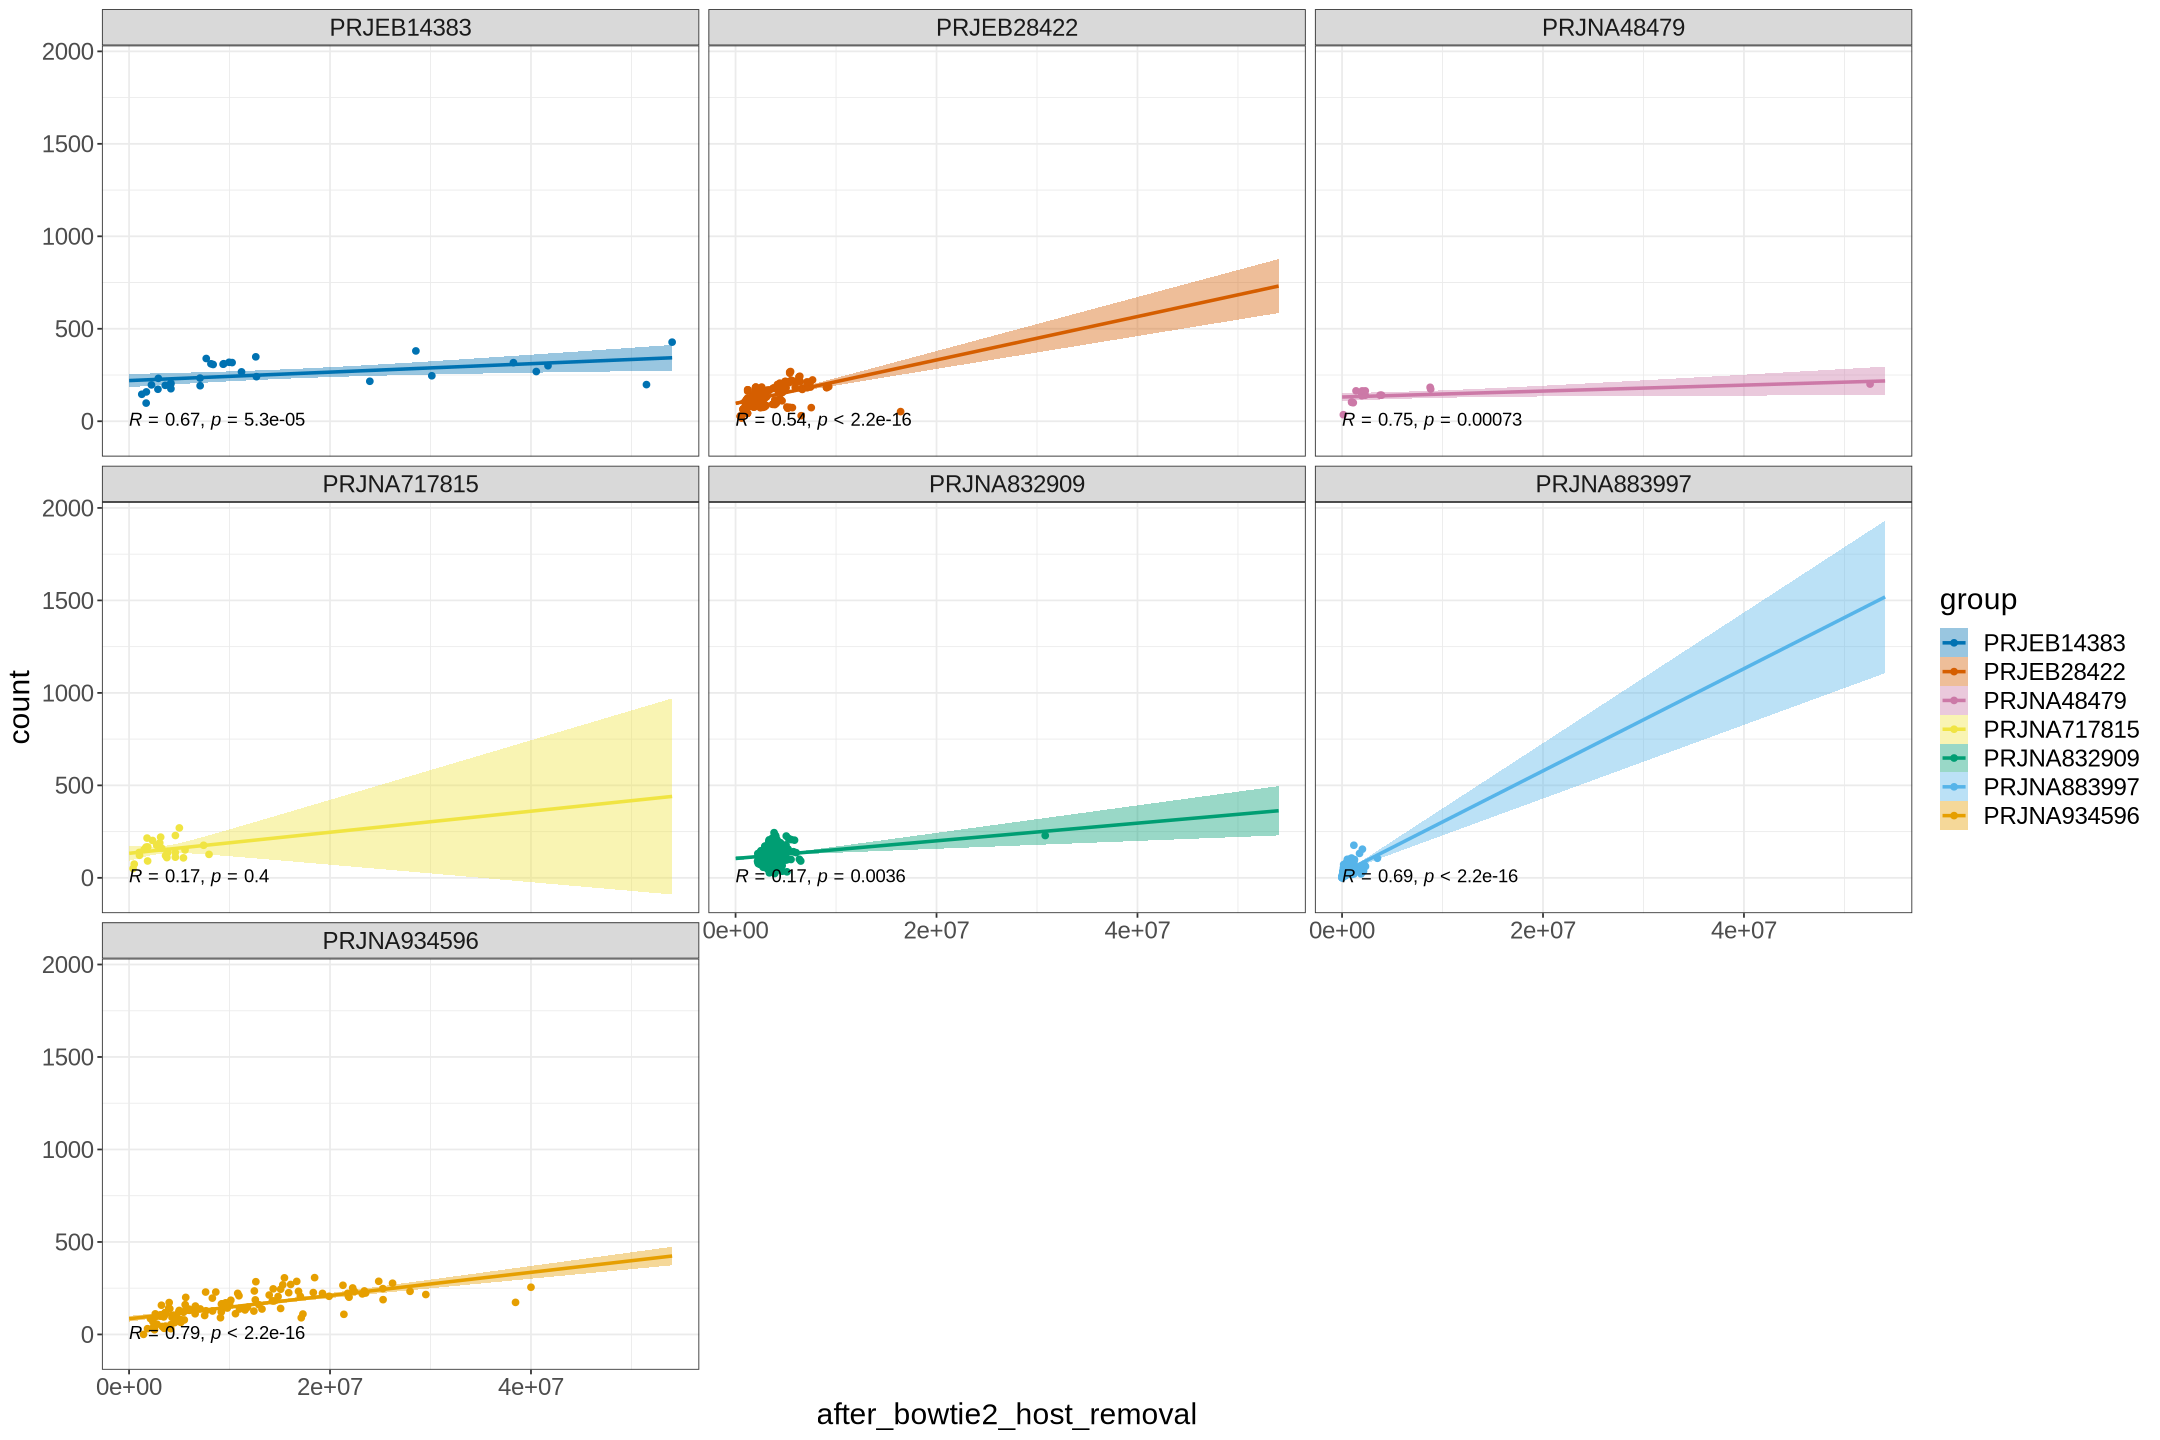

In [116]:
plot

## grouping the number of reads in total for all dataset

In [5]:
setwd('/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/meta_txt')


In [6]:
merged <- read.table( file = "merged_read_richness_814_7bio.txt", header = TRUE, sep = "\t")
dim(merged)
head(merged)

[1] 814   8

SAMPLE_ID  count Zeros group      duplication before_fastp after_fastp
1 ERR1474564 233   529   PRJEB14383 0.00562895   7118199      7074239   
2 ERR1474565 317   445   PRJEB14383 0.00196505  12261800     10301760   
3 ERR1474566 348   414   PRJEB14383 0.00466686  12642324     12627010   
4 ERR1474567 339   423   PRJEB14383 0.00154929   7732579      7698204   
5 ERR1474568 300   462   PRJEB14383 0.00711808  41891239     41722328   
6 ERR1474569 311   451   PRJEB14383 0.00144597   8379176      8225009   
  after_bowtie2_host_removal
1  7062514                  
2 10253957                  
3 12612072                  
4  7680057                  
5 41692821                  
6  8145665

In [119]:
merged <- merged[,-6]

In [120]:
merged <- merged[,-6]

In [121]:
head(merged)

SAMPLE_ID  count Zeros group      duplication after_bowtie2_host_removal
1 ERR1474564 233   529   PRJEB14383 0.00562895   7062514                  
2 ERR1474565 317   445   PRJEB14383 0.00196505  10253957                  
3 ERR1474566 348   414   PRJEB14383 0.00466686  12612072                  
4 ERR1474567 339   423   PRJEB14383 0.00154929   7680057                  
5 ERR1474568 300   462   PRJEB14383 0.00711808  41692821                  
6 ERR1474569 311   451   PRJEB14383 0.00144597   8145665

In [122]:
colnames(merged)[6] <- "reads"

In [123]:
head(merged)

SAMPLE_ID  count Zeros group      duplication reads   
1 ERR1474564 233   529   PRJEB14383 0.00562895   7062514
2 ERR1474565 317   445   PRJEB14383 0.00196505  10253957
3 ERR1474566 348   414   PRJEB14383 0.00466686  12612072
4 ERR1474567 339   423   PRJEB14383 0.00154929   7680057
5 ERR1474568 300   462   PRJEB14383 0.00711808  41692821
6 ERR1474569 311   451   PRJEB14383 0.00144597   8145665

In [124]:
merged$read_group <- ifelse(merged$reads <= 1000000, "g1",
            ifelse(merged$reads > 1000000 & merged$reads <= 2000000, "g2",
            ifelse(merged$reads > 2000000 & merged$reads <= 5000000, "g3",
            ifelse(merged$reads > 5000000 & merged$reads <= 10000000, "g4",
            ifelse(merged$reads > 10000000 & merged$reads <= 20000000, "g5",
            "g6")))))

# Check the new column
head(merged)

SAMPLE_ID  count Zeros group      duplication reads    read_group
1 ERR1474564 233   529   PRJEB14383 0.00562895   7062514 g4        
2 ERR1474565 317   445   PRJEB14383 0.00196505  10253957 g5        
3 ERR1474566 348   414   PRJEB14383 0.00466686  12612072 g5        
4 ERR1474567 339   423   PRJEB14383 0.00154929   7680057 g4        
5 ERR1474568 300   462   PRJEB14383 0.00711808  41692821 g6        
6 ERR1474569 311   451   PRJEB14383 0.00144597   8145665 g4

In [125]:
merged <- merged %>% 
  mutate(bioproj_read_gr = group)
head(merged)

SAMPLE_ID  count Zeros group      duplication reads    read_group
1 ERR1474564 233   529   PRJEB14383 0.00562895   7062514 g4        
2 ERR1474565 317   445   PRJEB14383 0.00196505  10253957 g5        
3 ERR1474566 348   414   PRJEB14383 0.00466686  12612072 g5        
4 ERR1474567 339   423   PRJEB14383 0.00154929   7680057 g4        
5 ERR1474568 300   462   PRJEB14383 0.00711808  41692821 g6        
6 ERR1474569 311   451   PRJEB14383 0.00144597   8145665 g4        
  bioproj_read_gr
1 PRJEB14383     
2 PRJEB14383     
3 PRJEB14383     
4 PRJEB14383     
5 PRJEB14383     
6 PRJEB14383

In [126]:
merged$bioproj_read_gr <- paste(merged[,"read_group"], merged$bioproj_read_gr, sep = "_")

# Check the new column
head(merged)

SAMPLE_ID  count Zeros group      duplication reads    read_group
1 ERR1474564 233   529   PRJEB14383 0.00562895   7062514 g4        
2 ERR1474565 317   445   PRJEB14383 0.00196505  10253957 g5        
3 ERR1474566 348   414   PRJEB14383 0.00466686  12612072 g5        
4 ERR1474567 339   423   PRJEB14383 0.00154929   7680057 g4        
5 ERR1474568 300   462   PRJEB14383 0.00711808  41692821 g6        
6 ERR1474569 311   451   PRJEB14383 0.00144597   8145665 g4        
  bioproj_read_gr
1 g4_PRJEB14383  
2 g5_PRJEB14383  
3 g5_PRJEB14383  
4 g4_PRJEB14383  
5 g6_PRJEB14383  
6 g4_PRJEB14383

In [127]:
counts <- table(merged$read_group)

# Print the counts
print(counts)


 g1  g2  g3  g4  g5  g6 
113  84 450 100  39  28 


In [128]:
counts_gr <- table(merged$bioproj_read_gr)

# Print the counts
print(counts_gr)


 g1_PRJEB28422  g1_PRJNA48479 g1_PRJNA717815 g1_PRJNA883997  g2_PRJEB14383 
             9              3              2             99              3 
 g2_PRJEB28422  g2_PRJNA48479 g2_PRJNA717815 g2_PRJNA883997 g2_PRJNA934596 
            54              4              7             14              2 
 g3_PRJEB14383  g3_PRJEB28422  g3_PRJNA48479 g3_PRJNA717815 g3_PRJNA832909 
             7            120              6             12            264 
g3_PRJNA883997 g3_PRJNA934596  g4_PRJEB14383  g4_PRJEB28422  g4_PRJNA48479 
             7             34              8             38              2 
g4_PRJNA717815 g4_PRJNA832909 g4_PRJNA934596  g5_PRJEB14383  g5_PRJEB28422 
             5             17             30              4              1 
g5_PRJNA934596  g6_PRJEB14383  g6_PRJNA48479 g6_PRJNA832909 g6_PRJNA934596 
            34              8              1              1             18 


## pattern for richness and numbers (cut off:  > 2 million reads , counts of species >= 50)

In [129]:
getwd()

[1] "/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/meta_txt"

In [130]:
merged <- read.table( file = "merged_read_richness_814_7bio.txt", header = TRUE, sep = "\t")
dim(merged)
head(merged)

[1] 814   8

SAMPLE_ID  count Zeros group      duplication before_fastp after_fastp
1 ERR1474564 233   529   PRJEB14383 0.00562895   7118199      7074239   
2 ERR1474565 317   445   PRJEB14383 0.00196505  12261800     10301760   
3 ERR1474566 348   414   PRJEB14383 0.00466686  12642324     12627010   
4 ERR1474567 339   423   PRJEB14383 0.00154929   7732579      7698204   
5 ERR1474568 300   462   PRJEB14383 0.00711808  41891239     41722328   
6 ERR1474569 311   451   PRJEB14383 0.00144597   8379176      8225009   
  after_bowtie2_host_removal
1  7062514                  
2 10253957                  
3 12612072                  
4  7680057                  
5 41692821                  
6  8145665

In [131]:
cut_off <- merged[merged$after_bowtie2_host_removal > 2000000, ]  # excluding 197 samples less than 2mil reads
head(cut_off)
dim(cut_off)

SAMPLE_ID  count Zeros group      duplication before_fastp after_fastp
1 ERR1474564 233   529   PRJEB14383 0.00562895   7118199      7074239   
2 ERR1474565 317   445   PRJEB14383 0.00196505  12261800     10301760   
3 ERR1474566 348   414   PRJEB14383 0.00466686  12642324     12627010   
4 ERR1474567 339   423   PRJEB14383 0.00154929   7732579      7698204   
5 ERR1474568 300   462   PRJEB14383 0.00711808  41891239     41722328   
6 ERR1474569 311   451   PRJEB14383 0.00144597   8379176      8225009   
  after_bowtie2_host_removal
1  7062514                  
2 10253957                  
3 12612072                  
4  7680057                  
5 41692821                  
6  8145665

[1] 617   8

In [132]:
dim(cut_off)

[1] 617   8

In [139]:
cut_off_t <- cut_off[cut_off$count >= 50 , ]
dim(cut_off_t)
head(cut_off_t)

[1] 601   8

SAMPLE_ID  count Zeros group      duplication before_fastp after_fastp
1 ERR1474564 233   529   PRJEB14383 0.00562895   7118199      7074239   
2 ERR1474565 317   445   PRJEB14383 0.00196505  12261800     10301760   
3 ERR1474566 348   414   PRJEB14383 0.00466686  12642324     12627010   
4 ERR1474567 339   423   PRJEB14383 0.00154929   7732579      7698204   
5 ERR1474568 300   462   PRJEB14383 0.00711808  41891239     41722328   
6 ERR1474569 311   451   PRJEB14383 0.00144597   8379176      8225009   
  after_bowtie2_host_removal
1  7062514                  
2 10253957                  
3 12612072                  
4  7680057                  
5 41692821                  
6  8145665

In [138]:
#save the result of cutting off, 2 mill reads, 100 species: 
getwd()

[1] "/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/meta_txt"

In [140]:
write.table(cut_off_t, file = "cutoff_2mil_50sp_814_601.txt", sep = "\t", row.names = FALSE)

In [157]:
getwd()

[1] "/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks"

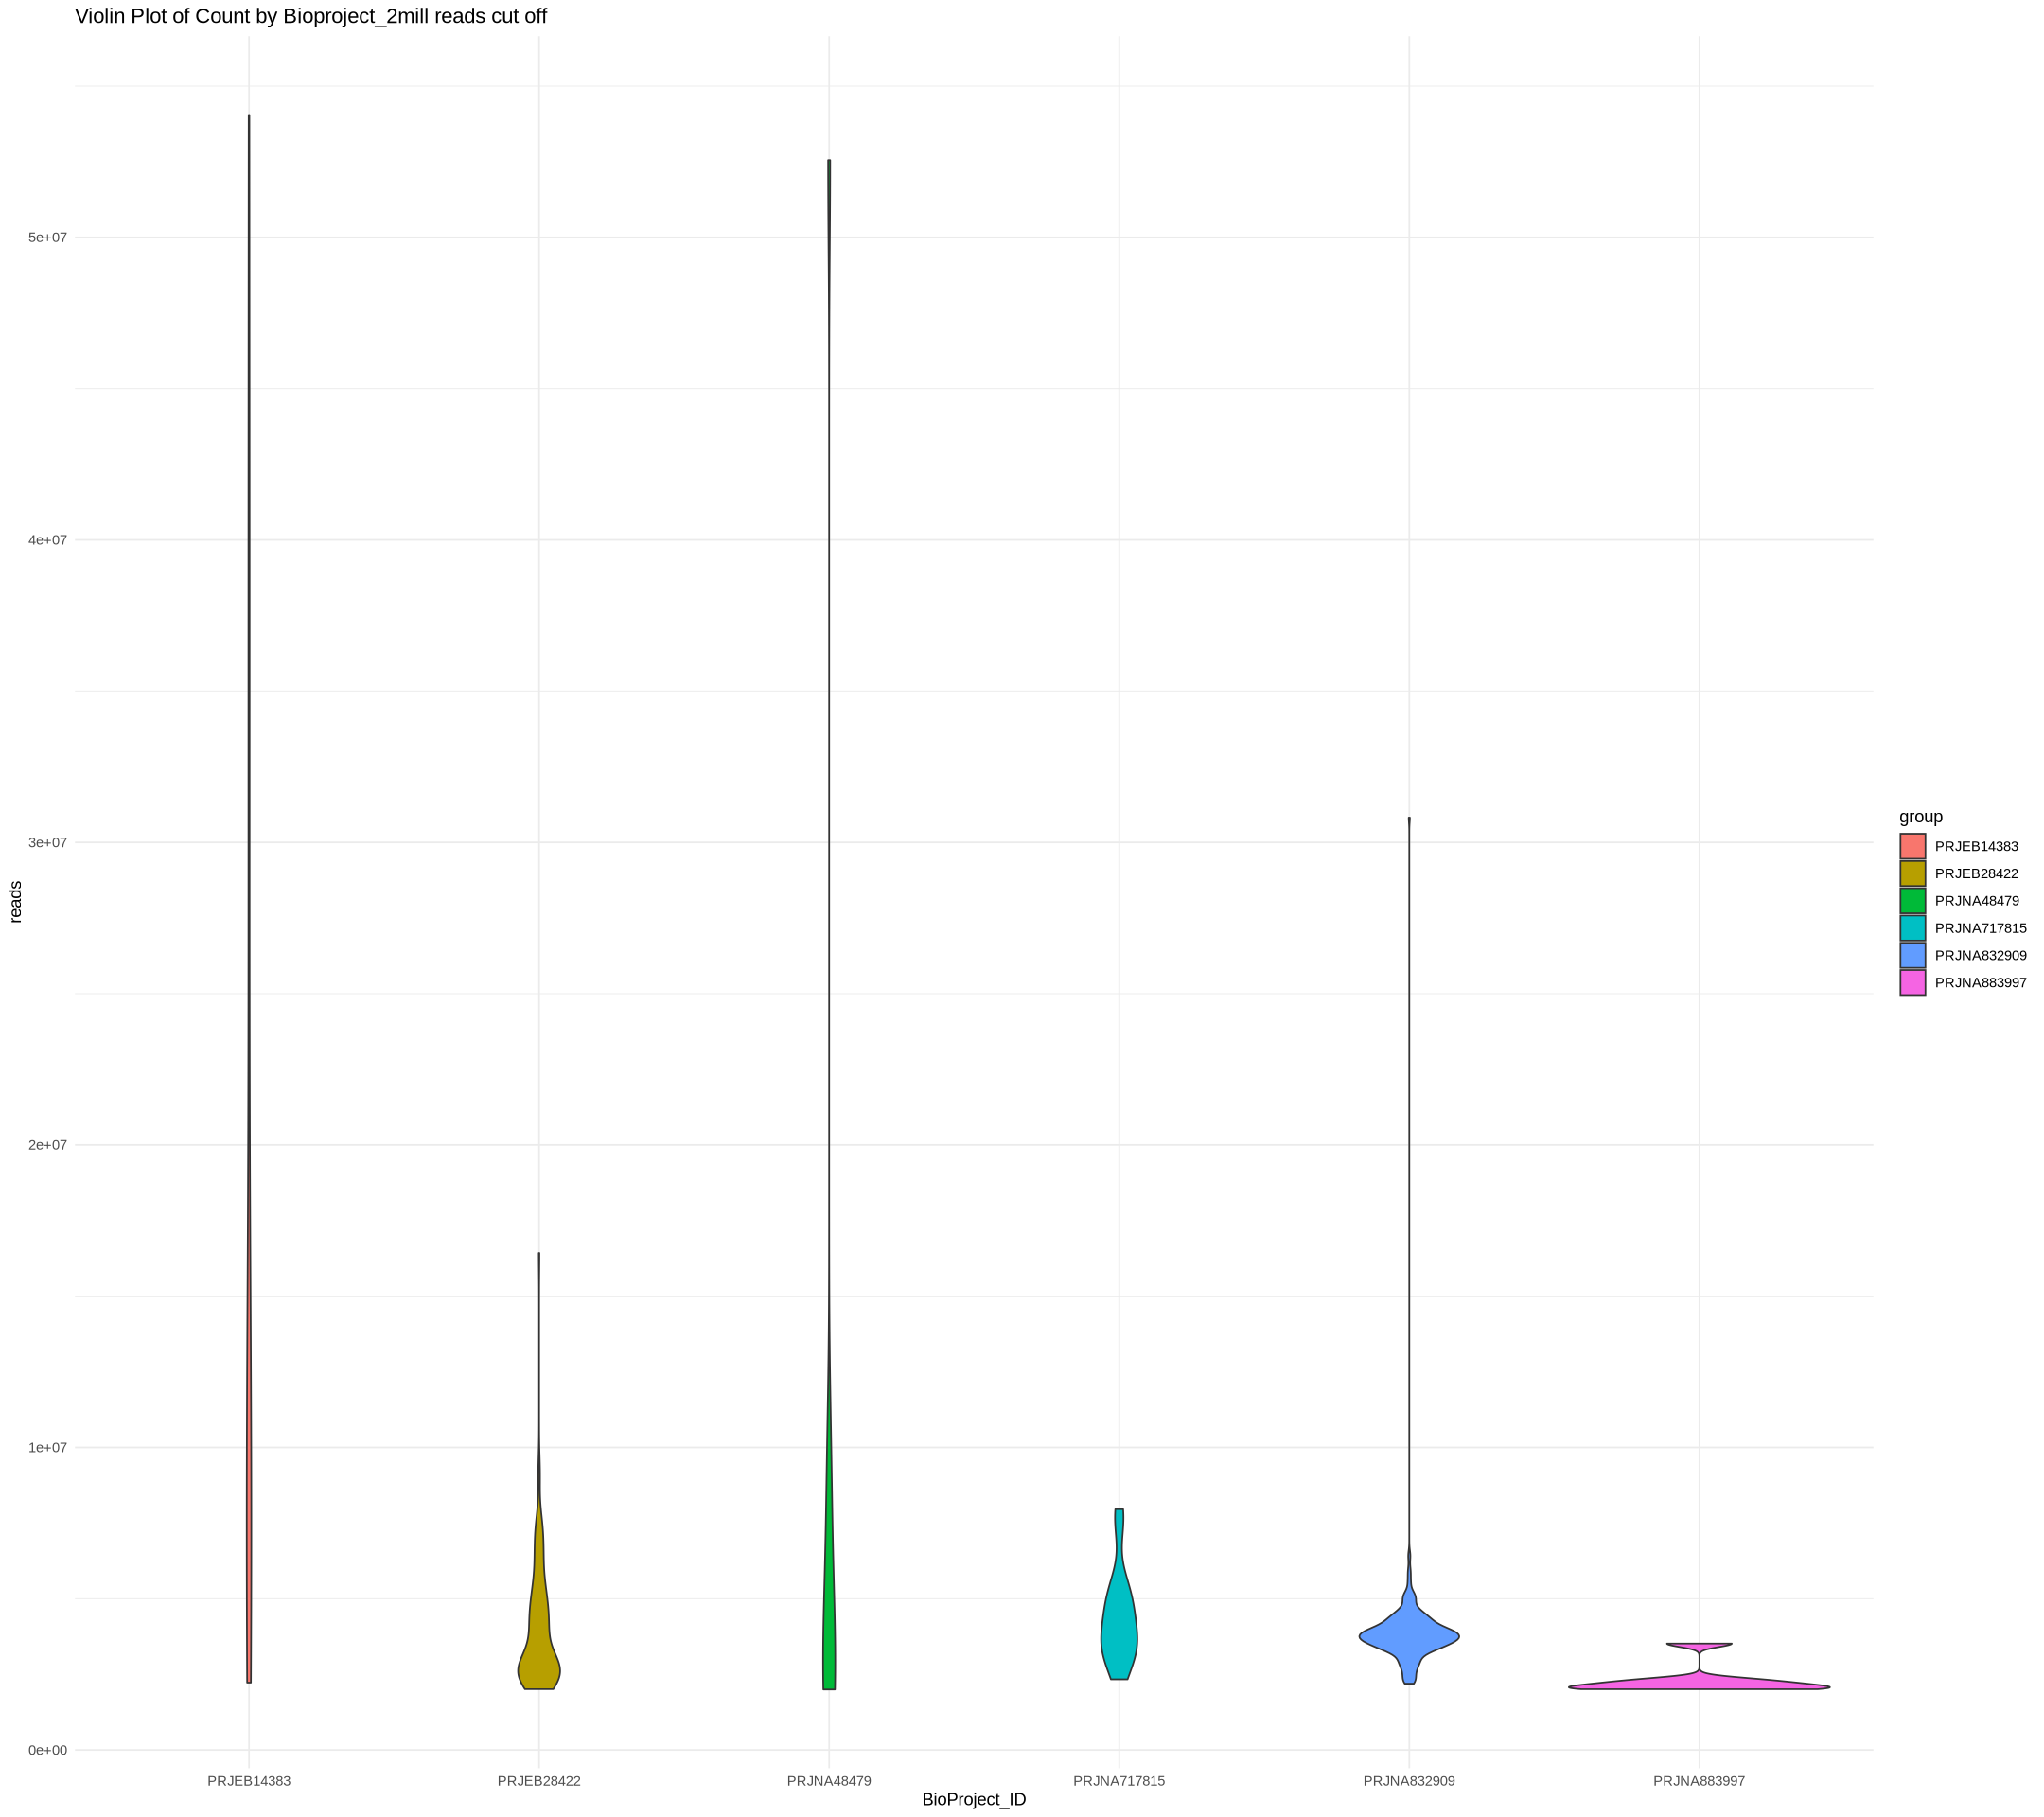

In [103]:
#library(ggplot2)
options(repr.plot.width=18 , repr.plot.height= 16)
# Create a violin plot
plot_cut_off <- ggplot(cut_off, aes(x = group, y = after_bowtie2_host_removal , fill = group)) 

plot_cut_off + geom_violin() +
  labs(title = "Violin Plot of Count by Bioproject_2mill reads cut off",
       x = "BioProject_ID",
       y = "reads") +
  theme_minimal()


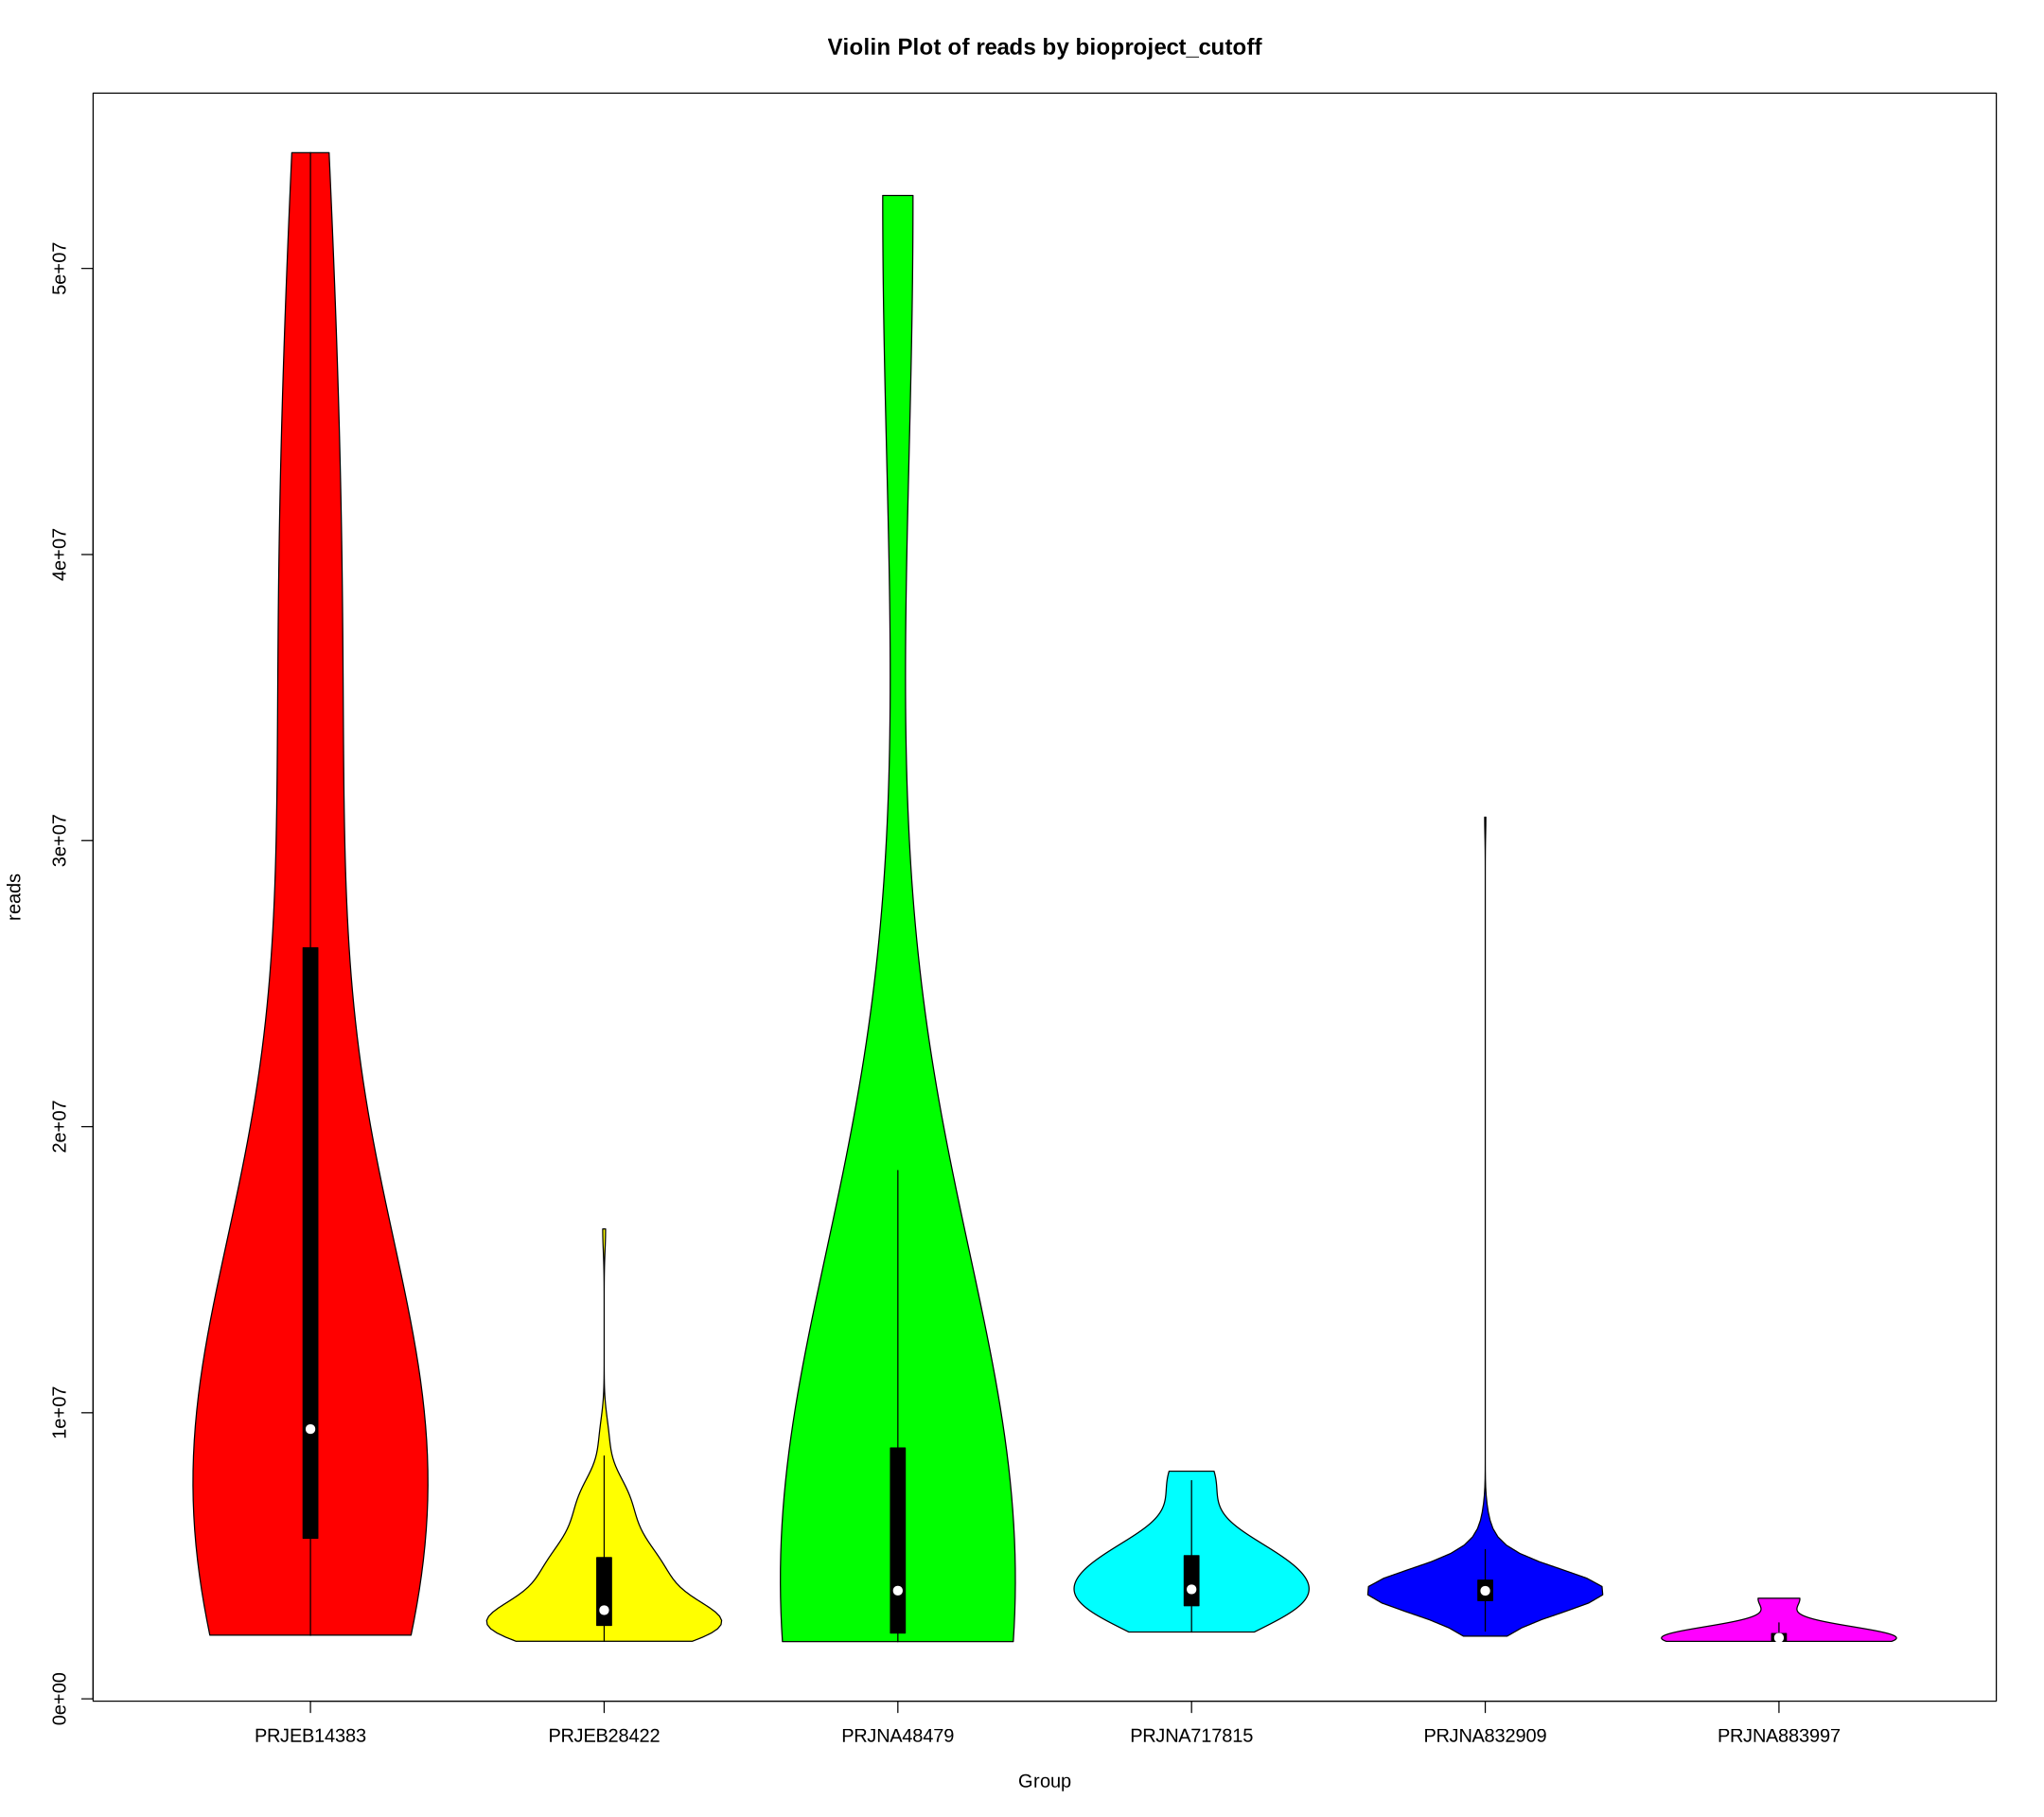

In [104]:
group_names <- unique(cut_off$group)

# Create a color palette with a different color for each group
colors <- rainbow(length(group_names))

# Create a violin plot
vioplot(cut_off$after_bowtie2_host_removal ~ cut_off$group, 
        col = colors,  # Assign colors based on group
        main = "Violin Plot of reads by bioproject_cutoff", 
        xlab = "Group", 
        ylab = "reads")

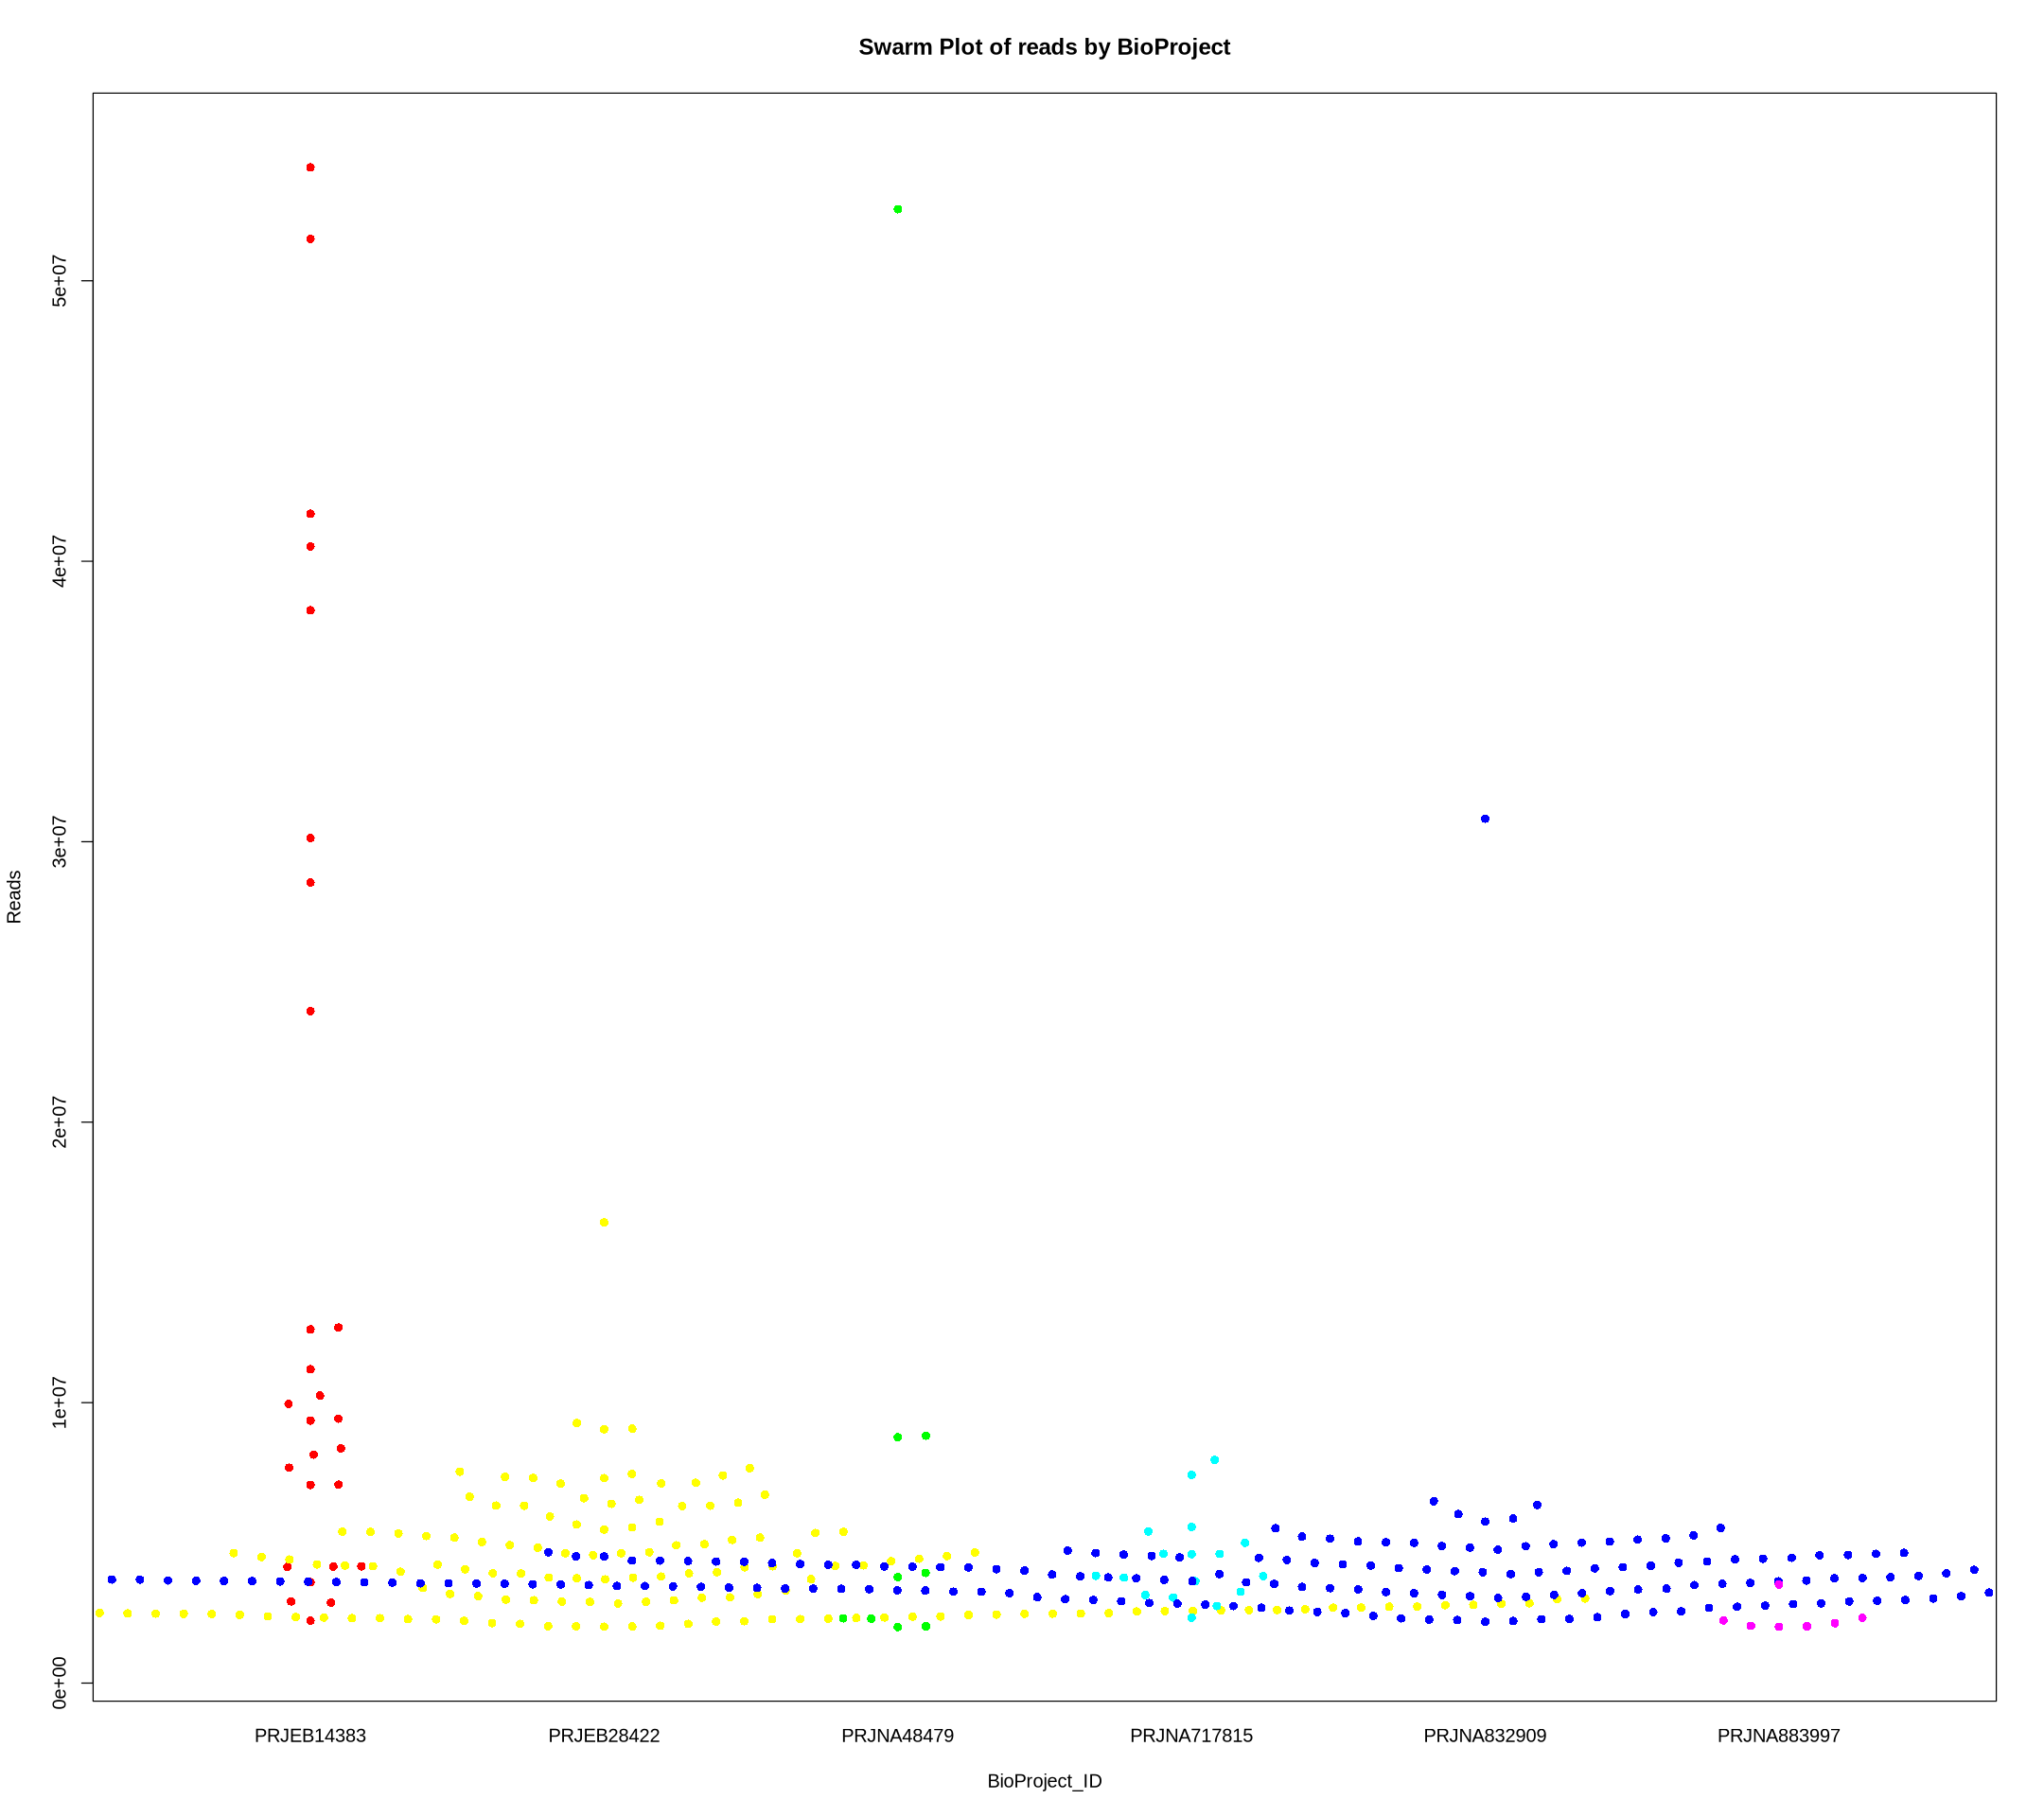

In [105]:
group_names <- unique(cut_off$group)

# Create a color palette with a different color for each group
colors <- rainbow(length(group_names))
beeswarm(after_bowtie2_host_removal ~ group, data = cut_off, pch = 16, col = colors ,
         main = "Swarm Plot of reads by BioProject",
         xlab = "BioProject_ID", ylab = "Reads")


`geom_smooth()` using formula = 'y ~ x'


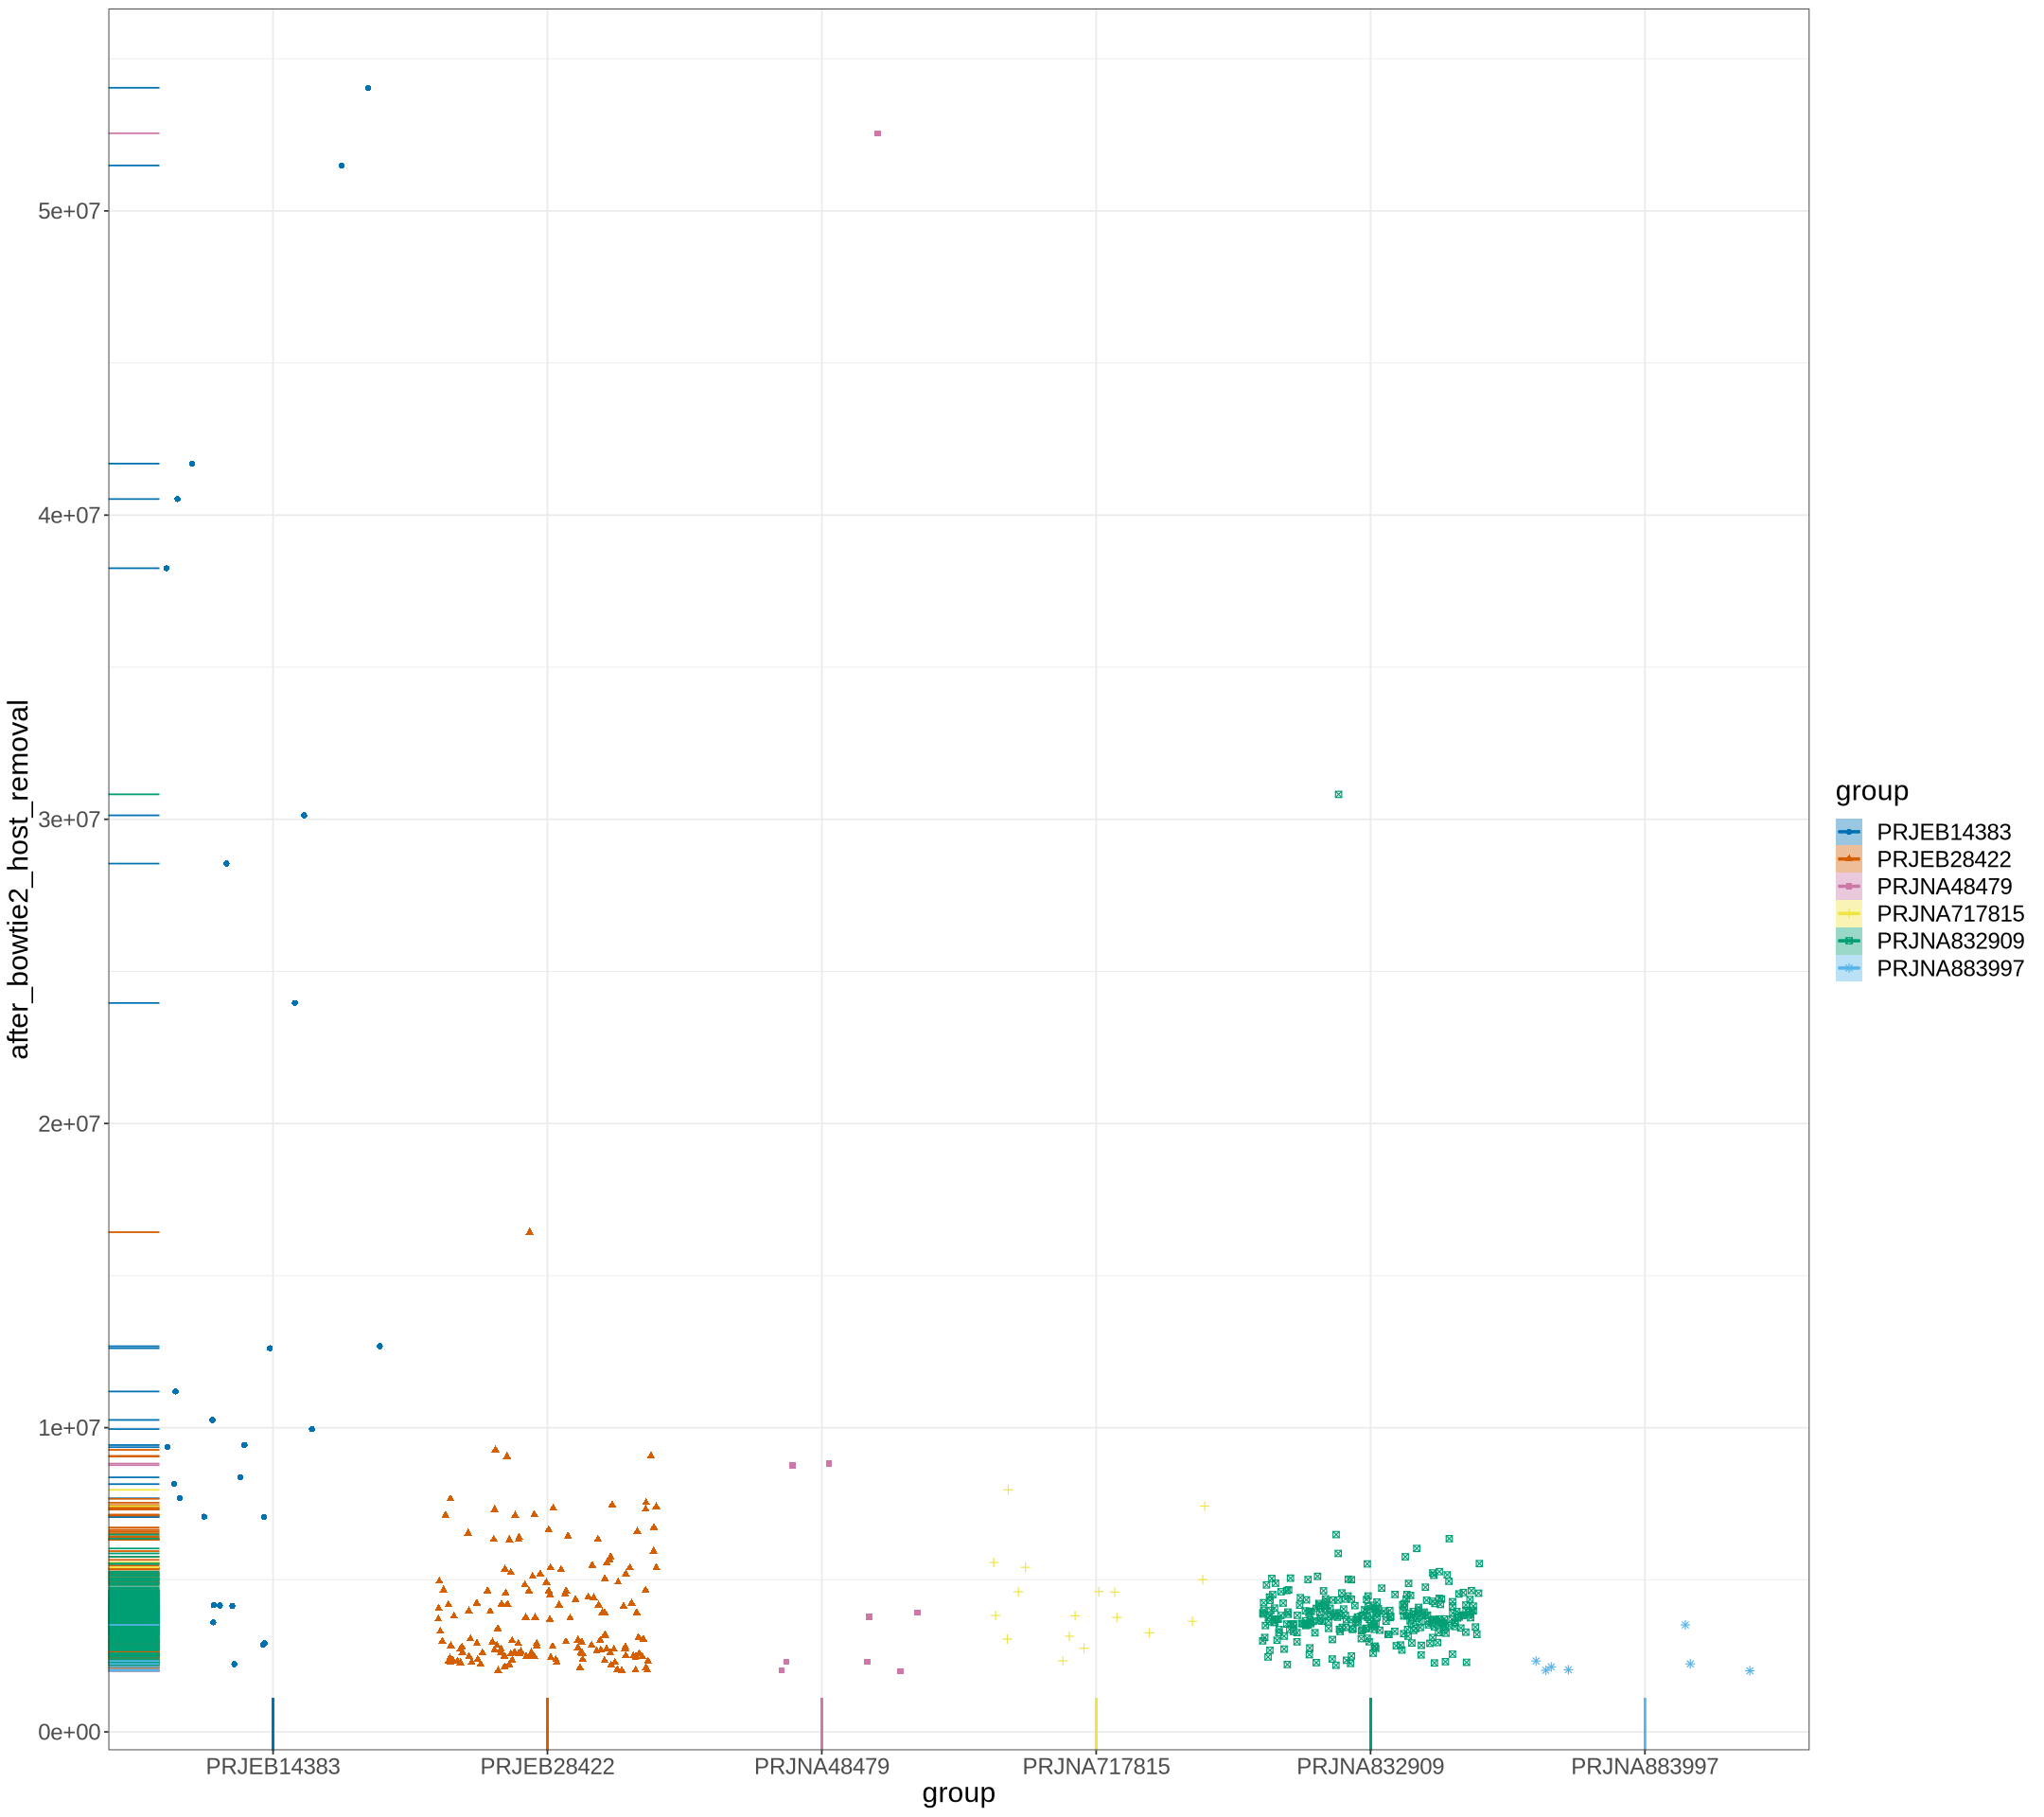

In [106]:
ggplot(cut_off, aes(x = group, y = after_bowtie2_host_removal , fill = group)) +
  geom_point(position = position_jitter(width = 0.4, height = 0.4), aes(color = group, shape = group)) +
  geom_smooth(aes(color = group, fill = group), method = "lm") +
  geom_rug(aes(color = group)) +
  scale_color_manual(values = c("#0072B2", "#D55E00", "#CC79A7", "#F0E442", "#009E73", "#56B4E9")) +
  scale_fill_manual(values = c("#0072B2", "#D55E00", "#CC79A7", "#F0E442", "#009E73", "#56B4E9")) +
  theme_bw()+ 
  theme(text = element_text(size = 18))


`geom_smooth()` using formula = 'y ~ x'


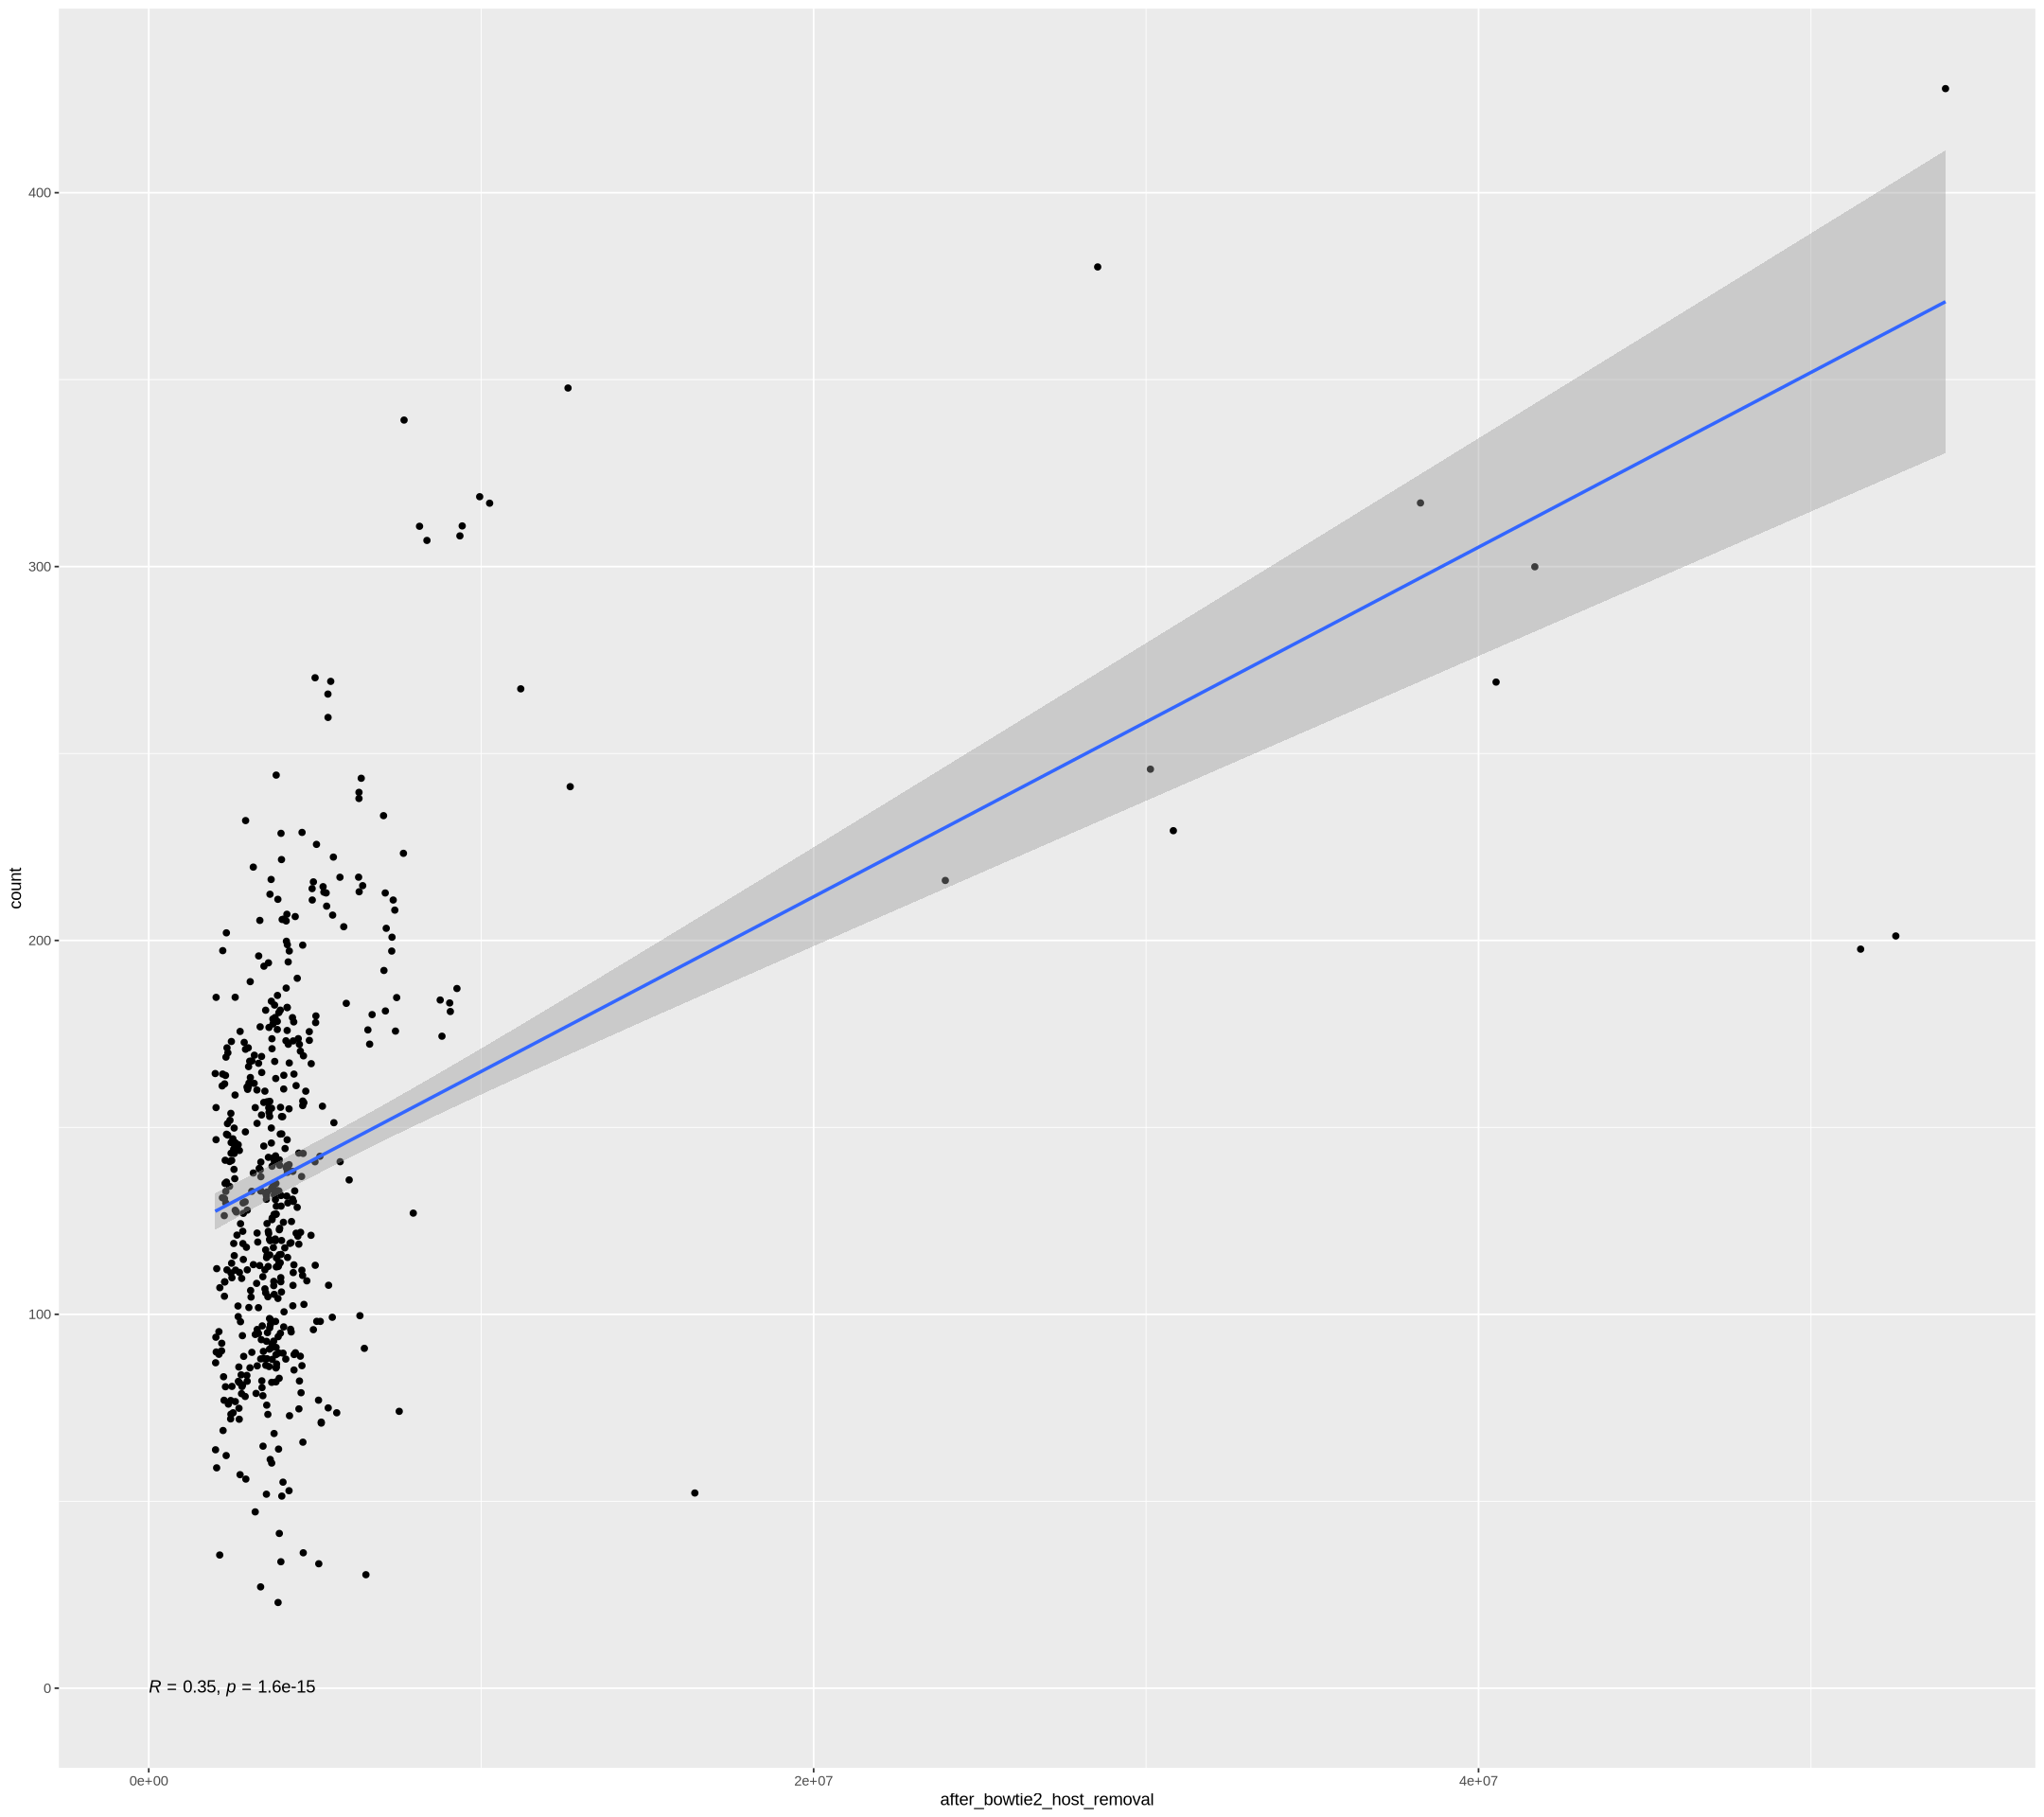

In [117]:
plot <- ggplot(cut_off, aes(y = count , x = after_bowtie2_host_removal))
# Scatter plot with regression line
plot + geom_point(position = position_jitter(width = 0.4, height = 0.4))+
  geom_smooth(method = "lm" , fullrange = FALSE) +
 stat_cor(method = "spearman", 
           label.x = 0, label.y = 0) 

`geom_smooth()` using formula = 'y ~ x'


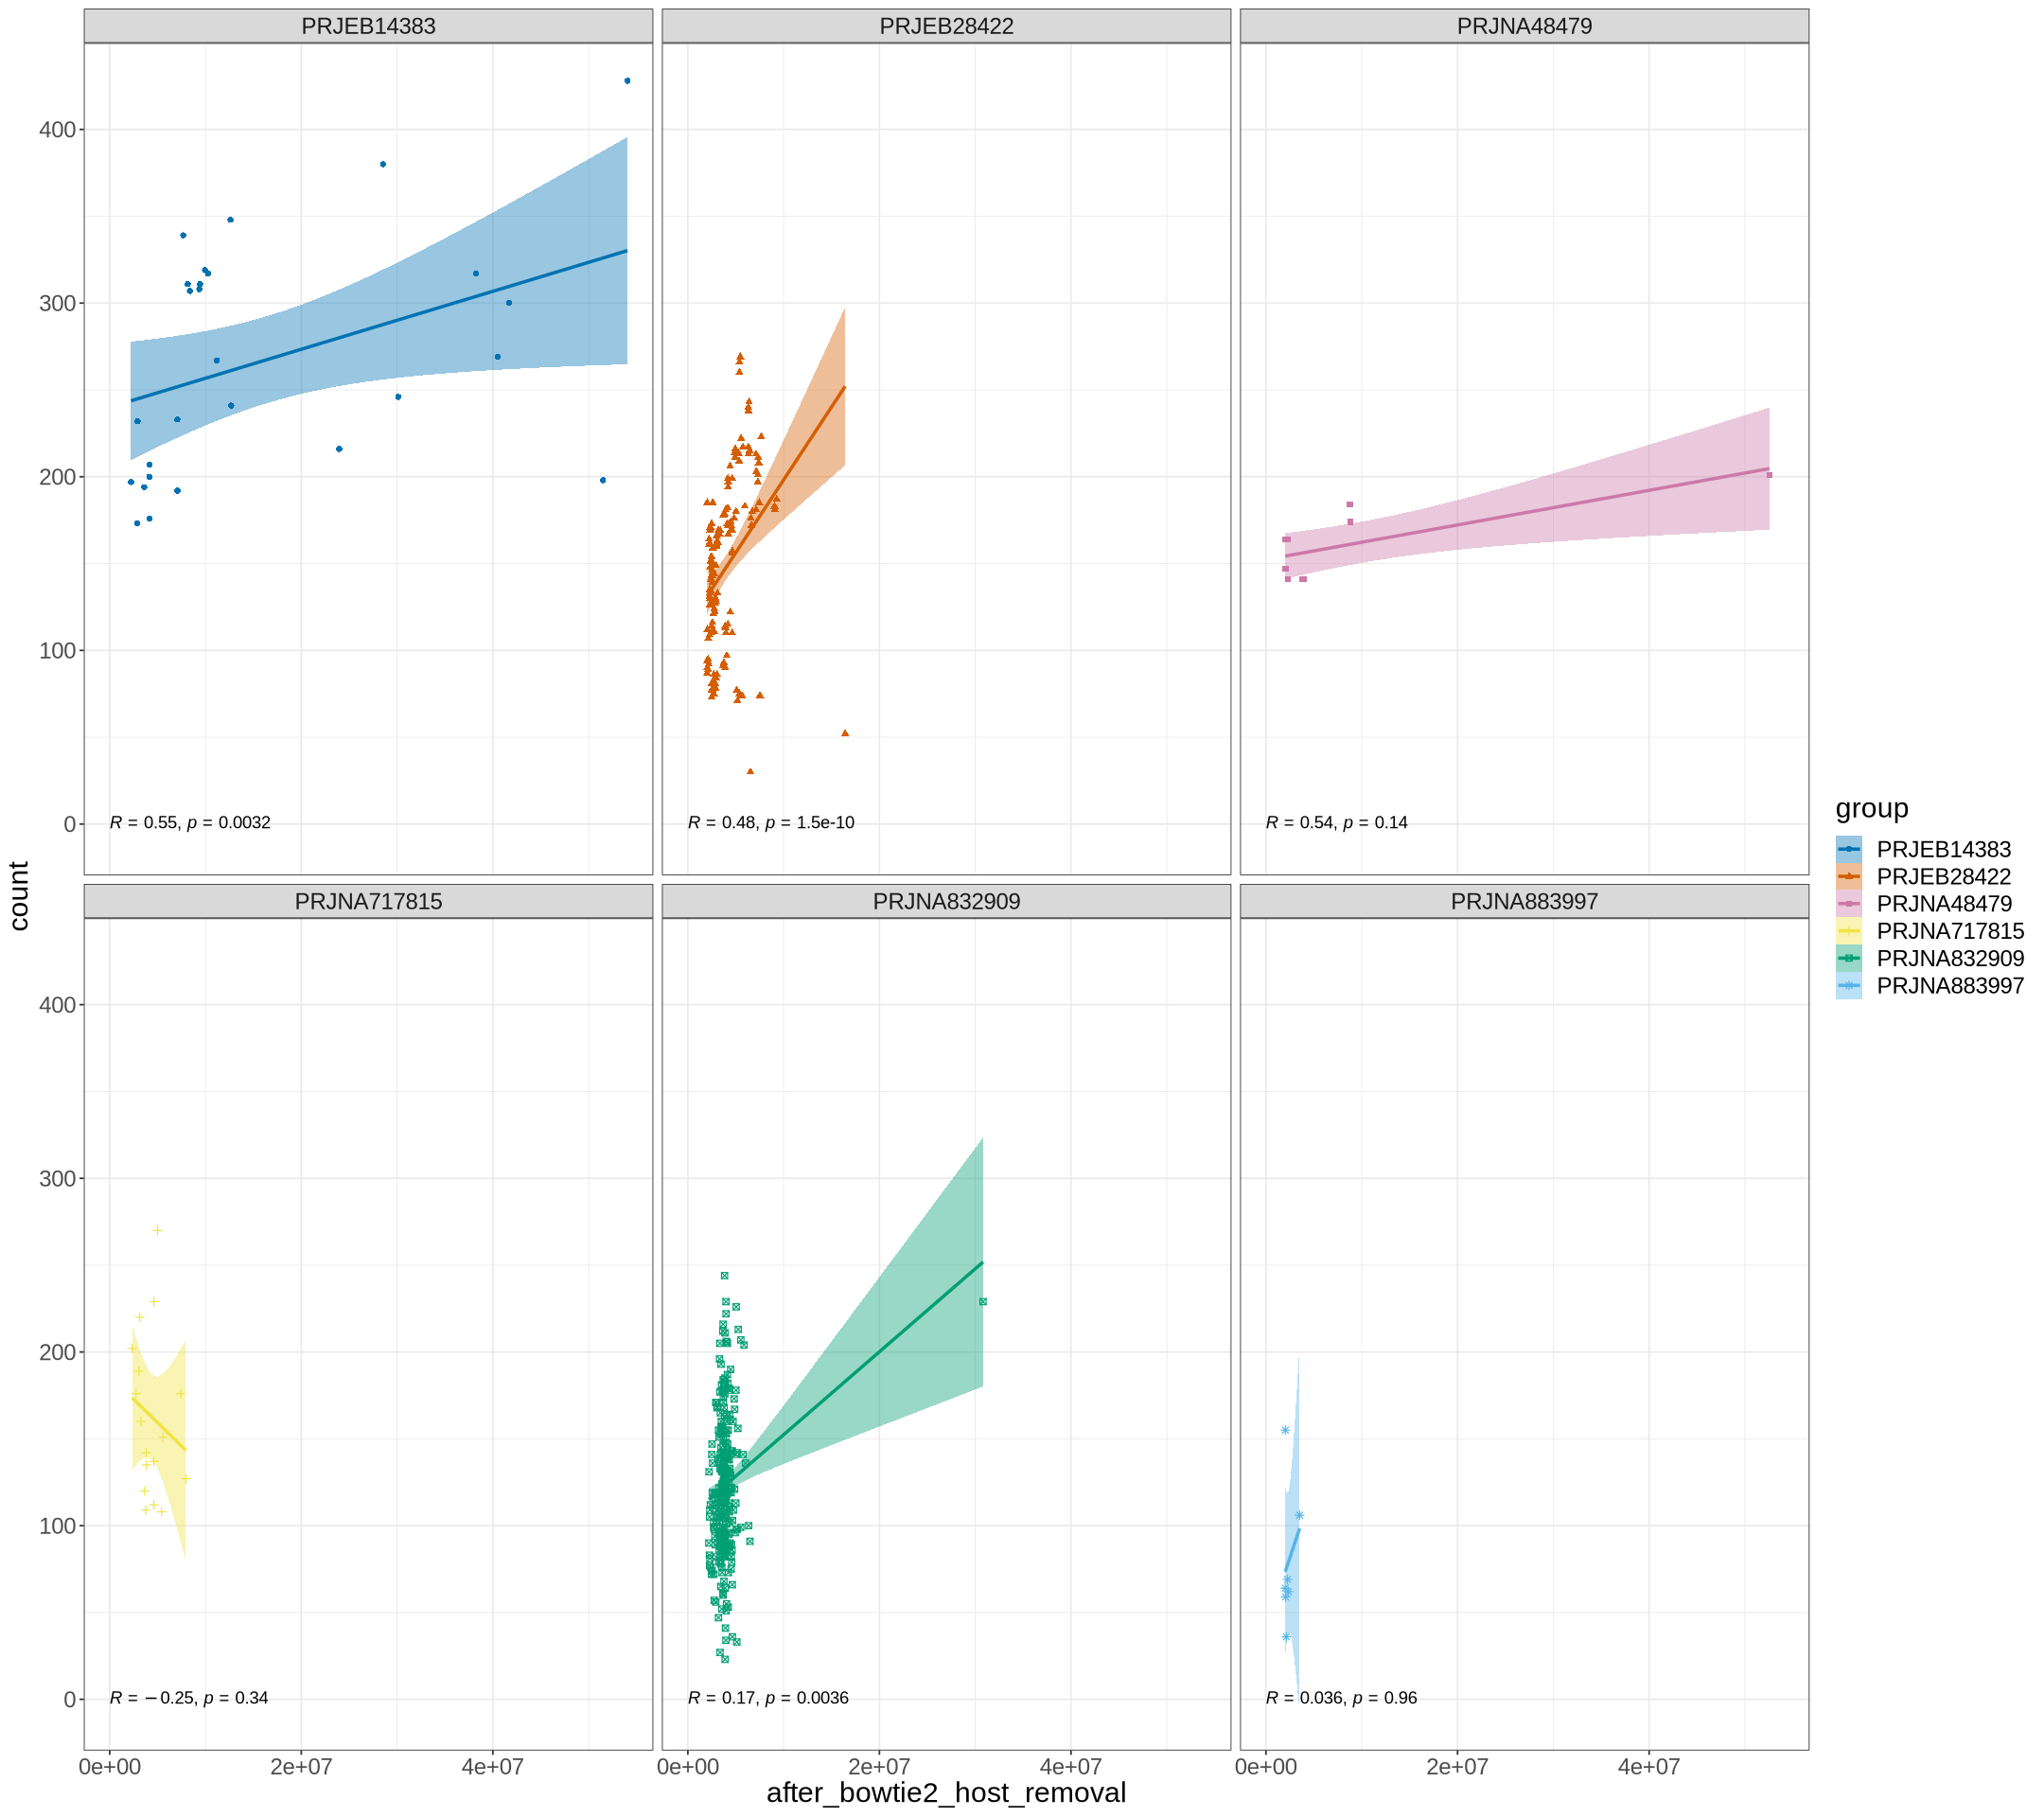

In [111]:
plot + geom_point(position = position_jitter(width = 0.005, height = 0.005),aes(color = group, shape = group))+
  geom_smooth(aes(color = group, fill = group), 
              method = "lm", fullrange = FALSE) +
stat_cor(method = "spearman", 
           label.x = 0, label.y = 0) + 
  facet_wrap(~group) +
  scale_color_manual(values = c("#0072B2", "#D55E00", "#CC79A7", "#F0E442", "#009E73", "#56B4E9")) +
  scale_fill_manual(values = c("#0072B2", "#D55E00", "#CC79A7", "#F0E442", "#009E73", "#56B4E9")) +
  theme_bw()+ 
theme(text = element_text(size = 18))
options(repr.plot.width=18)

`geom_smooth()` using formula = 'y ~ x'


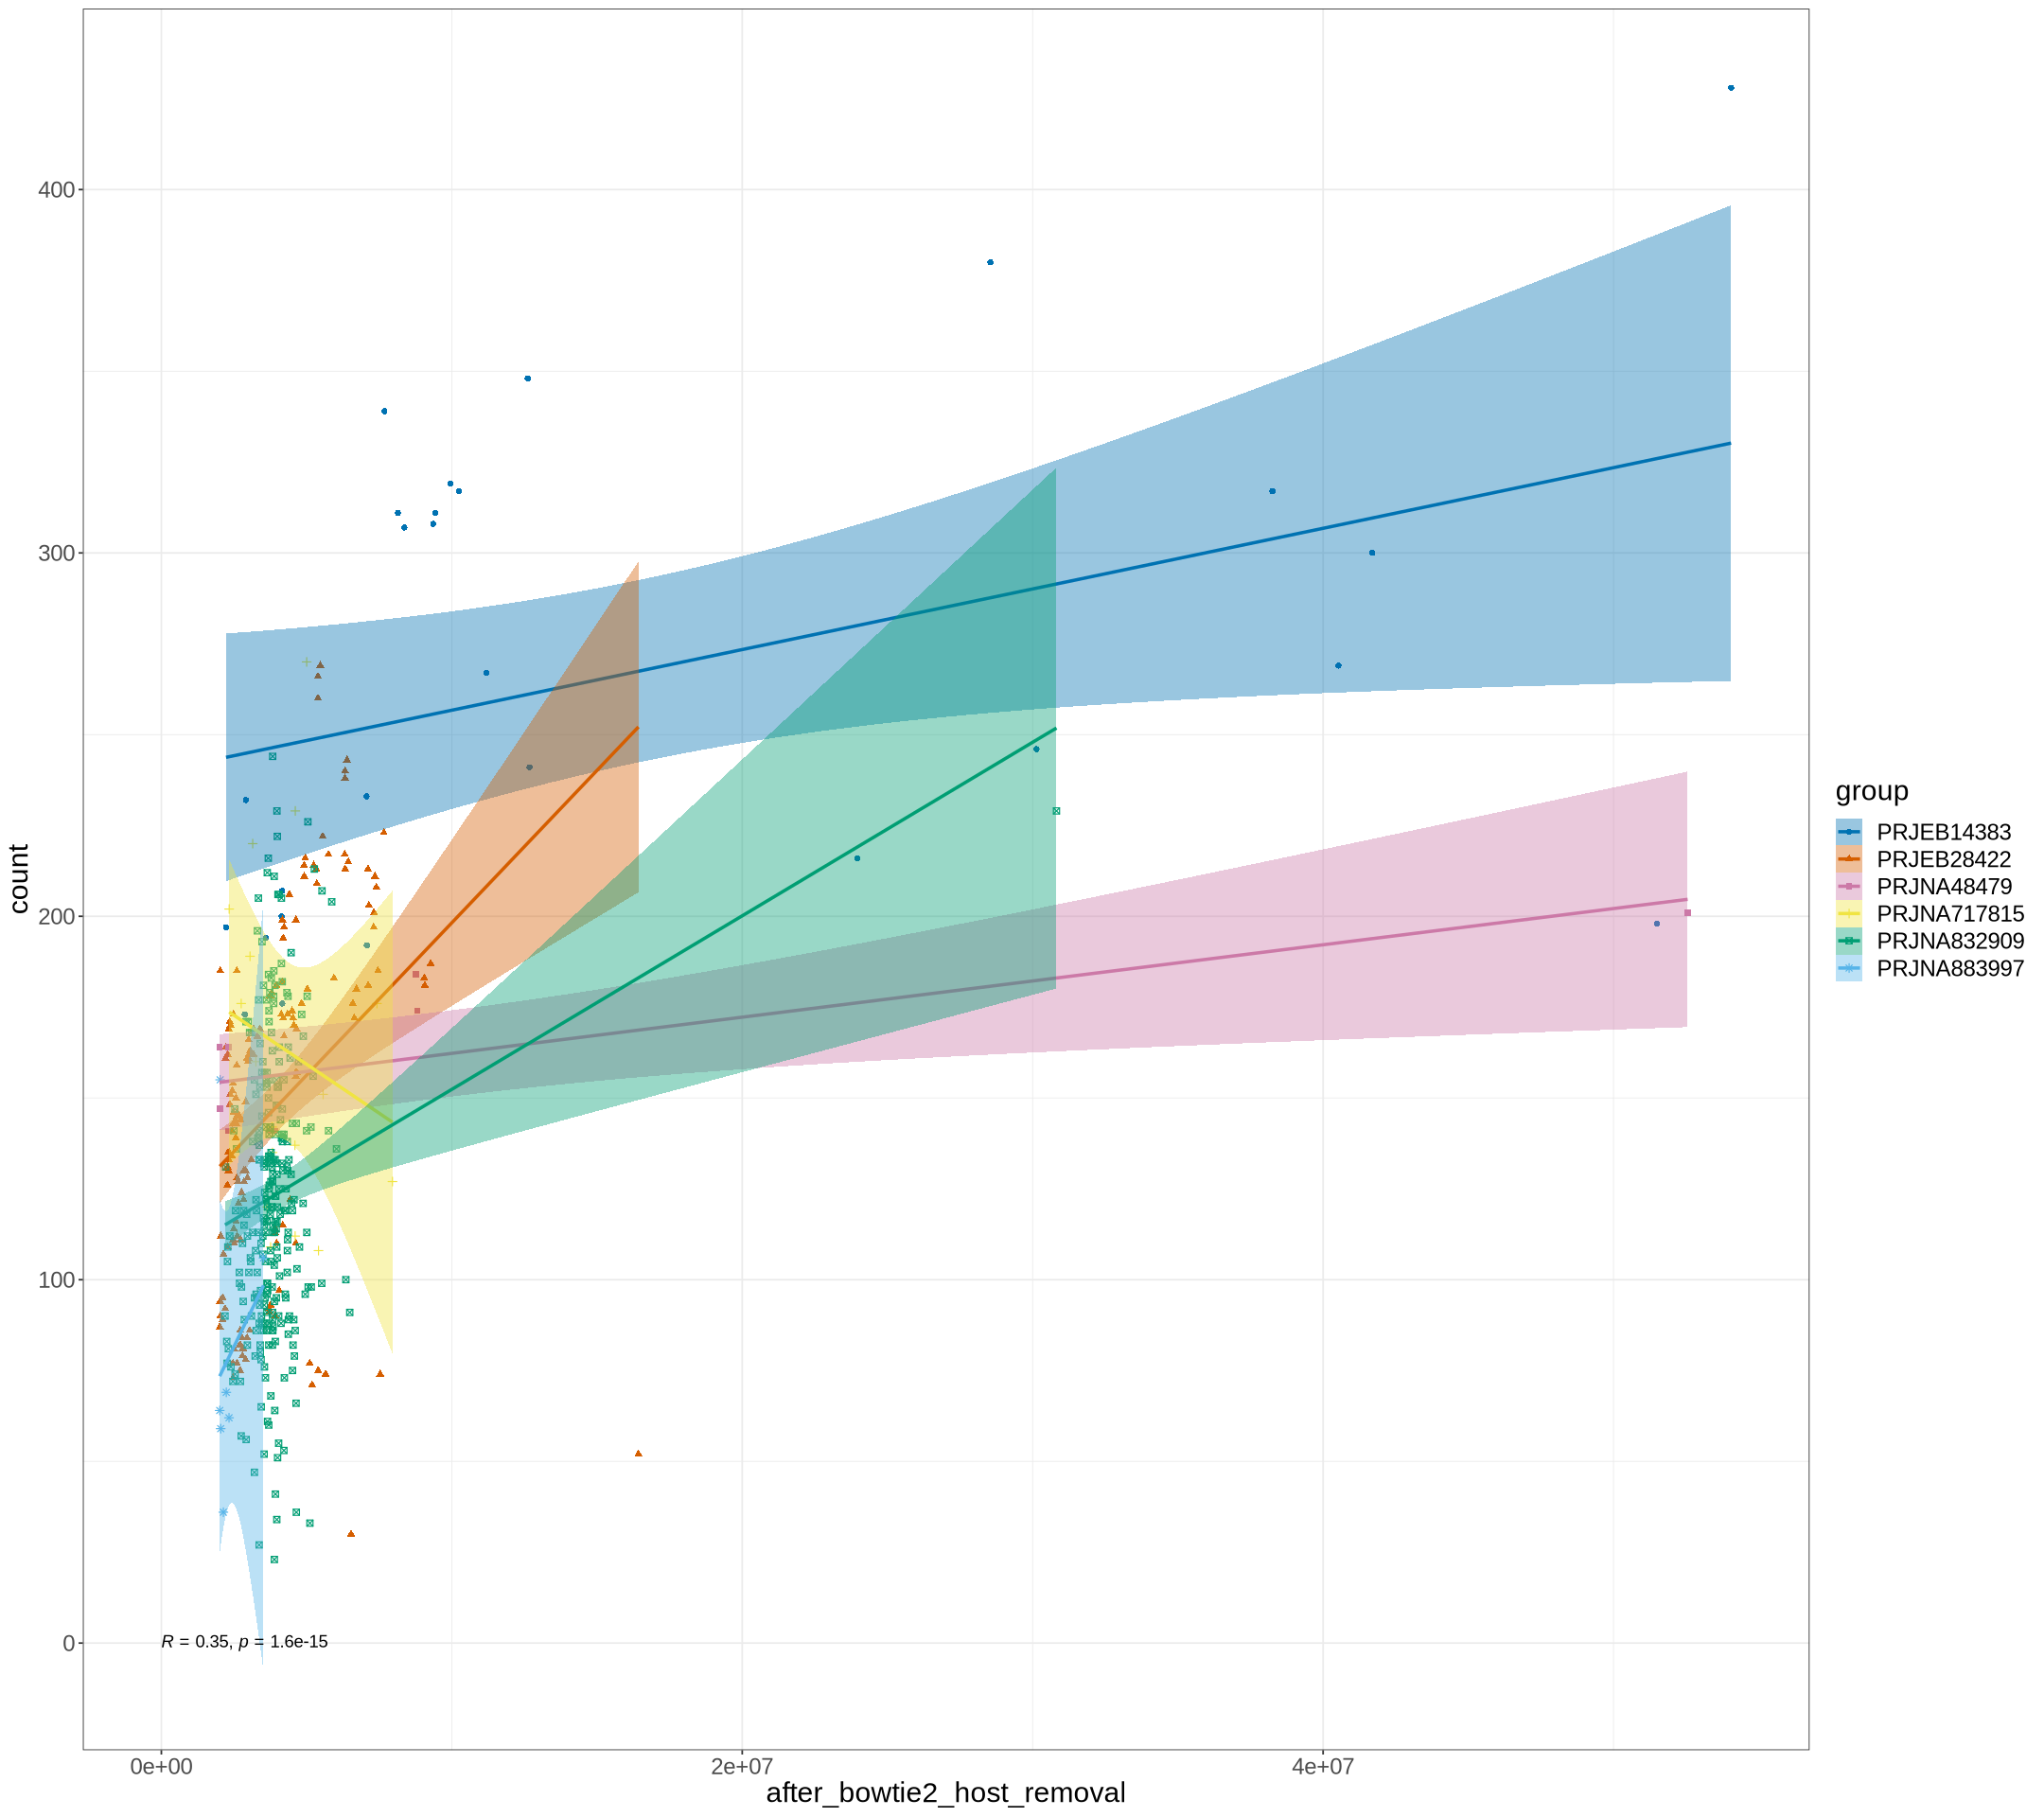

In [110]:
 plot + geom_point(position = position_jitter(width = 0.005, height = 0.005),aes(color = group, shape = group))+
  geom_smooth(aes(color = group, fill = group), 
              method = "lm", fullrange = FALSE) +
stat_cor(method = "spearman", 
           label.x = 0, label.y = 0) + 
  scale_color_manual(values = c("#0072B2", "#D55E00", "#CC79A7", "#F0E442", "#009E73", "#56B4E9")) +
  scale_fill_manual(values = c("#0072B2", "#D55E00", "#CC79A7", "#F0E442", "#009E73", "#56B4E9")) +
  theme_bw()+ 
theme(text = element_text(size = 18))
options(repr.plot.width=18)

In [112]:
pl <- plot + geom_point(position = position_jitter(width = 0.005, height = 0.005),aes(color = group, shape = group))+
  geom_smooth(aes(color = group, fill = group), 
              method = "lm", fullrange = FALSE) +
stat_cor(method = "spearman", 
           label.x = 0, label.y = 0) + 
  scale_color_manual(values = c("#0072B2", "#D55E00", "#CC79A7", "#F0E442", "#009E73", "#56B4E9")) +
  scale_fill_manual(values = c("#0072B2", "#D55E00", "#CC79A7", "#F0E442", "#009E73", "#56B4E9")) +
  theme_bw()+ 
theme(text = element_text(size = 18))
options(repr.plot.width=18)

In [114]:
pdf("richness_reads_6bioproject_above2millreads.pdf", width = 20 , height = 18)
 pl
dev.off()

`geom_smooth()` using formula = 'y ~ x'


png 
  2

In [115]:
pl1 <- plot + geom_point(position = position_jitter(width = 0.005, height = 0.005),aes(color = group, shape = group))+
  geom_smooth(aes(color = group, fill = group), 
              method = "lm", fullrange = FALSE) +
stat_cor(method = "spearman", 
           label.x = 0, label.y = 0) + 
  facet_wrap(~group) +
  scale_color_manual(values = c("#0072B2", "#D55E00", "#CC79A7", "#F0E442", "#009E73", "#56B4E9")) +
  scale_fill_manual(values = c("#0072B2", "#D55E00", "#CC79A7", "#F0E442", "#009E73", "#56B4E9")) +
  theme_bw()+ 
theme(text = element_text(size = 18))
options(repr.plot.width=18)

In [116]:
pdf("richness_reads_6bioproject_above2millreads_sep.pdf", width = 20 , height = 18)
 pl1
dev.off()

`geom_smooth()` using formula = 'y ~ x'


png 
  2

# genus level processing for stackbarplot (considered threshholds of 50 species and 2M reads)
## healthy: 350 samples / unhealthy : 224 samples 

In [98]:
setwd("/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/enterosignature-paper/input_tsv/")

In [99]:
noncontrols<- read.table(file = 'all_noncontrols_taxa.tsv', sep = '\t', header = TRUE)
dim(noncontrols)
head(noncontrols)


[1] 279 224

SRR21765456
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949           0.0000000  
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter 0.0000000  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum            0.0000000  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces              0.0185155  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Fannyhessea              0.0000000  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__GGB9835                  0.0000000  
                                                                                                                  SRR21765466
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949           0.00000000 
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter 0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum            0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces              0.04010099 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Fannyhessea              0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__GGB9835                  0.00000000 
                                                                                                                  SRR21765481
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949           0.0000000  
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter 0.0000000  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum            0.0000000  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces              0.0049532  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Fannyhessea              0.0000000  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__GGB9835                  0.0000000  
                                                                                                                  SRR21765484
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949           0.00000000 
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter 0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum            0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces              0.02911629 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Fannyhessea              0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__GGB9835                  0.00000000 
                                                                                                                  SRR21765486
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949           0.00000000 
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter 0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum            0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetac

In [101]:
noncontrols_df <- tibble::rownames_to_column(noncontrols, "genera")
row_sums <- rowSums(noncontrols_df[, 2:ncol(noncontrols_df)]) 
genera_mix <- cbind(noncontrols_df[, 1], row_sums, noncontrols_df[, 2:ncol(noncontrols_df) ])
colnames(genera_mix)[1] <- "genera"
colnames(genera_mix)[2] <- "total_abundance_genera"
head(genera_mix)
dim(genera_mix)
#sorting from highest total abundance to the lowest
sorted_g <- genera_mix[order(-genera_mix$total_abundance_genera), ]
head(sorted_g, n = 10)
top <- sorted_g[1:10,]

genera                                                                                                           
1 k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949          
2 k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter
3 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum           
4 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces             
5 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Fannyhessea             
6 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__GGB9835                 
  total_abundance_genera SRR21765456 SRR21765466 SRR21765481 SRR21765484
1  0.0002232             0.0000000   0.00000000  0.0000000   0.00000000 
2  0.0002962             0.0000000   0.00000000  0.0000000   0.00000000 
3  0.1913152             0.0000000   0.00000000  0.0000000   0.00000000 
4 15.1076315             0.0185155   0.04010099  0.0049532   0.02911629 
5  0.0000000             0.0000000   0.00000000  0.0000000   0.00000000 
6  0.0310026             0.0000000   0.00000000  0.0000000   0.00000000 
  SRR21765486 SRR21765496 ERR2764879   ERR2764880   ⋯ SRR23512052 SRR23512047
1 0.00000000  0.00000000  0.0000000000 0.0000000000 ⋯ 0.0000000   0.0000000  
2 0.00000000  0.00000000  0.0000000000 0.0000000000 ⋯ 0.0000000   0.0000000  
3 0.00000000  0.00000000  0.0006124001 0.0005421003 ⋯ 0.0002585   0.0003311  
4 0.07818301  0.03057681  0.0220375022 0.0195570098 ⋯ 0.0414419   0.1170684  
5 0.00000000  0.00000000  0.0000000000 0.0000000000 ⋯ 0.0000000   0.0000000  
6 0.00000000  0.00000000  0.0000000000 0.0000000000 ⋯ 0.0000000   0.0018294  
  SRR23512043 SRR23512039 SRR23512034 SRR23512222 SRR23512218  SRR23512214
1 0.000000000 0.0000000   0.00000000  0.000000    0.000000e+00 0.00000000 
2 0.000000000 0.0000000   0.00000000  0.000000    0.000000e+00 0.00000000 
3 0.001940801 0.0013582   0.00000000  0.000000    4.789999e-05 0.00000000 
4 0.060282618 0.0358629   0.05975929  0.010397    2.861249e-02 0.01655159 
5 0.000000000 0.0000000   0.00000000  0.000000    0.000000e+00 0.00000000 
6 0.000000000 0.0000000   0.00000000  0.000000    0.000000e+00 0.00000000 
  SRR23512210 SRR23512205
1 0.00000000  0.000000   
2 0.00000000  0.000000   
3 0.00000000  0.000000   
4 0.02454589  0.020061   
5 0.00000000  0.000000   
6 0.00000000  0.000000

[1] 279 226

genera                                                                                                  
127 k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus            
52  k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella            
221 k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria       
20  k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Micrococcales;f__Micrococcaceae;g__Rothia             
186 k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Veillonella          
4   k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces    
45  k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas     
112 k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Granulicatella          
253 k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus
106 k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillales_unclassified;g__Gemella                
    total_abundance_genera SRR21765456 SRR21765466 SRR21765481 SRR21765484
127 37.485234              0.0214970   0.028877991 0.0132130   0.014466697
52  30.225388              0.2521662   0.182778945 0.5695680   0.535022693
221 22.904308              0.0000000   0.205491838 0.0000000   0.000000000
20  17.138658              0.0118064   0.099374870 0.0000000   0.000000000
186 16.102604              0.0269079   0.074900478 0.1337762   0.252082550
4   15.107631              0.0185155   0.040100988 0.0049532   0.029116294
45  12.286506              0.0335461   0.015059695 0.0276288   0.000000000
112  5.774432              0.0029598   0.008395597 0.0042427   0.004463199
253  5.475186              0.0000000   0.005322098 0.0000000   0.000000000
106  5.220442              0.0000000   0.001012300 0.0000000   0.000000000
    SRR21765486 SRR21765496 ERR2764879  ERR2764880 ⋯ SRR23512052 SRR23512047
127 0.22657542  0.021806004 0.048520305 0.05339673 ⋯ 0.21321928  0.279623328
52  0.09970351  0.643973729 0.069676707 0.06794673 ⋯ 0.11210489  0.123235612
221 0.00000000  0.000000000 0.273612827 0.27562144 ⋯ 0.07336389  0.006232601
20  0.10959901  0.009618102 0.026309403 0.02657991 ⋯ 0.02316840  0.012395101
186 0.17688792  0.078151616 0.032854403 0.03143722 ⋯ 0.16748728  0.181338718
4   0.07818301  0.030576806 0.022037502 0.01955701 ⋯ 0.04144190  0.117068412
45  0.01712290  0.000000000 0.181565218 0.18222649 ⋯ 0.00421200  0.004965500
112 0.02179070  0.000000000 0.013047601 0.01255371 ⋯ 0.03173030  0.033104003
253 0.00000000  0.000000000 0.015064602 0.01125631 ⋯ 0.05830389  0.007537501
106 0.00398250  0.000000000 0.009347801 0.01010461 ⋯ 0.01563510  0.021807002
    SRR23512043 SRR23512039 SRR23512034 SRR23512222 SRR23512218 SRR23512214
127 0.17872145  0.18569532  0.09110839  0.16481378  0.24541555  0.10801645 
52  0.18544676  0.06987571  0.09459459  0.05202349  0.02687619  0.23233248 
221 0.04256701  0.18822732  0.34717217  0.26184687  0.09557838  0.09360395 
20  0.01569970  0.07185861  0.04296260  0.03744880  0.01002120  0.02902969 
186 0.06323212  0.04197290  0.05550209  0.03259190  0.12120378  0.05549427 
4   0.06028262  0.03586290  0.05975929  0.01039700  0.02861249  0.01655159 
45  0.03705881  0.03698040  0.09369659  0.03792120  0.02581829  0.01541989 
112 0.01713211  0.03616000  0.01481480  0.03190380  0.13131257  0.03466218 
253 0.01386250  0.01318220  0.03282610  0.02927910  0.05584419  0.02062749 
106 0.04094231  0.02681180  0.02565900  0.03978510  0.07703528  0.01941799 
    SRR23512210  SRR23512205
127 0.2303299079 0.105554979
52  0.1754821298 0.270552446
221 0.1301926479 0.107528778
20  0.0162939935 0.026271595
186 0.1623192351 0.197377761
4   0.0245458902 0.020060996
45  0.0009553996 0.008630698
112 0.0369849852 0.022762595
253 0.0127450949 0.051466590
106 0.0

In [12]:
#setwd("/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/enterosignature-paper/NMF_outputs_all/all_controls/")

In [103]:
write.csv(top, file = "10highest_genera_224unealthy.csv" , row.names= FALSE )

In [104]:
other <- sorted_g[-(1:10),]

In [106]:
other <- other[,-2]

In [107]:
rownames(other) <- other[, 1]
other <- other[, -1]
head(other)

SRR21765456
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium      0.0007549  
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__GGB1144                 0.0000000  
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Leptotrichia       0.0000000  
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__GGB10485                    0.0005915  
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Alloprevotella          0.0070566  
k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga 0.0000000  
                                                                                                          SRR21765466 
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium      0.0002963999
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__GGB1144                 0.0276090917
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Leptotrichia       0.0003389999
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__GGB10485                    0.0020849994
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Alloprevotella          0.0402175879
k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga 0.0055434983
                                                                                                          SRR21765481
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium      0.00000000 
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__GGB1144                 0.06017261 
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Leptotrichia       0.00283760 
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__GGB10485                    0.00115010 
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Alloprevotella          0.04561960 
k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga 0.01454410 
                                                                                                          SRR21765484
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium      0.0000000  
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__GGB1144                 0.0000000  
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Leptotrichia       0.0217591  
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__GGB10485                    0.0010395  
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Alloprevotella          0.0015457  
k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga 0.0112229  
                                                                                                          SRR21765486
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium      0.0000000  
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__GGB1144                 0.0022856  
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Leptotrichia       0.0000000  
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__GGB10485                    0.0139572  
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Alloprevotella          0.0018302  
k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae

In [108]:
column_sums <- colSums(other) 

y1 <- rbind(other, column_sums)
tail(y1)
dim(y1)

SRR21765456
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Moraxellales;f__Moraxellaceae;g__Psychrobacter     0.0000000  
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Photobacterium      0.0000000  
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Xanthomonas 0.0000000  
k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Pyramidobacter           0.0000000  
k__Eukaryota;p__Basidiomycota;c__Malasseziomycetes;o__Malasseziales;f__Malasseziaceae;g__Malassezia        0.0000000  
270                                                                                                        0.6326011  
                                                                                                           SRR21765466
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Moraxellales;f__Moraxellaceae;g__Psychrobacter     0.0000000  
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Photobacterium      0.0000000  
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Xanthomonas 0.0000000  
k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Pyramidobacter           0.0000000  
k__Eukaryota;p__Basidiomycota;c__Malasseziomycetes;o__Malasseziales;f__Malasseziaceae;g__Malassezia        0.0000000  
270                                                                                                        0.3386852  
                                                                                                           SRR21765481
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Moraxellales;f__Moraxellaceae;g__Psychrobacter     0.0000000  
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Photobacterium      0.0000000  
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Xanthomonas 0.0000000  
k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Pyramidobacter           0.0000000  
k__Eukaryota;p__Basidiomycota;c__Malasseziomycetes;o__Malasseziales;f__Malasseziaceae;g__Malassezia        0.0000000  
270                                                                                                        0.2466181  
                                                                                                           SRR21765484
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Moraxellales;f__Moraxellaceae;g__Psychrobacter     0.0000000  
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Photobacterium      0.0000000  
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Xanthomonas 0.0000000  
k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Pyramidobacter           0.0000000  
k__Eukaryota;p__Basidiomycota;c__Malasseziomycetes;o__Malasseziales;f__Malasseziaceae;g__Malassezia        0.0000000  
270                                                                                                        0.1648486  
                                                                                                           SRR21765486
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Moraxellales;f__Moraxellaceae;g__Psychrobacter     0.000000   
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Photobacterium      0.000000   
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Xanthomonas 0.000000   
k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Pyramidobacter           0.000000   
k__Eukaryota;p__Basidiomycota;c__Malasseziomycetes;o__Malasseziales;f__Malasseziaceae;g__Malassezia        0.000000   
270                                                          

[1] 270 224

In [109]:
row.names(y1)[row.names(y1) == "270"] <- "other"

In [110]:
y1 <- tibble::rownames_to_column(y1, "genera")
head(y1)
tail(y1)

genera                                                                                                   
1 k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium     
2 k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__GGB1144                
3 k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Leptotrichia      
4 k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__GGB10485                   
5 k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Alloprevotella         
6 k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga
  SRR21765456 SRR21765466  SRR21765481 SRR21765484 SRR21765486 SRR21765496 
1 0.0007549   0.0002963999 0.00000000  0.0000000   0.0000000   0.0000000000
2 0.0000000   0.0276090917 0.06017261  0.0000000   0.0022856   0.0144633029
3 0.0000000   0.0003389999 0.00283760  0.0217591   0.0000000   0.0003321001
4 0.0005915   0.0020849994 0.00115010  0.0010395   0.0139572   0.0000000000
5 0.0070566   0.0402175879 0.04561960  0.0015457   0.0018302   0.0002965001
6 0.0000000   0.0055434983 0.01454410  0.0112229   0.0224135   0.0000000000
  ERR2764879  ERR2764880   ERR2764881   ⋯ SRR23512052  SRR23512047 SRR23512043
1 0.007899201 6.390003e-03 0.0067246939 ⋯ 0.0152449985 0.0033665   0.044132113
2 0.066560207 6.553003e-02 0.0687370381 ⋯ 0.0017099998 0.0027730   0.010598503
3 0.000375900 4.627002e-04 0.0003366997 ⋯ 0.0257332974 0.0411948   0.016340805
4 0.000293100 3.440002e-05 0.0002753998 ⋯ 0.0017828998 0.0024379   0.004495101
5 0.021450802 2.432601e-02 0.0112903898 ⋯ 0.0006103999 0.0015520   0.010438303
6 0.008106901 7.592704e-03 0.0061925944 ⋯ 0.0110987989 0.0023905   0.056602117
  SRR23512039 SRR23512034 SRR23512222 SRR23512218  SRR23512214  SRR23512210 
1 0.011154501 0.026955397 0.022132998 0.0129836974 0.0291147854 0.0437298825
2 0.002644200 0.024663398 0.001971600 0.0009859998 0.0002298999 0.0005144998
3 0.006977601 0.007102299 0.009561699 0.0063815987 0.0009313995 0.0100156960
4 0.007562301 0.001439600 0.009696699 0.0034008993 0.0030136985 0.0037105985
5 0.005206001 0.008343599 0.030892397 0.0219919956 0.0084660958 0.0209611916
6 0.005027601 0.001953700 0.000000000 0.0036215993 0.0038144981 0.0082887967
  SRR23512205 
1 3.567699e-02
2 8.641998e-03
3 1.889650e-02
4 5.400499e-03
5 1.940000e-03
6 6.939999e-05

genera                                                                                                    
265 k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Moraxellales;f__Moraxellaceae;g__Psychrobacter    
266 k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Photobacterium     
267 k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Xanthomonas
268 k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Pyramidobacter          
269 k__Eukaryota;p__Basidiomycota;c__Malasseziomycetes;o__Malasseziales;f__Malasseziaceae;g__Malassezia       
270 other                                                                                                     
    SRR21765456 SRR21765466 SRR21765481 SRR21765484 SRR21765486 SRR21765496
265 0.0000000   0.0000000   0.0000000   0.0000000   0.000000    0.0000000  
266 0.0000000   0.0000000   0.0000000   0.0000000   0.000000    0.0000000  
267 0.0000000   0.0000000   0.0000000   0.0000000   0.000000    0.0000000  
268 0.0000000   0.0000000   0.0000000   0.0000000   0.000000    0.0000000  
269 0.0000000   0.0000000   0.0000000   0.0000000   0.000000    0.0000000  
270 0.6326011   0.3386852   0.2466181   0.1648486   0.266155    0.2158737  
    ERR2764879 ERR2764880 ERR2764881 ⋯ SRR23512052 SRR23512047 SRR23512043
265 0.0000000  0.0000000  0.0000000  ⋯ 0.0000000   0.0000000   0.0000000  
266 0.0000000  0.0000000  0.0000000  ⋯ 0.0000000   0.0000000   0.0000000  
267 0.0000000  0.0000000  0.0000000  ⋯ 0.0000000   0.0000000   0.0000000  
268 0.0000000  0.0000000  0.0000000  ⋯ 0.0000000   0.0000000   0.0000000  
269 0.0000000  0.0000000  0.0000000  ⋯ 0.0000000   0.0000000   0.0000000  
270 0.3079636  0.3093199  0.2973639  ⋯ 0.2593331   0.2126922   0.3450546  
    SRR23512039 SRR23512034 SRR23512222 SRR23512218 SRR23512214 SRR23512210
265 0.0000000   0.0000000   0.000000    0.0000000   0.000000    0.0000000  
266 0.0000000   0.0000000   0.000000    0.0000000   0.000000    0.0000000  
267 0.0000000   0.0000000   0.000000    0.0000000   0.000000    0.0000000  
268 0.0000000   0.0000000   0.000000    0.0000000   0.000000    0.0000000  
269 0.0000000   0.0000000   0.000000    0.0000000   0.000000    0.0000000  
270 0.2933728   0.1419044   0.301989    0.1822821   0.374844    0.1963719  
    SRR23512205
265 0.0000000  
266 0.0000000  
267 0.0000000  
268 0.0000000  
269 0.0000000  
270 0.1415057

In [112]:
top <- top[,-2] 
head(top)

genera                                                                                              
127 k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus        
52  k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella        
221 k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria   
20  k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Micrococcales;f__Micrococcaceae;g__Rothia         
186 k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Veillonella      
4   k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces
    SRR21765456 SRR21765466 SRR21765481 SRR21765484 SRR21765486 SRR21765496
127 0.0214970   0.02887799  0.0132130   0.01446670  0.22657542  0.021806004
52  0.2521662   0.18277895  0.5695680   0.53502269  0.09970351  0.643973729
221 0.0000000   0.20549184  0.0000000   0.00000000  0.00000000  0.000000000
20  0.0118064   0.09937487  0.0000000   0.00000000  0.10959901  0.009618102
186 0.0269079   0.07490048  0.1337762   0.25208255  0.17688792  0.078151616
4   0.0185155   0.04010099  0.0049532   0.02911629  0.07818301  0.030576806
    ERR2764879 ERR2764880 ERR2764881 ⋯ SRR23512052 SRR23512047 SRR23512043
127 0.04852030 0.05339673 0.05182955 ⋯ 0.21321928  0.279623328 0.17872145 
52  0.06967671 0.06794673 0.06860864 ⋯ 0.11210489  0.123235612 0.18544676 
221 0.27361283 0.27562144 0.27372575 ⋯ 0.07336389  0.006232601 0.04256701 
20  0.02630940 0.02657991 0.02540198 ⋯ 0.02316840  0.012395101 0.01569970 
186 0.03285440 0.03143722 0.03231957 ⋯ 0.16748728  0.181338718 0.06323212 
4   0.02203750 0.01955701 0.02928137 ⋯ 0.04144190  0.117068412 0.06028262 
    SRR23512039 SRR23512034 SRR23512222 SRR23512218 SRR23512214 SRR23512210
127 0.18569532  0.09110839  0.16481378  0.24541555  0.10801645  0.23032991 
52  0.06987571  0.09459459  0.05202349  0.02687619  0.23233248  0.17548213 
221 0.18822732  0.34717217  0.26184687  0.09557838  0.09360395  0.13019265 
20  0.07185861  0.04296260  0.03744880  0.01002120  0.02902969  0.01629399 
186 0.04197290  0.05550209  0.03259190  0.12120378  0.05549427  0.16231924 
4   0.03586290  0.05975929  0.01039700  0.02861249  0.01655159  0.02454589 
    SRR23512205
127 0.10555498 
52  0.27055245 
221 0.10752878 
20  0.02627159 
186 0.19737776 
4   0.02006100

In [113]:
row <- y1[270,]
ab <- rbind(top, row)
tail(ab)
dim(ab)

genera                                                                                                  
4   k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces    
45  k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas     
112 k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Granulicatella          
253 k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus
106 k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillales_unclassified;g__Gemella                
270 other                                                                                                   
    SRR21765456 SRR21765466 SRR21765481 SRR21765484 SRR21765486 SRR21765496
4   0.0185155   0.040100988 0.0049532   0.029116294 0.07818301  0.03057681 
45  0.0335461   0.015059695 0.0276288   0.000000000 0.01712290  0.00000000 
112 0.0029598   0.008395597 0.0042427   0.004463199 0.02179070  0.00000000 
253 0.0000000   0.005322098 0.0000000   0.000000000 0.00000000  0.00000000 
106 0.0000000   0.001012300 0.0000000   0.000000000 0.00398250  0.00000000 
270 0.6326011   0.338685198 0.2466181   0.164848567 0.26615503  0.21587374 
    ERR2764879  ERR2764880 ERR2764881  ⋯ SRR23512052 SRR23512047 SRR23512043
4   0.022037502 0.01955701 0.029281374 ⋯ 0.04144190  0.117068412 0.06028262 
45  0.181565218 0.18222649 0.181896336 ⋯ 0.00421200  0.004965500 0.03705881 
112 0.013047601 0.01255371 0.012622589 ⋯ 0.03173030  0.033104003 0.01713211 
253 0.015064602 0.01125631 0.017454584 ⋯ 0.05830389  0.007537501 0.01386250 
106 0.009347801 0.01010461 0.009495691 ⋯ 0.01563510  0.021807002 0.04094231 
270 0.307963631 0.30931985 0.297363932 ⋯ 0.25933307  0.212692221 0.34505460 
    SRR23512039 SRR23512034 SRR23512222 SRR23512218 SRR23512214 SRR23512210 
4   0.0358629   0.05975929  0.0103970   0.02861249  0.01655159  0.0245458902
45  0.0369804   0.09369659  0.0379212   0.02581829  0.01541989  0.0009553996
112 0.0361600   0.01481480  0.0319038   0.13131257  0.03466218  0.0369849852
253 0.0131822   0.03282610  0.0292791   0.05584419  0.02062749  0.0127450949
106 0.0268118   0.02565900  0.0397851   0.07703528  0.01941799  0.0137787945
270 0.2933728   0.14190439  0.3019890   0.18228206  0.37484401  0.1963719215
    SRR23512205
4   0.020060996
45  0.008630698
112 0.022762595
253 0.051466590
106 0.048287890
270 0.141505672

[1]  11 225

In [114]:
getwd()

[1] "/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/enterosignature-paper/input_tsv"

In [115]:
write.csv(ab, file = "11genera&other_224unhealthy.csv" , row.names= FALSE )

In [116]:
ab <- read.csv( file =  "11genera&other_224unhealthy.csv", header = TRUE, sep = ",", quote = "\"" )
head(ab)

genera                                                                                              
1 k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus        
2 k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella        
3 k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria   
4 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Micrococcales;f__Micrococcaceae;g__Rothia         
5 k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Veillonella      
6 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces
  SRR21765456 SRR21765466 SRR21765481 SRR21765484 SRR21765486 SRR21765496
1 0.0214970   0.02887799  0.0132130   0.01446670  0.22657542  0.021806004
2 0.2521662   0.18277895  0.5695680   0.53502269  0.09970351  0.643973729
3 0.0000000   0.20549184  0.0000000   0.00000000  0.00000000  0.000000000
4 0.0118064   0.09937487  0.0000000   0.00000000  0.10959901  0.009618102
5 0.0269079   0.07490048  0.1337762   0.25208255  0.17688792  0.078151616
6 0.0185155   0.04010099  0.0049532   0.02911629  0.07818301  0.030576806
  ERR2764879 ERR2764880 ERR2764881 ⋯ SRR23512052 SRR23512047 SRR23512043
1 0.04852030 0.05339673 0.05182955 ⋯ 0.21321928  0.279623328 0.17872145 
2 0.06967671 0.06794673 0.06860864 ⋯ 0.11210489  0.123235612 0.18544676 
3 0.27361283 0.27562144 0.27372575 ⋯ 0.07336389  0.006232601 0.04256701 
4 0.02630940 0.02657991 0.02540198 ⋯ 0.02316840  0.012395101 0.01569970 
5 0.03285440 0.03143722 0.03231957 ⋯ 0.16748728  0.181338718 0.06323212 
6 0.02203750 0.01955701 0.02928137 ⋯ 0.04144190  0.117068412 0.06028262 
  SRR23512039 SRR23512034 SRR23512222 SRR23512218 SRR23512214 SRR23512210
1 0.18569532  0.09110839  0.16481378  0.24541555  0.10801645  0.23032991 
2 0.06987571  0.09459459  0.05202349  0.02687619  0.23233248  0.17548213 
3 0.18822732  0.34717217  0.26184687  0.09557838  0.09360395  0.13019265 
4 0.07185861  0.04296260  0.03744880  0.01002120  0.02902969  0.01629399 
5 0.04197290  0.05550209  0.03259190  0.12120378  0.05549427  0.16231924 
6 0.03586290  0.05975929  0.01039700  0.02861249  0.01655159  0.02454589 
  SRR23512205
1 0.10555498 
2 0.27055245 
3 0.10752878 
4 0.02627159 
5 0.19737776 
6 0.02006100

In [117]:
# Shorten the names of taxa by keeping only the genus if not duplicated in the name vector
shorten_genus <- function(genus, genera_list){
    shorten <- gsub(".*;([^\\;?]+[;\\?]*)$", "\\1", genus, perl = TRUE)
    # print(paste("shorten ", shorten))
    # count how many times the shorten version of the genus appears in the vector
    if (grepl( ";", shorten, fixed = TRUE)) {
        nb_occ <- sum(str_count(genera_list, coll(shorten)))
    } else {
        nb_occ <- sum(str_count(genera_list, sprintf("\\b%s\\b", shorten)))
    } 
    # print(paste("nbocc ", nb_occ))
    # count how many times the shorten version of the genus appears in the shorten version of all x in the vector
    if (grepl( ";", shorten, fixed = TRUE)) {
        nb_occ2 <- sum(str_count(gsub(".*;([^\\;?]+[;\\?]*)$", "\\1", genera_list), coll(shorten)))
    } else {
        nb_occ2 <- sum(str_count(gsub(".*;([^\\;?]+[;\\?]*)$", "\\1", genera_list), sprintf("\\b%s\\b", shorten)))
    } 
    # print(paste("nbocc2 ", nb_occ2))
    shorten2= ifelse(nb_occ2 > 1, gsub(".*;([a-zA-Z0-9-\\?]+;[a-zA-Z0-9-\\?]+;[a-zA-Z0-9-\\?]+)$", "\\1", genus, perl = TRUE), shorten)
    # print(paste("shorten ", shorten))
    return(ifelse(nb_occ == 1, shorten, ifelse(nb_occ2 ==1, gsub(".*;([a-zA-Z0-9-]+;[a-zA-Z0-9-]+)$", "\\1", genus, perl = TRUE), shorten2)))
}

In [118]:
ab$genera <- lapply(ab$genera, shorten_genus, genera=ab$genera)
head(ab)

genera           SRR21765456 SRR21765466 SRR21765481 SRR21765484 SRR21765486
1 g__Streptococcus 0.0214970   0.02887799  0.0132130   0.01446670  0.22657542 
2 g__Prevotella    0.2521662   0.18277895  0.5695680   0.53502269  0.09970351 
3 g__Neisseria     0.0000000   0.20549184  0.0000000   0.00000000  0.00000000 
4 g__Rothia        0.0118064   0.09937487  0.0000000   0.00000000  0.10959901 
5 g__Veillonella   0.0269079   0.07490048  0.1337762   0.25208255  0.17688792 
6 g__Actinomyces   0.0185155   0.04010099  0.0049532   0.02911629  0.07818301 
  SRR21765496 ERR2764879 ERR2764880 ERR2764881 ⋯ SRR23512052 SRR23512047
1 0.021806004 0.04852030 0.05339673 0.05182955 ⋯ 0.21321928  0.279623328
2 0.643973729 0.06967671 0.06794673 0.06860864 ⋯ 0.11210489  0.123235612
3 0.000000000 0.27361283 0.27562144 0.27372575 ⋯ 0.07336389  0.006232601
4 0.009618102 0.02630940 0.02657991 0.02540198 ⋯ 0.02316840  0.012395101
5 0.078151616 0.03285440 0.03143722 0.03231957 ⋯ 0.16748728  0.181338718
6 0.030576806 0.02203750 0.01955701 0.02928137 ⋯ 0.04144190  0.117068412
  SRR23512043 SRR23512039 SRR23512034 SRR23512222 SRR23512218 SRR23512214
1 0.17872145  0.18569532  0.09110839  0.16481378  0.24541555  0.10801645 
2 0.18544676  0.06987571  0.09459459  0.05202349  0.02687619  0.23233248 
3 0.04256701  0.18822732  0.34717217  0.26184687  0.09557838  0.09360395 
4 0.01569970  0.07185861  0.04296260  0.03744880  0.01002120  0.02902969 
5 0.06323212  0.04197290  0.05550209  0.03259190  0.12120378  0.05549427 
6 0.06028262  0.03586290  0.05975929  0.01039700  0.02861249  0.01655159 
  SRR23512210 SRR23512205
1 0.23032991  0.10555498 
2 0.17548213  0.27055245 
3 0.13019265  0.10752878 
4 0.01629399  0.02627159 
5 0.16231924  0.19737776 
6 0.02454589  0.02006100

In [119]:
ab$genera <- as.character(ab$genera)
head(ab)

genera           SRR21765456 SRR21765466 SRR21765481 SRR21765484 SRR21765486
1 g__Streptococcus 0.0214970   0.02887799  0.0132130   0.01446670  0.22657542 
2 g__Prevotella    0.2521662   0.18277895  0.5695680   0.53502269  0.09970351 
3 g__Neisseria     0.0000000   0.20549184  0.0000000   0.00000000  0.00000000 
4 g__Rothia        0.0118064   0.09937487  0.0000000   0.00000000  0.10959901 
5 g__Veillonella   0.0269079   0.07490048  0.1337762   0.25208255  0.17688792 
6 g__Actinomyces   0.0185155   0.04010099  0.0049532   0.02911629  0.07818301 
  SRR21765496 ERR2764879 ERR2764880 ERR2764881 ⋯ SRR23512052 SRR23512047
1 0.021806004 0.04852030 0.05339673 0.05182955 ⋯ 0.21321928  0.279623328
2 0.643973729 0.06967671 0.06794673 0.06860864 ⋯ 0.11210489  0.123235612
3 0.000000000 0.27361283 0.27562144 0.27372575 ⋯ 0.07336389  0.006232601
4 0.009618102 0.02630940 0.02657991 0.02540198 ⋯ 0.02316840  0.012395101
5 0.078151616 0.03285440 0.03143722 0.03231957 ⋯ 0.16748728  0.181338718
6 0.030576806 0.02203750 0.01955701 0.02928137 ⋯ 0.04144190  0.117068412
  SRR23512043 SRR23512039 SRR23512034 SRR23512222 SRR23512218 SRR23512214
1 0.17872145  0.18569532  0.09110839  0.16481378  0.24541555  0.10801645 
2 0.18544676  0.06987571  0.09459459  0.05202349  0.02687619  0.23233248 
3 0.04256701  0.18822732  0.34717217  0.26184687  0.09557838  0.09360395 
4 0.01569970  0.07185861  0.04296260  0.03744880  0.01002120  0.02902969 
5 0.06323212  0.04197290  0.05550209  0.03259190  0.12120378  0.05549427 
6 0.06028262  0.03586290  0.05975929  0.01039700  0.02861249  0.01655159 
  SRR23512210 SRR23512205
1 0.23032991  0.10555498 
2 0.17548213  0.27055245 
3 0.13019265  0.10752878 
4 0.01629399  0.02627159 
5 0.16231924  0.19737776 
6 0.02454589  0.02006100

In [120]:
# library(data.table) 
df_t <- transpose(ab)
rownames(df_t) <- colnames(ab)
colnames(df_t) <- rownames(ab)
head(df_t)

1                  2                 3                
genera      g__Streptococcus   g__Prevotella     g__Neisseria     
SRR21765456 0.021497           0.2521662         0                
SRR21765466 0.0288779913366026 0.182778945166316 0.205491838352448
SRR21765481 0.0132130013213001 0.569567956956796 0                
SRR21765484 0.0144666971066606 0.535022692995461 0                
SRR21765486 0.226575422657542  0.099703509970351 0                
            4                  5                  6                  
genera      g__Rothia          g__Veillonella     g__Actinomyces     
SRR21765456 0.0118064          0.0269079          0.0185155          
SRR21765466 0.0993748701875389 0.0749004775298567 0.0401009879697036 
SRR21765481 0                  0.133776213377621  0.00495320049532005
SRR21765484 0                  0.25208254958349   0.0291162941767412 
SRR21765486 0.109599010959901  0.176887917688792  0.0781830078183008 
            7                  8                   9                  
genera      g__Porphyromonas   g__Granulicatella   g__Haemophilus     
SRR21765456 0.0335461          0.0029598           0                  
SRR21765466 0.0150596954820914 0.00839559748132076 0.00532209840337048
SRR21765481 0.0276288027628803 0.00424270042427004 0                  
SRR21765484 0                  0.00446319910736018 0                  
SRR21765486 0.0171229017122902 0.0217907021790702  0                  
            10                  11               
genera      g__Gemella          other            
SRR21765456 0                   0.6326011        
SRR21765466 0.00101229969631009 0.33868519839444 
SRR21765481 0                   0.246618124661812
SRR21765484 0                   0.164848567030287
SRR21765486 0.00398250039825004 0.266155026615503

In [121]:
colnames(df_t) <- df_t[1, ]

# Remove the first row
df_t <- df_t[-1, ]
head(df_t)


g__Streptococcus   g__Prevotella     g__Neisseria     
SRR21765456 0.021497           0.2521662         0                
SRR21765466 0.0288779913366026 0.182778945166316 0.205491838352448
SRR21765481 0.0132130013213001 0.569567956956796 0                
SRR21765484 0.0144666971066606 0.535022692995461 0                
SRR21765486 0.226575422657542  0.099703509970351 0                
SRR21765496 0.0218060043612009 0.643973728794746 0                
            g__Rothia           g__Veillonella     g__Actinomyces     
SRR21765456 0.0118064           0.0269079          0.0185155          
SRR21765466 0.0993748701875389  0.0749004775298567 0.0401009879697036 
SRR21765481 0                   0.133776213377621  0.00495320049532005
SRR21765484 0                   0.25208254958349   0.0291162941767412 
SRR21765486 0.109599010959901   0.176887917688792  0.0781830078183008 
SRR21765496 0.00961810192362038 0.0781516156303231 0.0305768061153612 
            g__Porphyromonas   g__Granulicatella   g__Haemophilus     
SRR21765456 0.0335461          0.0029598           0                  
SRR21765466 0.0150596954820914 0.00839559748132076 0.00532209840337048
SRR21765481 0.0276288027628803 0.00424270042427004 0                  
SRR21765484 0                  0.00446319910736018 0                  
SRR21765486 0.0171229017122902 0.0217907021790702  0                  
SRR21765496 0                  0                   0                  
            g__Gemella          other            
SRR21765456 0                   0.6326011        
SRR21765466 0.00101229969631009 0.33868519839444 
SRR21765481 0                   0.246618124661812
SRR21765484 0                   0.164848567030287
SRR21765486 0.00398250039825004 0.266155026615503
SRR21765496 0                   0.215873743174749

In [122]:
df_flip <- tibble::rownames_to_column(df_t, "Samples")
head(df_flip)

Samples     g__Streptococcus   g__Prevotella     g__Neisseria     
1 SRR21765456 0.021497           0.2521662         0                
2 SRR21765466 0.0288779913366026 0.182778945166316 0.205491838352448
3 SRR21765481 0.0132130013213001 0.569567956956796 0                
4 SRR21765484 0.0144666971066606 0.535022692995461 0                
5 SRR21765486 0.226575422657542  0.099703509970351 0                
6 SRR21765496 0.0218060043612009 0.643973728794746 0                
  g__Rothia           g__Veillonella     g__Actinomyces      g__Porphyromonas  
1 0.0118064           0.0269079          0.0185155           0.0335461         
2 0.0993748701875389  0.0749004775298567 0.0401009879697036  0.0150596954820914
3 0                   0.133776213377621  0.00495320049532005 0.0276288027628803
4 0                   0.25208254958349   0.0291162941767412  0                 
5 0.109599010959901   0.176887917688792  0.0781830078183008  0.0171229017122902
6 0.00961810192362038 0.0781516156303231 0.0305768061153612  0                 
  g__Granulicatella   g__Haemophilus      g__Gemella          other            
1 0.0029598           0                   0                   0.6326011        
2 0.00839559748132076 0.00532209840337048 0.00101229969631009 0.33868519839444 
3 0.00424270042427004 0                   0                   0.246618124661812
4 0.00446319910736018 0                   0                   0.164848567030287
5 0.0217907021790702  0                   0.00398250039825004 0.266155026615503
6 0                   0                   0                   0.215873743174749

In [123]:
df_long <- pivot_longer(df_flip, cols = -Samples, names_to = "Bacteria", values_to = "Abundance")

In [124]:
df_long$Abundance <- as.numeric(df_long$Abundance)
custom_palette <- c("#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", 
                    "#aec7e8", "#ff9896", "#98df8a", "#ff9e19", "#ffbb78", 
                    "#f7b6d2")

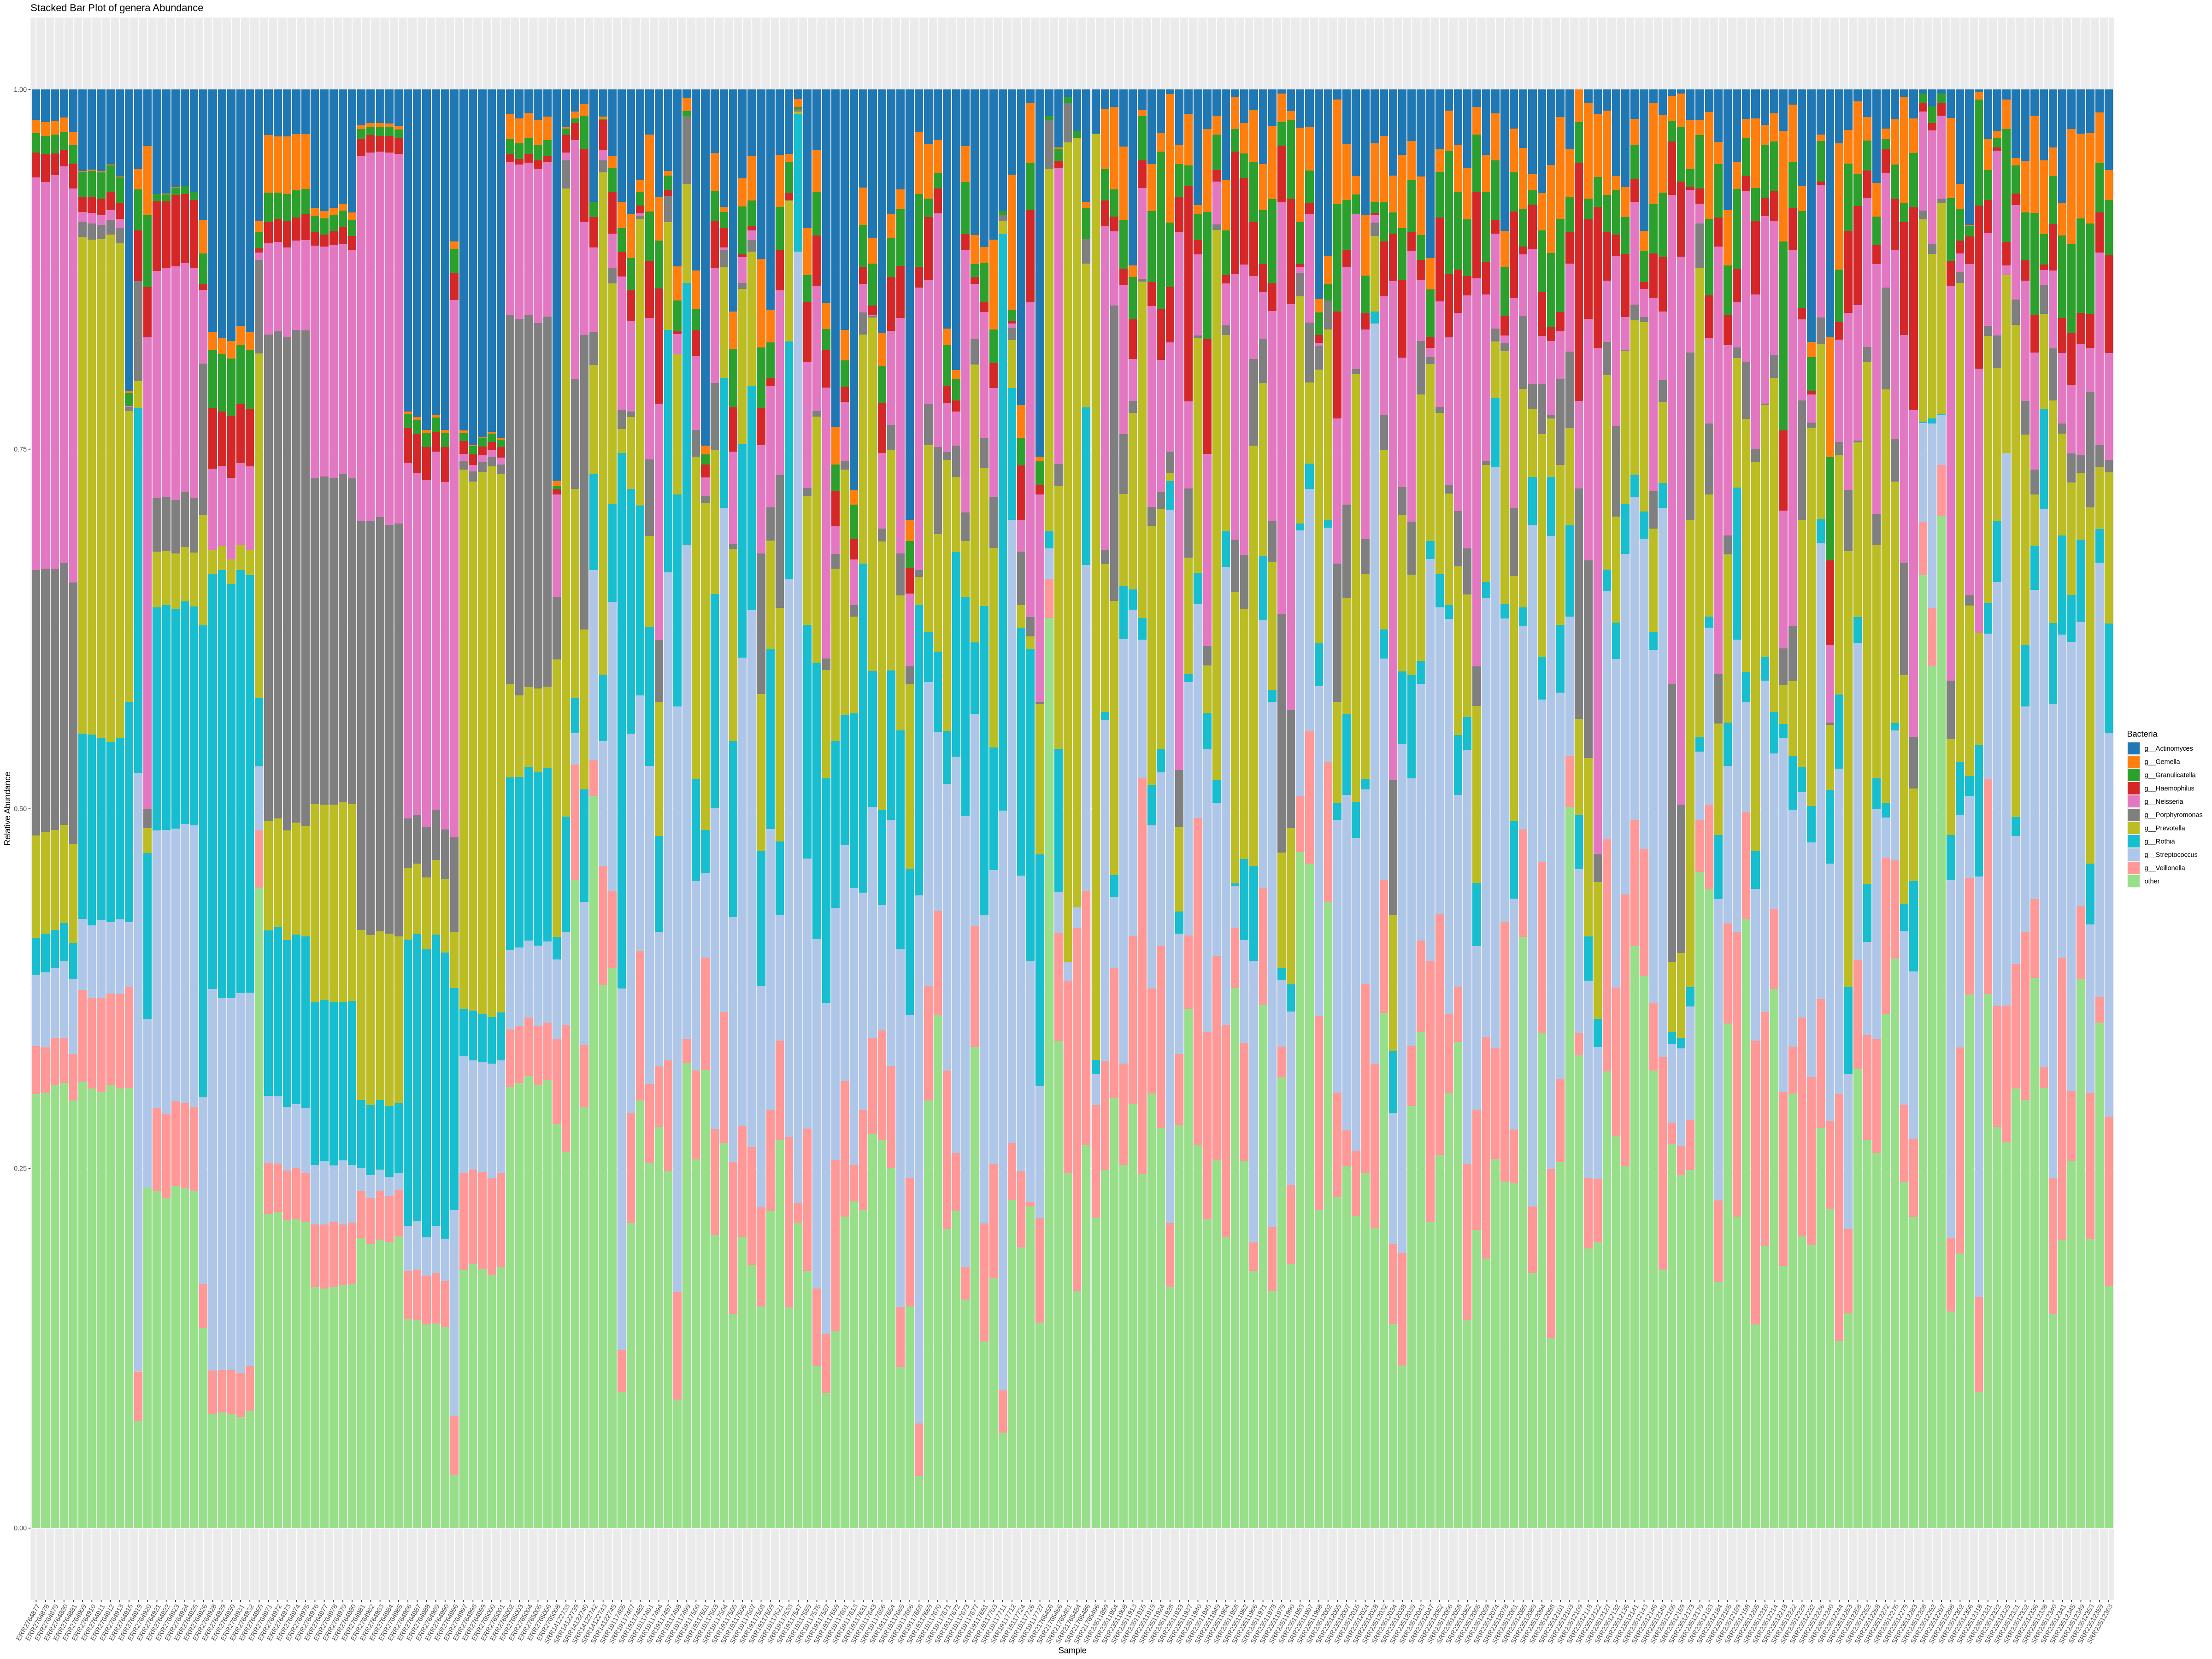

In [125]:
options(repr.plot.width=40 , repr.plot.height= 30)
ggplot(df_long, aes(x = Samples, y = Abundance, fill = Bacteria)) +
  geom_bar(stat = "identity") +
  labs(title = "Stacked Bar Plot of genera Abundance ",
       x = "Sample",
       y = "Relative Abundance") +
scale_fill_manual(values = custom_palette) + 
  theme(axis.text.x = element_text(angle = 60, hjust = 1))

In [126]:
df_long_gr <- df_long %>%
  mutate(group = case_when(
    startsWith(Samples, "ERR276") ~ "PRJEB28422",
    startsWith(Samples, "SRR2176") ~ "PRJNA883997",
    startsWith(Samples, "ERR1474") ~ "PRJEB14383",
    startsWith(Samples, "SRR14122") ~ "PRJNA717815",
    startsWith(Samples, "SRR19117") ~ "PRJNA832909",
      startsWith(Samples, "SRR2351") ~ "PRJNA934596",
    TRUE ~ "PRJNA48479"
  ))

# Group the dataframe based on the 'group' column
df_flip_gr <- df_long_gr %>% group_by(group)
df_flip_gr <- df_flip_gr %>% relocate(group, .after = Samples)
head(df_flip_gr,10)
dim(df_flip_gr)

Samples     group       Bacteria          Abundance
1  SRR21765456 PRJNA883997 g__Streptococcus  0.0214970
2  SRR21765456 PRJNA883997 g__Prevotella     0.2521662
3  SRR21765456 PRJNA883997 g__Neisseria      0.0000000
4  SRR21765456 PRJNA883997 g__Rothia         0.0118064
5  SRR21765456 PRJNA883997 g__Veillonella    0.0269079
6  SRR21765456 PRJNA883997 g__Actinomyces    0.0185155
7  SRR21765456 PRJNA883997 g__Porphyromonas  0.0335461
8  SRR21765456 PRJNA883997 g__Granulicatella 0.0029598
9  SRR21765456 PRJNA883997 g__Haemophilus    0.0000000
10 SRR21765456 PRJNA883997 g__Gemella        0.0000000

[1] 2464    4

In [127]:
df_flip_gr$Abundance <- as.numeric(df_flip_gr$Abundance)

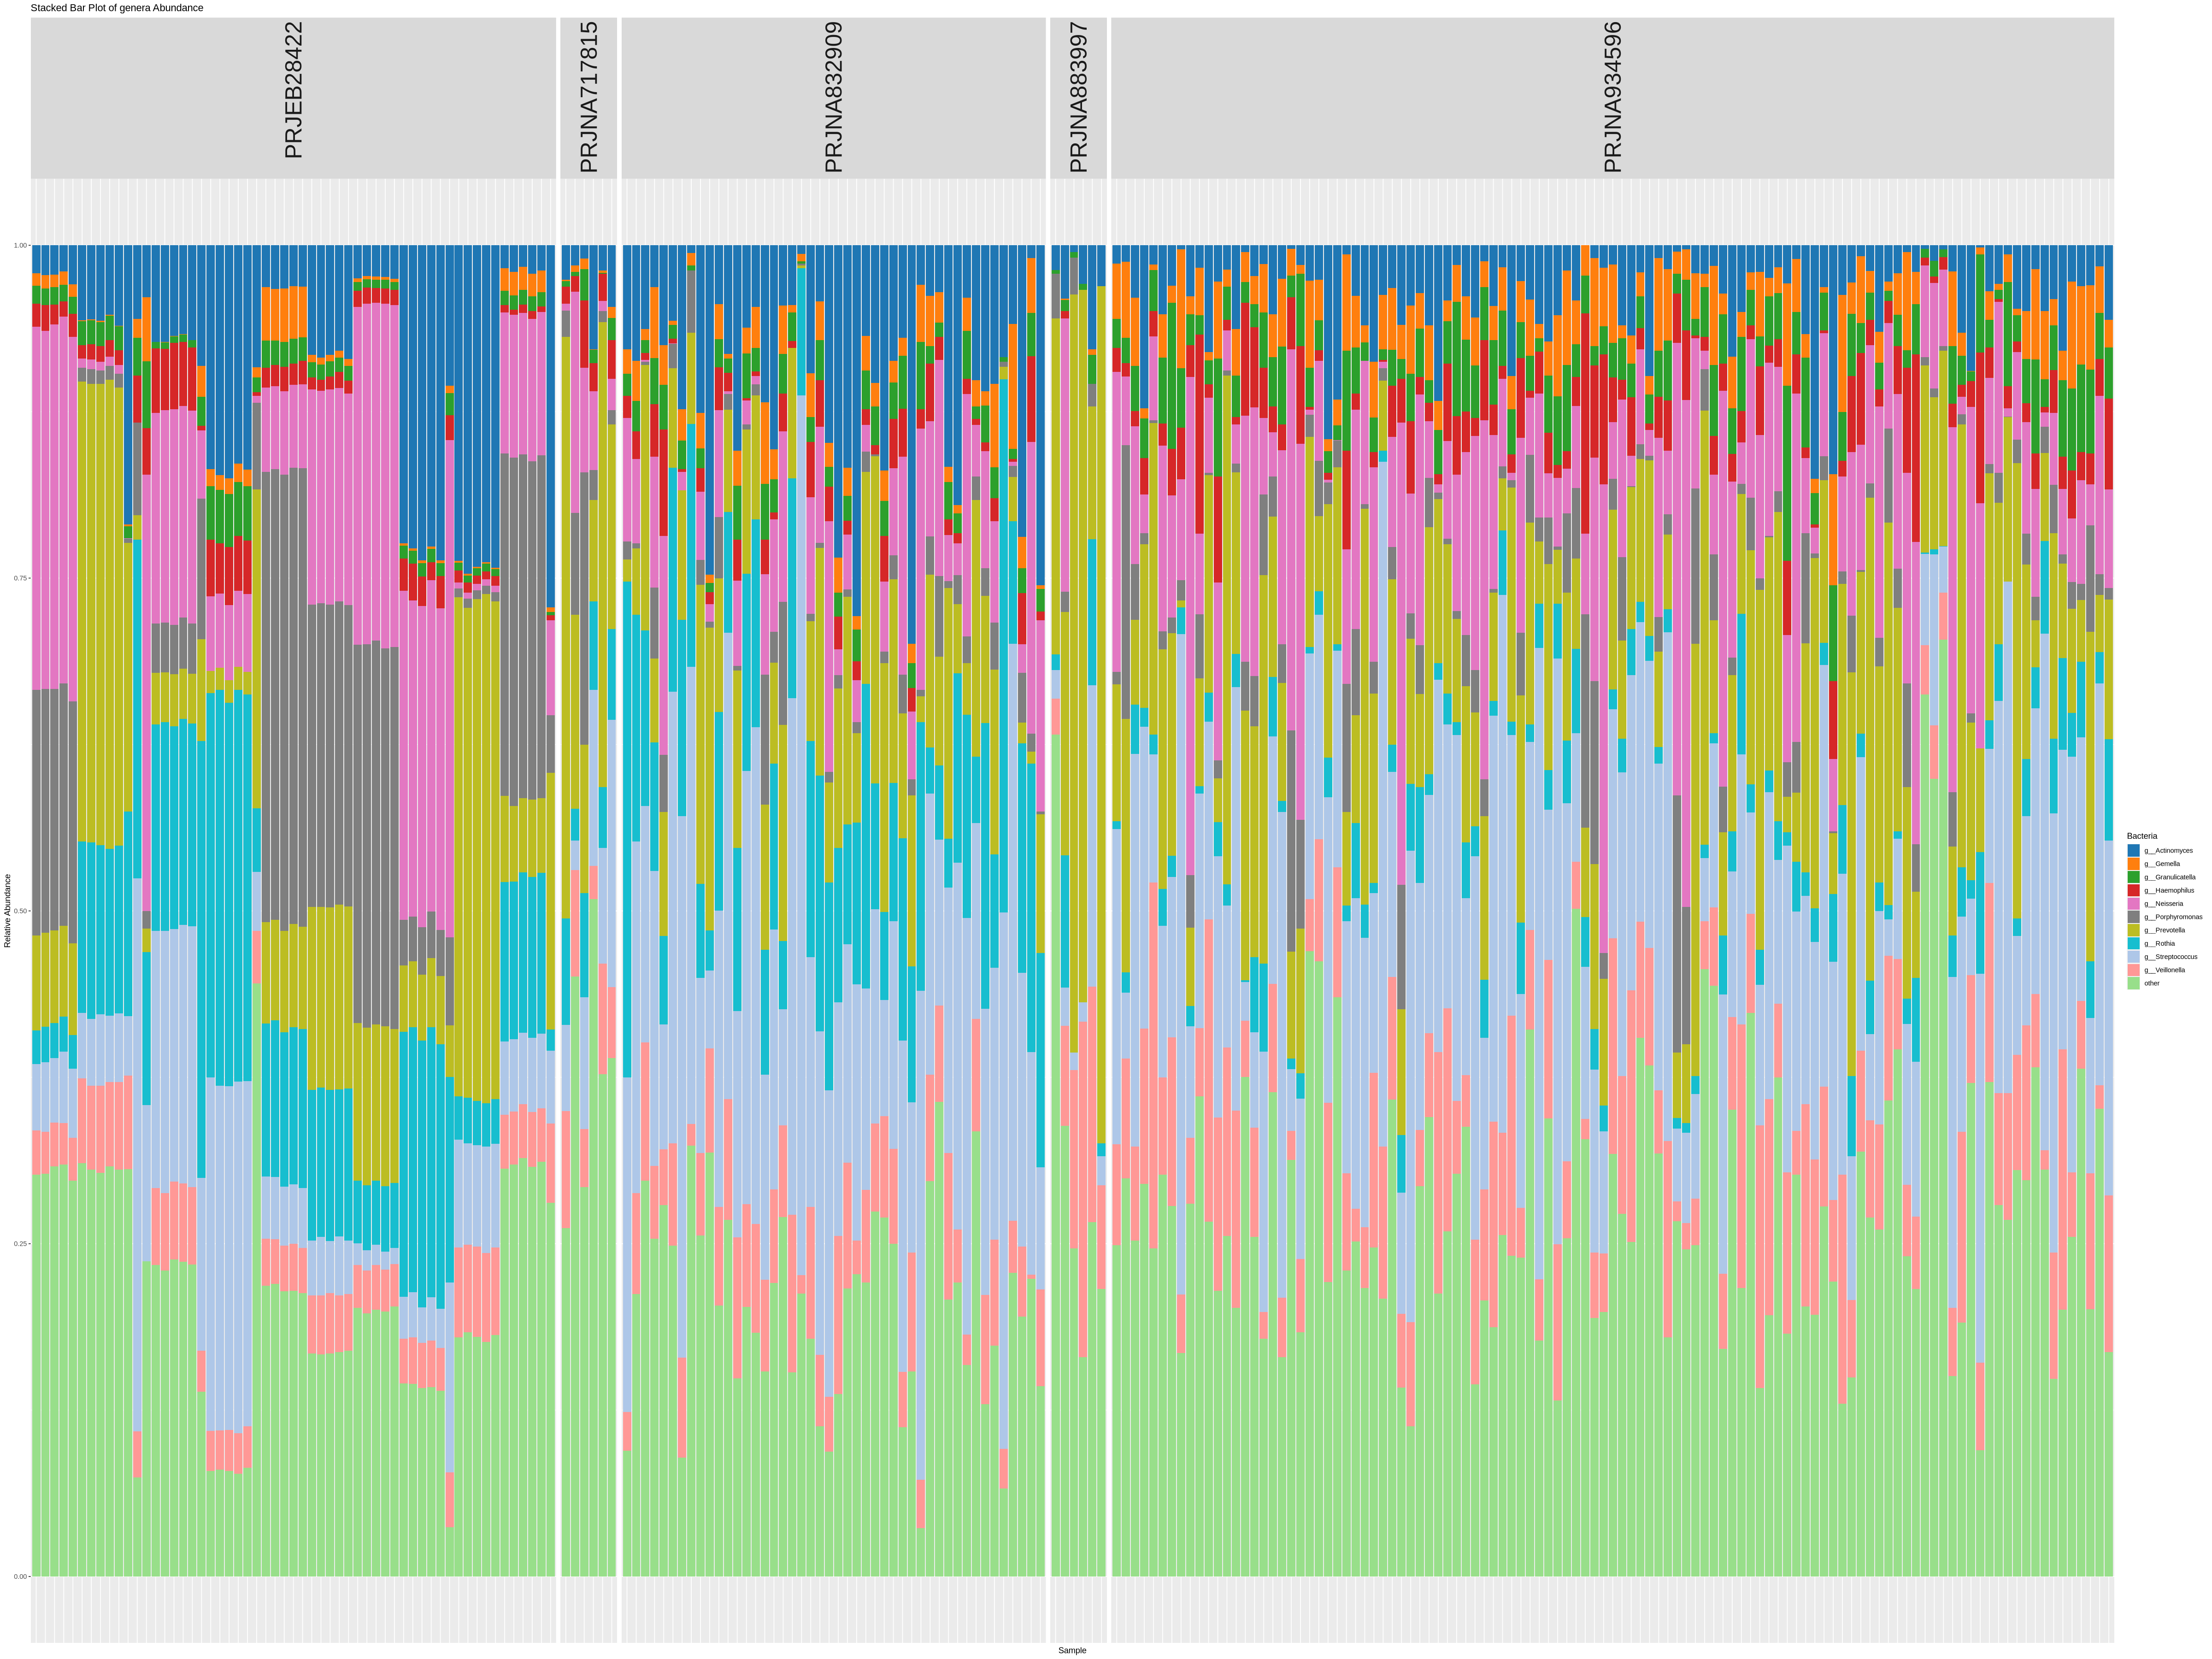

In [145]:
ggplot(df_flip_gr, aes(x = interaction(Samples, group), y = Abundance, fill = Bacteria)) +
  geom_bar(stat = "identity", position = "stack") +
  labs(title = "Stacked Bar Plot of genera Abundance ",
       x = "Sample",
       y = "Relative Abundance") +
  scale_fill_manual(values = custom_palette) + 
  theme(axis.text.x = element_blank(), # Hide the x-axis text
        axis.ticks.x = element_blank(), # Hide the x-axis ticks
        strip.text.x = element_text(angle = 90, hjust = 1, size = 30)) + # Rotate and align facet labels with larger size
  facet_grid(~ group, scales = "free_x", space = "free_x")

In [146]:
setwd("/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/enterosignature-paper/output_reapply_healthy_SS_non/")

In [36]:
getwd()

[1] "/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/enterosignature-paper/NMF_outputs_all/all_controls"

In [147]:
pdf("genera_top10_224unhealthy-all_sep.pdf", width = 60 , height = 30)
 ggplot(df_flip_gr, aes(x = interaction(Samples, group), y = Abundance, fill = Bacteria)) +
  geom_bar(stat = "identity", position = "stack") +
  labs(title = "Stacked Bar Plot of genera Abundance ",
       x = "Sample",
       y = "Relative Abundance") +
  scale_fill_manual(values = custom_palette) + 
  theme(axis.text.x = element_blank(), # Hide the x-axis text
        axis.ticks.x = element_blank(), # Hide the x-axis ticks
        strip.text.x = element_text(angle = 90, hjust = 1, size = 30)) + # Rotate and align facet labels with larger size
  facet_grid(~ group, scales = "free_x", space = "free_x")
dev.off()

png 
  2

## stackbar plot: phylum level _ 350 healthy- unhealthy

In [152]:
setwd("/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/enterosignature-paper/input_tsv/")


In [153]:
controls<- read.table(file = 'all_noncontrols_taxa.tsv', sep = '\t', header = TRUE)
dim(controls)
head(controls)


[1] 279 224

SRR21765456
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949           0.0000000  
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter 0.0000000  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum            0.0000000  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces              0.0185155  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Fannyhessea              0.0000000  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__GGB9835                  0.0000000  
                                                                                                                  SRR21765466
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949           0.00000000 
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter 0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum            0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces              0.04010099 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Fannyhessea              0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__GGB9835                  0.00000000 
                                                                                                                  SRR21765481
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949           0.0000000  
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter 0.0000000  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum            0.0000000  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces              0.0049532  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Fannyhessea              0.0000000  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__GGB9835                  0.0000000  
                                                                                                                  SRR21765484
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949           0.00000000 
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter 0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum            0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces              0.02911629 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Fannyhessea              0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__GGB9835                  0.00000000 
                                                                                                                  SRR21765486
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949           0.00000000 
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter 0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum            0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetac

In [154]:
# retrieve the nth element of each item in a list
n_elem_list <- function(lst, n){
         sapply(lst, `[`, n)
   }

In [155]:
phyla_mx = n_elem_list(str_split(rownames(controls), ";"),2)
head(phyla_mx)

[1] "p__Euryarchaeota"  "p__Euryarchaeota"  "p__Actinobacteria"
[4] "p__Actinobacteria" "p__Actinobacteria" "p__Actinobacteria"

In [156]:
controls$"phyla" <- as.factor(phyla_mx)
head(phyla_mx)
head(controls)


[1] "p__Euryarchaeota"  "p__Euryarchaeota"  "p__Actinobacteria"
[4] "p__Actinobacteria" "p__Actinobacteria" "p__Actinobacteria"

SRR21765456
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949           0.0000000  
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter 0.0000000  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum            0.0000000  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces              0.0185155  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Fannyhessea              0.0000000  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__GGB9835                  0.0000000  
                                                                                                                  SRR21765466
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949           0.00000000 
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter 0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum            0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces              0.04010099 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Fannyhessea              0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__GGB9835                  0.00000000 
                                                                                                                  SRR21765481
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949           0.0000000  
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter 0.0000000  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum            0.0000000  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces              0.0049532  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Fannyhessea              0.0000000  
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__GGB9835                  0.0000000  
                                                                                                                  SRR21765484
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949           0.00000000 
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter 0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum            0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces              0.02911629 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Fannyhessea              0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__GGB9835                  0.00000000 
                                                                                                                  SRR21765486
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949           0.00000000 
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter 0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum            0.00000000 
k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetac

In [157]:
controls<- tibble::rownames_to_column(controls, "clade_names")
head(controls)

clade_names                                                                                                      
1 k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949          
2 k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter
3 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum           
4 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces             
5 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Fannyhessea             
6 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__GGB9835                 
  SRR21765456 SRR21765466 SRR21765481 SRR21765484 SRR21765486 SRR21765496
1 0.0000000   0.00000000  0.0000000   0.00000000  0.00000000  0.00000000 
2 0.0000000   0.00000000  0.0000000   0.00000000  0.00000000  0.00000000 
3 0.0000000   0.00000000  0.0000000   0.00000000  0.00000000  0.00000000 
4 0.0185155   0.04010099  0.0049532   0.02911629  0.07818301  0.03057681 
5 0.0000000   0.00000000  0.0000000   0.00000000  0.00000000  0.00000000 
6 0.0000000   0.00000000  0.0000000   0.00000000  0.00000000  0.00000000 
  ERR2764879   ERR2764880   ERR2764881   ⋯ SRR23512047 SRR23512043 SRR23512039
1 0.0000000000 0.0000000000 0.0000000000 ⋯ 0.0000000   0.000000000 0.0000000  
2 0.0000000000 0.0000000000 0.0000000000 ⋯ 0.0000000   0.000000000 0.0000000  
3 0.0006124001 0.0005421003 0.0004201996 ⋯ 0.0003311   0.001940801 0.0013582  
4 0.0220375022 0.0195570098 0.0292813736 ⋯ 0.1170684   0.060282618 0.0358629  
5 0.0000000000 0.0000000000 0.0000000000 ⋯ 0.0000000   0.000000000 0.0000000  
6 0.0000000000 0.0000000000 0.0000000000 ⋯ 0.0018294   0.000000000 0.0000000  
  SRR23512034 SRR23512222 SRR23512218  SRR23512214 SRR23512210 SRR23512205
1 0.00000000  0.000000    0.000000e+00 0.00000000  0.00000000  0.000000   
2 0.00000000  0.000000    0.000000e+00 0.00000000  0.00000000  0.000000   
3 0.00000000  0.000000    4.789999e-05 0.00000000  0.00000000  0.000000   
4 0.05975929  0.010397    2.861249e-02 0.01655159  0.02454589  0.020061   
5 0.00000000  0.000000    0.000000e+00 0.00000000  0.00000000  0.000000   
6 0.00000000  0.000000    0.000000e+00 0.00000000  0.00000000  0.000000   
  phyla            
1 p__Euryarchaeota 
2 p__Euryarchaeota 
3 p__Actinobacteria
4 p__Actinobacteria
5 p__Actinobacteria
6 p__Actinobacteria

In [158]:
controls <- controls %>% relocate(phyla, .after = "clade_names")
head(controls)

clade_names                                                                                                      
1 k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__GGB50949          
2 k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter
3 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum           
4 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces             
5 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Fannyhessea             
6 k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__GGB9835                 
  phyla             SRR21765456 SRR21765466 SRR21765481 SRR21765484 SRR21765486
1 p__Euryarchaeota  0.0000000   0.00000000  0.0000000   0.00000000  0.00000000 
2 p__Euryarchaeota  0.0000000   0.00000000  0.0000000   0.00000000  0.00000000 
3 p__Actinobacteria 0.0000000   0.00000000  0.0000000   0.00000000  0.00000000 
4 p__Actinobacteria 0.0185155   0.04010099  0.0049532   0.02911629  0.07818301 
5 p__Actinobacteria 0.0000000   0.00000000  0.0000000   0.00000000  0.00000000 
6 p__Actinobacteria 0.0000000   0.00000000  0.0000000   0.00000000  0.00000000 
  SRR21765496 ERR2764879   ERR2764880   ⋯ SRR23512052 SRR23512047 SRR23512043
1 0.00000000  0.0000000000 0.0000000000 ⋯ 0.0000000   0.0000000   0.000000000
2 0.00000000  0.0000000000 0.0000000000 ⋯ 0.0000000   0.0000000   0.000000000
3 0.00000000  0.0006124001 0.0005421003 ⋯ 0.0002585   0.0003311   0.001940801
4 0.03057681  0.0220375022 0.0195570098 ⋯ 0.0414419   0.1170684   0.060282618
5 0.00000000  0.0000000000 0.0000000000 ⋯ 0.0000000   0.0000000   0.000000000
6 0.00000000  0.0000000000 0.0000000000 ⋯ 0.0000000   0.0018294   0.000000000
  SRR23512039 SRR23512034 SRR23512222 SRR23512218  SRR23512214 SRR23512210
1 0.0000000   0.00000000  0.000000    0.000000e+00 0.00000000  0.00000000 
2 0.0000000   0.00000000  0.000000    0.000000e+00 0.00000000  0.00000000 
3 0.0013582   0.00000000  0.000000    4.789999e-05 0.00000000  0.00000000 
4 0.0358629   0.05975929  0.010397    2.861249e-02 0.01655159  0.02454589 
5 0.0000000   0.00000000  0.000000    0.000000e+00 0.00000000  0.00000000 
6 0.0000000   0.00000000  0.000000    0.000000e+00 0.00000000  0.00000000 
  SRR23512205
1 0.000000   
2 0.000000   
3 0.000000   
4 0.020061   
5 0.000000   
6 0.000000

In [159]:
controls <- controls[,-1]
head(controls)

phyla             SRR21765456 SRR21765466 SRR21765481 SRR21765484 SRR21765486
1 p__Euryarchaeota  0.0000000   0.00000000  0.0000000   0.00000000  0.00000000 
2 p__Euryarchaeota  0.0000000   0.00000000  0.0000000   0.00000000  0.00000000 
3 p__Actinobacteria 0.0000000   0.00000000  0.0000000   0.00000000  0.00000000 
4 p__Actinobacteria 0.0185155   0.04010099  0.0049532   0.02911629  0.07818301 
5 p__Actinobacteria 0.0000000   0.00000000  0.0000000   0.00000000  0.00000000 
6 p__Actinobacteria 0.0000000   0.00000000  0.0000000   0.00000000  0.00000000 
  SRR21765496 ERR2764879   ERR2764880   ERR2764881   ⋯ SRR23512052 SRR23512047
1 0.00000000  0.0000000000 0.0000000000 0.0000000000 ⋯ 0.0000000   0.0000000  
2 0.00000000  0.0000000000 0.0000000000 0.0000000000 ⋯ 0.0000000   0.0000000  
3 0.00000000  0.0006124001 0.0005421003 0.0004201996 ⋯ 0.0002585   0.0003311  
4 0.03057681  0.0220375022 0.0195570098 0.0292813736 ⋯ 0.0414419   0.1170684  
5 0.00000000  0.0000000000 0.0000000000 0.0000000000 ⋯ 0.0000000   0.0000000  
6 0.00000000  0.0000000000 0.0000000000 0.0000000000 ⋯ 0.0000000   0.0018294  
  SRR23512043 SRR23512039 SRR23512034 SRR23512222 SRR23512218  SRR23512214
1 0.000000000 0.0000000   0.00000000  0.000000    0.000000e+00 0.00000000 
2 0.000000000 0.0000000   0.00000000  0.000000    0.000000e+00 0.00000000 
3 0.001940801 0.0013582   0.00000000  0.000000    4.789999e-05 0.00000000 
4 0.060282618 0.0358629   0.05975929  0.010397    2.861249e-02 0.01655159 
5 0.000000000 0.0000000   0.00000000  0.000000    0.000000e+00 0.00000000 
6 0.000000000 0.0000000   0.00000000  0.000000    0.000000e+00 0.00000000 
  SRR23512210 SRR23512205
1 0.00000000  0.000000   
2 0.00000000  0.000000   
3 0.00000000  0.000000   
4 0.02454589  0.020061   
5 0.00000000  0.000000   
6 0.00000000  0.000000

In [160]:
g_combine <- aggregate(. ~ phyla, data = controls, FUN = sum)
head(g_combine)
dim(g_combine)

phyla                            SRR21765456 SRR21765466 SRR21765481
1 p__Actinobacteria                0.1898326   0.3015066   0.0205830  
2 p__Ascomycota                    0.0007473   0.0000000   0.0000000  
3 p__Bacteria_unclassified         0.0000000   0.0000000   0.0000000  
4 p__Bacteroidetes                 0.3755938   0.2854747   0.7292202  
5 p__Basidiomycota                 0.0000000   0.0000000   0.0000000  
6 p__Candidatus_Absconditabacteria 0.0000000   0.0159969   0.0136752  
  SRR21765484 SRR21765486 SRR21765496 ERR2764879 ERR2764880 ERR2764881 ⋯
1 0.04646249  0.2887769   0.1693097   0.06746151 0.06293383 0.07043924 ⋯
2 0.00000000  0.0000000   0.0000000   0.00000000 0.00000000 0.00000000 ⋯
3 0.00000000  0.0000000   0.0000000   0.00000000 0.00000000 0.00000000 ⋯
4 0.54863759  0.1481835   0.6669494   0.40692624 0.40881680 0.39906184 ⋯
5 0.00000000  0.0000000   0.0000000   0.00000000 0.00000000 0.00000000 ⋯
6 0.00000000  0.0000000   0.0000000   0.02219040 0.02131771 0.02370918 ⋯
  SRR23512052  SRR23512047 SRR23512043 SRR23512039 SRR23512034 SRR23512222
1 8.267419e-02 0.1653338   0.08648443  0.1147054   0.1113707   0.0478458  
2 0.000000e+00 0.0000000   0.00000000  0.0000000   0.0000000   0.0000000  
3 0.000000e+00 0.0000000   0.00000000  0.0000000   0.0000000   0.0000000  
4 1.842423e-01 0.1420554   0.33440070  0.1752051   0.2348001   0.1634280  
5 0.000000e+00 0.0000000   0.00000000  0.0000000   0.0000000   0.0000000  
6 8.829999e-05 0.0002857   0.01891721  0.0024133   0.0000000   0.0026358  
  SRR23512218  SRR23512214 SRR23512210 SRR23512205
1 0.0439133912 0.05570247  0.04935988  0.05679089 
2 0.0000000000 0.00000000  0.00000000  0.00000000 
3 0.0000000000 0.00000000  0.00000000  0.00000000 
4 0.1517594696 0.34116033  0.22344181  0.30966234 
5 0.0000000000 0.00000000  0.00000000  0.00000000 
6 0.0004199999 0.00000000  0.00000000  0.00000000

[1]  17 225

In [161]:
row_sums <- rowSums(g_combine[, 2:ncol(g_combine)]) 
genera_mix <- cbind(g_combine[, 1], row_sums, g_combine[, 2:ncol(g_combine) ])
head(genera_mix)
colnames(genera_mix)[1] <- "phyla"
colnames(genera_mix)[2] <- "total_abundance_phyla"
head(genera_mix)


g_combine[, 1]                   row_sums    SRR21765456 SRR21765466
1 p__Actinobacteria                38.13818898 0.1898326   0.3015066  
2 p__Ascomycota                     0.00111970 0.0007473   0.0000000  
3 p__Bacteria_unclassified          0.04947449 0.0000000   0.0000000  
4 p__Bacteroidetes                 55.81640141 0.3755938   0.2854747  
5 p__Basidiomycota                  0.00000000 0.0000000   0.0000000  
6 p__Candidatus_Absconditabacteria  1.01249868 0.0000000   0.0159969  
  SRR21765481 SRR21765484 SRR21765486 SRR21765496 ERR2764879 ERR2764880 ⋯
1 0.0205830   0.04646249  0.2887769   0.1693097   0.06746151 0.06293383 ⋯
2 0.0000000   0.00000000  0.0000000   0.0000000   0.00000000 0.00000000 ⋯
3 0.0000000   0.00000000  0.0000000   0.0000000   0.00000000 0.00000000 ⋯
4 0.7292202   0.54863759  0.1481835   0.6669494   0.40692624 0.40881680 ⋯
5 0.0000000   0.00000000  0.0000000   0.0000000   0.00000000 0.00000000 ⋯
6 0.0136752   0.00000000  0.0000000   0.0000000   0.02219040 0.02131771 ⋯
  SRR23512052  SRR23512047 SRR23512043 SRR23512039 SRR23512034 SRR23512222
1 8.267419e-02 0.1653338   0.08648443  0.1147054   0.1113707   0.0478458  
2 0.000000e+00 0.0000000   0.00000000  0.0000000   0.0000000   0.0000000  
3 0.000000e+00 0.0000000   0.00000000  0.0000000   0.0000000   0.0000000  
4 1.842423e-01 0.1420554   0.33440070  0.1752051   0.2348001   0.1634280  
5 0.000000e+00 0.0000000   0.00000000  0.0000000   0.0000000   0.0000000  
6 8.829999e-05 0.0002857   0.01891721  0.0024133   0.0000000   0.0026358  
  SRR23512218  SRR23512214 SRR23512210 SRR23512205
1 0.0439133912 0.05570247  0.04935988  0.05679089 
2 0.0000000000 0.00000000  0.00000000  0.00000000 
3 0.0000000000 0.00000000  0.00000000  0.00000000 
4 0.1517594696 0.34116033  0.22344181  0.30966234 
5 0.0000000000 0.00000000  0.00000000  0.00000000 
6 0.0004199999 0.00000000  0.00000000  0.00000000

phyla                            total_abundance_phyla SRR21765456
1 p__Actinobacteria                38.13818898           0.1898326  
2 p__Ascomycota                     0.00111970           0.0007473  
3 p__Bacteria_unclassified          0.04947449           0.0000000  
4 p__Bacteroidetes                 55.81640141           0.3755938  
5 p__Basidiomycota                  0.00000000           0.0000000  
6 p__Candidatus_Absconditabacteria  1.01249868           0.0000000  
  SRR21765466 SRR21765481 SRR21765484 SRR21765486 SRR21765496 ERR2764879
1 0.3015066   0.0205830   0.04646249  0.2887769   0.1693097   0.06746151
2 0.0000000   0.0000000   0.00000000  0.0000000   0.0000000   0.00000000
3 0.0000000   0.0000000   0.00000000  0.0000000   0.0000000   0.00000000
4 0.2854747   0.7292202   0.54863759  0.1481835   0.6669494   0.40692624
5 0.0000000   0.0000000   0.00000000  0.0000000   0.0000000   0.00000000
6 0.0159969   0.0136752   0.00000000  0.0000000   0.0000000   0.02219040
  ERR2764880 ⋯ SRR23512052  SRR23512047 SRR23512043 SRR23512039 SRR23512034
1 0.06293383 ⋯ 8.267419e-02 0.1653338   0.08648443  0.1147054   0.1113707  
2 0.00000000 ⋯ 0.000000e+00 0.0000000   0.00000000  0.0000000   0.0000000  
3 0.00000000 ⋯ 0.000000e+00 0.0000000   0.00000000  0.0000000   0.0000000  
4 0.40881680 ⋯ 1.842423e-01 0.1420554   0.33440070  0.1752051   0.2348001  
5 0.00000000 ⋯ 0.000000e+00 0.0000000   0.00000000  0.0000000   0.0000000  
6 0.02131771 ⋯ 8.829999e-05 0.0002857   0.01891721  0.0024133   0.0000000  
  SRR23512222 SRR23512218  SRR23512214 SRR23512210 SRR23512205
1 0.0478458   0.0439133912 0.05570247  0.04935988  0.05679089 
2 0.0000000   0.0000000000 0.00000000  0.00000000  0.00000000 
3 0.0000000   0.0000000000 0.00000000  0.00000000  0.00000000 
4 0.1634280   0.1517594696 0.34116033  0.22344181  0.30966234 
5 0.0000000   0.0000000000 0.00000000  0.00000000  0.00000000 
6 0.0026358   0.0004199999 0.00000000  0.00000000  0.00000000

In [162]:
#sorting from highest total abundance to the lowest
sorted_g <- genera_mix[order(-genera_mix$total_abundance_phyla), ]
head(sorted_g, n = 10)

phyla                            total_abundance_phyla SRR21765456
12 p__Firmicutes                    80.7289638            0.3682189  
4  p__Bacteroidetes                 55.8164014            0.3755938  
1  p__Actinobacteria                38.1381890            0.1898326  
14 p__Proteobacteria                35.0906997            0.0056050  
13 p__Fusobacteria                   6.8336273            0.0007549  
8  p__Candidatus_Saccharibacteria    4.3436981            0.0316018  
6  p__Candidatus_Absconditabacteria  1.0124987            0.0000000  
15 p__Spirochaetes                   0.9713186            0.0135196  
17 p__Tenericutes                    0.6823526            0.0000000  
7  p__Candidatus_Gracilibacteria     0.2182187            0.0000000  
   SRR21765466  SRR21765481  SRR21765484 SRR21765486 SRR21765496  ERR2764879 
12 0.1468006560 0.2327387233 0.37902162  0.5565184   0.1570718314 0.144807914
4  0.2854747144 0.7292201729 0.54863759  0.1481835   0.6669494334 0.406926241
1  0.3015066095 0.0205830021 0.04646249  0.2887769   0.1693097339 0.067461507
14 0.2286540314 0.0001624000 0.00221260  0.0023625   0.0061426012 0.330374533
13 0.0006353998 0.0028376003 0.02175910  0.0000000   0.0003321001 0.008275101
8  0.0186581944 0.0007829001 0.00190660  0.0041587   0.0001943000 0.009095901
6  0.0159968952 0.0136752014 0.00000000  0.0000000   0.0000000000 0.022190402
15 0.0020459994 0.0000000000 0.00000000  0.0000000   0.0000000000 0.007569401
17 0.0000000000 0.0000000000 0.00000000  0.0000000   0.0000000000 0.000000000
7  0.0002274999 0.0000000000 0.00000000  0.0000000   0.0000000000 0.000000000
   ERR2764880  ⋯ SRR23512052  SRR23512047 SRR23512043 SRR23512039 SRR23512034
12 0.149739875 ⋯ 4.809270e-01 0.6132996   0.351225305 0.355609836 0.2097261  
4  0.408816804 ⋯ 1.842423e-01 0.1420554   0.334400700 0.175205118 0.2348001  
1  0.062933831 ⋯ 8.267419e-02 0.1653338   0.086484426 0.114705411 0.1113707  
14 0.328073364 ⋯ 1.971374e-01 0.0229066   0.108192832 0.304739130 0.4021405  
13 0.006852703 ⋯ 4.116530e-02 0.0447696   0.060472918 0.022799102 0.0374497  
8  0.009905605 ⋯ 1.079060e-02 0.0110875   0.030420509 0.015608002 0.0015426  
6  0.021317711 ⋯ 8.829999e-05 0.0002857   0.018917206 0.002413300 0.0000000  
15 0.009298005 ⋯ 7.750999e-04 0.0002618   0.001606500 0.000408200 0.0026849  
17 0.000000000 ⋯ 4.980000e-04 0.0000000   0.002800301 0.006461401 0.0002855  
7  0.000000000 ⋯ 1.701900e-03 0.0000000   0.005479302 0.002050500 0.0000000  
   SRR23512222 SRR23512218  SRR23512214 SRR23512210 SRR23512205
12 0.32637637  0.6062502787 0.315741942 0.488515505 0.405718419
4  0.16342798  0.1517594696 0.341160329 0.223441811 0.309662338
1  0.04784580  0.0439133912 0.055702472 0.049359880 0.056790889
14 0.33244927  0.1631488674 0.134861133 0.165937134 0.167072767
13 0.04372930  0.0218842956 0.052348774 0.053745579 0.054573489
8  0.05786599  0.0120034976 0.011622194 0.004684698 0.006182099
6  0.00263580  0.0004199999 0.000000000 0.000000000 0.000000000
15 0.01558810  0.0000000000 0.033520483 0.000000000 0.000000000
17 0.01008140  0.0000000000 0.052833074 0.014315394 0.000000000
7  0.00000000  0.0006201999 0.001772699 0.000000000 0.000000000

In [163]:
top <- sorted_g[1:5,]

In [164]:
head(top)

phyla             total_abundance_phyla SRR21765456 SRR21765466  SRR21765481
12 p__Firmicutes     80.728964             0.3682189   0.1468006560 0.2327387  
4  p__Bacteroidetes  55.816401             0.3755938   0.2854747144 0.7292202  
1  p__Actinobacteria 38.138189             0.1898326   0.3015066095 0.0205830  
14 p__Proteobacteria 35.090700             0.0056050   0.2286540314 0.0001624  
13 p__Fusobacteria    6.833627             0.0007549   0.0006353998 0.0028376  
   SRR21765484 SRR21765486 SRR21765496  ERR2764879  ERR2764880  ⋯ SRR23512052
12 0.37902162  0.5565184   0.1570718314 0.144807914 0.149739875 ⋯ 0.48092695 
4  0.54863759  0.1481835   0.6669494334 0.406926241 0.408816804 ⋯ 0.18424228 
1  0.04646249  0.2887769   0.1693097339 0.067461507 0.062933831 ⋯ 0.08267419 
14 0.00221260  0.0023625   0.0061426012 0.330374533 0.328073364 ⋯ 0.19713738 
13 0.02175910  0.0000000   0.0003321001 0.008275101 0.006852703 ⋯ 0.04116530 
   SRR23512047 SRR23512043 SRR23512039 SRR23512034 SRR23512222 SRR23512218
12 0.6132996   0.35122531  0.3556098   0.2097261   0.3263764   0.60625028 
4  0.1420554   0.33440070  0.1752051   0.2348001   0.1634280   0.15175947 
1  0.1653338   0.08648443  0.1147054   0.1113707   0.0478458   0.04391339 
14 0.0229066   0.10819283  0.3047391   0.4021405   0.3324493   0.16314887 
13 0.0447696   0.06047292  0.0227991   0.0374497   0.0437293   0.02188430 
   SRR23512214 SRR23512210 SRR23512205
12 0.31574194  0.48851550  0.40571842 
4  0.34116033  0.22344181  0.30966234 
1  0.05570247  0.04935988  0.05679089 
14 0.13486113  0.16593713  0.16707277 
13 0.05234877  0.05374558  0.05457349

In [165]:
setwd("/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/enterosignature-paper/output_reapply_healthy_SS_non/")

In [166]:
write.csv(top, file = "5highest_phyla_unhealthy.csv" , row.names= FALSE )

In [167]:
other <- sorted_g[-(1:5),]
head(other)

phyla                            total_abundance_phyla SRR21765456
8  p__Candidatus_Saccharibacteria   4.3436981             0.0316018  
6  p__Candidatus_Absconditabacteria 1.0124987             0.0000000  
15 p__Spirochaetes                  0.9713186             0.0135196  
17 p__Tenericutes                   0.6823526             0.0000000  
7  p__Candidatus_Gracilibacteria    0.2182187             0.0000000  
16 p__Synergistetes                 0.1114635             0.0133778  
   SRR21765466  SRR21765481  SRR21765484 SRR21765486 SRR21765496 ERR2764879 
8  0.0186581944 0.0007829001 0.0019066   0.0041587   0.0001943   0.009095901
6  0.0159968952 0.0136752014 0.0000000   0.0000000   0.0000000   0.022190402
15 0.0020459994 0.0000000000 0.0000000   0.0000000   0.0000000   0.007569401
17 0.0000000000 0.0000000000 0.0000000   0.0000000   0.0000000   0.000000000
7  0.0002274999 0.0000000000 0.0000000   0.0000000   0.0000000   0.000000000
16 0.0000000000 0.0000000000 0.0000000   0.0000000   0.0000000   0.003299000
   ERR2764880  ⋯ SRR23512052  SRR23512047 SRR23512043 SRR23512039 SRR23512034
8  0.009905605 ⋯ 1.079060e-02 0.0110875   0.030420509 0.015608002 0.0015426  
6  0.021317711 ⋯ 8.829999e-05 0.0002857   0.018917206 0.002413300 0.0000000  
15 0.009298005 ⋯ 7.750999e-04 0.0002618   0.001606500 0.000408200 0.0026849  
17 0.000000000 ⋯ 4.980000e-04 0.0000000   0.002800301 0.006461401 0.0002855  
7  0.000000000 ⋯ 1.701900e-03 0.0000000   0.005479302 0.002050500 0.0000000  
16 0.003062102 ⋯ 0.000000e+00 0.0000000   0.000000000 0.000000000 0.0000000  
   SRR23512222 SRR23512218  SRR23512214  SRR23512210 SRR23512205
8  0.05786599  0.0120034976 0.0116221942 0.004684698 0.006182099
6  0.00263580  0.0004199999 0.0000000000 0.000000000 0.000000000
15 0.01558810  0.0000000000 0.0335204832 0.000000000 0.000000000
17 0.01008140  0.0000000000 0.0528330736 0.014315394 0.000000000
7  0.00000000  0.0006201999 0.0017726991 0.000000000 0.000000000
16 0.00000000  0.0000000000 0.0004368998 0.000000000 0.000000000

In [168]:
other<- other [,-2]

In [169]:
#calculating the sum for each column:
rownames(other) <- other[, 1]
other <- other[, -1]
head(other)


SRR21765456 SRR21765466  SRR21765481 
p__Candidatus_Saccharibacteria   0.0316018   0.0186581944 0.0007829001
p__Candidatus_Absconditabacteria 0.0000000   0.0159968952 0.0136752014
p__Spirochaetes                  0.0135196   0.0020459994 0.0000000000
p__Tenericutes                   0.0000000   0.0000000000 0.0000000000
p__Candidatus_Gracilibacteria    0.0000000   0.0002274999 0.0000000000
p__Synergistetes                 0.0133778   0.0000000000 0.0000000000
                                 SRR21765484 SRR21765486 SRR21765496
p__Candidatus_Saccharibacteria   0.0019066   0.0041587   0.0001943  
p__Candidatus_Absconditabacteria 0.0000000   0.0000000   0.0000000  
p__Spirochaetes                  0.0000000   0.0000000   0.0000000  
p__Tenericutes                   0.0000000   0.0000000   0.0000000  
p__Candidatus_Gracilibacteria    0.0000000   0.0000000   0.0000000  
p__Synergistetes                 0.0000000   0.0000000   0.0000000  
                                 ERR2764879  ERR2764880  ERR2764881 
p__Candidatus_Saccharibacteria   0.009095901 0.009905605 0.009823391
p__Candidatus_Absconditabacteria 0.022190402 0.021317711 0.023709179
p__Spirochaetes                  0.007569401 0.009298005 0.008400292
p__Tenericutes                   0.000000000 0.000000000 0.000000000
p__Candidatus_Gracilibacteria    0.000000000 0.000000000 0.000000000
p__Synergistetes                 0.003299000 0.003062102 0.003459897
                                 ERR2764878  ⋯ SRR23512052  SRR23512047
p__Candidatus_Saccharibacteria   0.010482497 ⋯ 1.079060e-02 0.0110875  
p__Candidatus_Absconditabacteria 0.021471494 ⋯ 8.829999e-05 0.0002857  
p__Spirochaetes                  0.007487498 ⋯ 7.750999e-04 0.0002618  
p__Tenericutes                   0.000000000 ⋯ 4.980000e-04 0.0000000  
p__Candidatus_Gracilibacteria    0.000000000 ⋯ 1.701900e-03 0.0000000  
p__Synergistetes                 0.003824599 ⋯ 0.000000e+00 0.0000000  
                                 SRR23512043 SRR23512039 SRR23512034
p__Candidatus_Saccharibacteria   0.030420509 0.015608002 0.0015426  
p__Candidatus_Absconditabacteria 0.018917206 0.002413300 0.0000000  
p__Spirochaetes                  0.001606500 0.000408200 0.0026849  
p__Tenericutes                   0.002800301 0.006461401 0.0002855  
p__Candidatus_Gracilibacteria    0.005479302 0.002050500 0.0000000  
p__Synergistetes                 0.000000000 0.000000000 0.0000000  
                                 SRR23512222 SRR23512218  SRR23512214 
p__Candidatus_Saccharibacteria   0.05786599  0.0120034976 0.0116221942
p__Candidatus_Absconditabacteria 0.00263580  0.0004199999 0.0000000000
p__Spirochaetes                  0.01558810  0.0000000000 0.0335204832
p__Tenericutes                   0.01008140  0.0000000000 0.0528330736
p__Candidatus_Gracilibacteria    0.00000000  0.0006201999 0.0017726991
p__Synergistetes                 0.00000000  0.0000000000 0.0004368998
                                 SRR23512210 SRR23512205
p__Candidatus_Saccharibacteria   0.004684698 0.006182099
p__Candidatus_Absconditabacteria 0.000000000 0.000000000
p__Spirochaetes                  0.000000000 0.000000000
p__Tenericutes                   0.014315394 0.000000000
p__Candidatus_Gracilibacteria    0.000000000 0.000000000
p__Synergistetes                 0.000000000 0.000000000

In [170]:
column_sums <- colSums(other) 

y1 <- rbind(other, column_sums)
tail(y1)
dim(y1)

SRR21765456 SRR21765466 SRR21765481 SRR21765484 SRR21765486
p__Ascomycota    0.0007473   0.00000000  0.0000000   0.0000000   0.0000000  
p__Chloroflexi   0.0007483   0.00000000  0.0000000   0.0000000   0.0000000  
p__Cyanobacteria 0.0000000   0.00000000  0.0000000   0.0000000   0.0000000  
p__Euryarchaeota 0.0000000   0.00000000  0.0000000   0.0000000   0.0000000  
p__Basidiomycota 0.0000000   0.00000000  0.0000000   0.0000000   0.0000000  
13               0.0599948   0.03692859  0.0144581   0.0019066   0.0041587  
                 SRR21765496 ERR2764879 ERR2764880 ERR2764881 ERR2764878 ⋯
p__Ascomycota    0.0000000   0.0000000  0.00000000 0.00000000 0.00000000 ⋯
p__Chloroflexi   0.0000000   0.0000000  0.00000000 0.00000000 0.00000000 ⋯
p__Cyanobacteria 0.0000000   0.0000000  0.00000000 0.00000000 0.00000000 ⋯
p__Euryarchaeota 0.0000000   0.0000000  0.00000000 0.00000000 0.00000000 ⋯
p__Basidiomycota 0.0000000   0.0000000  0.00000000 0.00000000 0.00000000 ⋯
13               0.0001943   0.0421547  0.04358342 0.04539276 0.04326609 ⋯
                 SRR23512052 SRR23512047 SRR23512043 SRR23512039 SRR23512034
p__Ascomycota    0.0000000   0.000000    0.00000000  0.0000000   0.000000   
p__Chloroflexi   0.0000000   0.000000    0.00000000  0.0000000   0.000000   
p__Cyanobacteria 0.0000000   0.000000    0.00000000  0.0000000   0.000000   
p__Euryarchaeota 0.0000000   0.000000    0.00000000  0.0000000   0.000000   
p__Basidiomycota 0.0000000   0.000000    0.00000000  0.0000000   0.000000   
13               0.0138539   0.011635    0.05922382  0.0269414   0.004513   
                 SRR23512222 SRR23512218 SRR23512214 SRR23512210 SRR23512205
p__Ascomycota    0.00000000  0.0000000   0.0000000   0.00000000  0.000000000
p__Chloroflexi   0.00000000  0.0000000   0.0000000   0.00000000  0.000000000
p__Cyanobacteria 0.00000000  0.0000000   0.0000000   0.00000000  0.000000000
p__Euryarchaeota 0.00000000  0.0000000   0.0000000   0.00000000  0.000000000
p__Basidiomycota 0.00000000  0.0000000   0.0000000   0.00000000  0.000000000
13               0.08617129  0.0130437   0.1001853   0.01900009  0.006182099

[1]  13 224

In [171]:
row.names(y1)[row.names(y1) == "13"] <- "other"

In [172]:
y1 <- tibble::rownames_to_column(y1, "phyla")
head(y1)
tail(y1)

phyla                            SRR21765456 SRR21765466  SRR21765481 
1 p__Candidatus_Saccharibacteria   0.0316018   0.0186581944 0.0007829001
2 p__Candidatus_Absconditabacteria 0.0000000   0.0159968952 0.0136752014
3 p__Spirochaetes                  0.0135196   0.0020459994 0.0000000000
4 p__Tenericutes                   0.0000000   0.0000000000 0.0000000000
5 p__Candidatus_Gracilibacteria    0.0000000   0.0002274999 0.0000000000
6 p__Synergistetes                 0.0133778   0.0000000000 0.0000000000
  SRR21765484 SRR21765486 SRR21765496 ERR2764879  ERR2764880  ERR2764881  ⋯
1 0.0019066   0.0041587   0.0001943   0.009095901 0.009905605 0.009823391 ⋯
2 0.0000000   0.0000000   0.0000000   0.022190402 0.021317711 0.023709179 ⋯
3 0.0000000   0.0000000   0.0000000   0.007569401 0.009298005 0.008400292 ⋯
4 0.0000000   0.0000000   0.0000000   0.000000000 0.000000000 0.000000000 ⋯
5 0.0000000   0.0000000   0.0000000   0.000000000 0.000000000 0.000000000 ⋯
6 0.0000000   0.0000000   0.0000000   0.003299000 0.003062102 0.003459897 ⋯
  SRR23512052  SRR23512047 SRR23512043 SRR23512039 SRR23512034 SRR23512222
1 1.079060e-02 0.0110875   0.030420509 0.015608002 0.0015426   0.05786599 
2 8.829999e-05 0.0002857   0.018917206 0.002413300 0.0000000   0.00263580 
3 7.750999e-04 0.0002618   0.001606500 0.000408200 0.0026849   0.01558810 
4 4.980000e-04 0.0000000   0.002800301 0.006461401 0.0002855   0.01008140 
5 1.701900e-03 0.0000000   0.005479302 0.002050500 0.0000000   0.00000000 
6 0.000000e+00 0.0000000   0.000000000 0.000000000 0.0000000   0.00000000 
  SRR23512218  SRR23512214  SRR23512210 SRR23512205
1 0.0120034976 0.0116221942 0.004684698 0.006182099
2 0.0004199999 0.0000000000 0.000000000 0.000000000
3 0.0000000000 0.0335204832 0.000000000 0.000000000
4 0.0000000000 0.0528330736 0.014315394 0.000000000
5 0.0006201999 0.0017726991 0.000000000 0.000000000
6 0.0000000000 0.0004368998 0.000000000 0.000000000

phyla            SRR21765456 SRR21765466 SRR21765481 SRR21765484 SRR21765486
8  p__Ascomycota    0.0007473   0.00000000  0.0000000   0.0000000   0.0000000  
9  p__Chloroflexi   0.0007483   0.00000000  0.0000000   0.0000000   0.0000000  
10 p__Cyanobacteria 0.0000000   0.00000000  0.0000000   0.0000000   0.0000000  
11 p__Euryarchaeota 0.0000000   0.00000000  0.0000000   0.0000000   0.0000000  
12 p__Basidiomycota 0.0000000   0.00000000  0.0000000   0.0000000   0.0000000  
13 other            0.0599948   0.03692859  0.0144581   0.0019066   0.0041587  
   SRR21765496 ERR2764879 ERR2764880 ERR2764881 ⋯ SRR23512052 SRR23512047
8  0.0000000   0.0000000  0.00000000 0.00000000 ⋯ 0.0000000   0.000000   
9  0.0000000   0.0000000  0.00000000 0.00000000 ⋯ 0.0000000   0.000000   
10 0.0000000   0.0000000  0.00000000 0.00000000 ⋯ 0.0000000   0.000000   
11 0.0000000   0.0000000  0.00000000 0.00000000 ⋯ 0.0000000   0.000000   
12 0.0000000   0.0000000  0.00000000 0.00000000 ⋯ 0.0000000   0.000000   
13 0.0001943   0.0421547  0.04358342 0.04539276 ⋯ 0.0138539   0.011635   
   SRR23512043 SRR23512039 SRR23512034 SRR23512222 SRR23512218 SRR23512214
8  0.00000000  0.0000000   0.000000    0.00000000  0.0000000   0.0000000  
9  0.00000000  0.0000000   0.000000    0.00000000  0.0000000   0.0000000  
10 0.00000000  0.0000000   0.000000    0.00000000  0.0000000   0.0000000  
11 0.00000000  0.0000000   0.000000    0.00000000  0.0000000   0.0000000  
12 0.00000000  0.0000000   0.000000    0.00000000  0.0000000   0.0000000  
13 0.05922382  0.0269414   0.004513    0.08617129  0.0130437   0.1001853  
   SRR23512210 SRR23512205
8  0.00000000  0.000000000
9  0.00000000  0.000000000
10 0.00000000  0.000000000
11 0.00000000  0.000000000
12 0.00000000  0.000000000
13 0.01900009  0.006182099

In [173]:
top<- top[,-2]
head(top)

phyla             SRR21765456 SRR21765466  SRR21765481 SRR21765484
12 p__Firmicutes     0.3682189   0.1468006560 0.2327387   0.37902162 
4  p__Bacteroidetes  0.3755938   0.2854747144 0.7292202   0.54863759 
1  p__Actinobacteria 0.1898326   0.3015066095 0.0205830   0.04646249 
14 p__Proteobacteria 0.0056050   0.2286540314 0.0001624   0.00221260 
13 p__Fusobacteria   0.0007549   0.0006353998 0.0028376   0.02175910 
   SRR21765486 SRR21765496  ERR2764879  ERR2764880  ERR2764881  ⋯ SRR23512052
12 0.5565184   0.1570718314 0.144807914 0.149739875 0.146727568 ⋯ 0.48092695 
4  0.1481835   0.6669494334 0.406926241 0.408816804 0.399061841 ⋯ 0.18424228 
1  0.2887769   0.1693097339 0.067461507 0.062933831 0.070439237 ⋯ 0.08267419 
14 0.0023625   0.0061426012 0.330374533 0.328073364 0.331317202 ⋯ 0.19713738 
13 0.0000000   0.0003321001 0.008275101 0.006852703 0.007061394 ⋯ 0.04116530 
   SRR23512047 SRR23512043 SRR23512039 SRR23512034 SRR23512222 SRR23512218
12 0.6132996   0.35122531  0.3556098   0.2097261   0.3263764   0.60625028 
4  0.1420554   0.33440070  0.1752051   0.2348001   0.1634280   0.15175947 
1  0.1653338   0.08648443  0.1147054   0.1113707   0.0478458   0.04391339 
14 0.0229066   0.10819283  0.3047391   0.4021405   0.3324493   0.16314887 
13 0.0447696   0.06047292  0.0227991   0.0374497   0.0437293   0.02188430 
   SRR23512214 SRR23512210 SRR23512205
12 0.31574194  0.48851550  0.40571842 
4  0.34116033  0.22344181  0.30966234 
1  0.05570247  0.04935988  0.05679089 
14 0.13486113  0.16593713  0.16707277 
13 0.05234877  0.05374558  0.05457349

In [174]:
row <- y1[13,]
ab <- rbind(top, row)
tail(ab)
dim(ab)

phyla             SRR21765456 SRR21765466  SRR21765481 SRR21765484
12  p__Firmicutes     0.3682189   0.1468006560 0.2327387   0.37902162 
4   p__Bacteroidetes  0.3755938   0.2854747144 0.7292202   0.54863759 
1   p__Actinobacteria 0.1898326   0.3015066095 0.0205830   0.04646249 
14  p__Proteobacteria 0.0056050   0.2286540314 0.0001624   0.00221260 
13  p__Fusobacteria   0.0007549   0.0006353998 0.0028376   0.02175910 
131 other             0.0599948   0.0369285889 0.0144581   0.00190660 
    SRR21765486 SRR21765496  ERR2764879  ERR2764880  ERR2764881  ⋯ SRR23512052
12  0.5565184   0.1570718314 0.144807914 0.149739875 0.146727568 ⋯ 0.48092695 
4   0.1481835   0.6669494334 0.406926241 0.408816804 0.399061841 ⋯ 0.18424228 
1   0.2887769   0.1693097339 0.067461507 0.062933831 0.070439237 ⋯ 0.08267419 
14  0.0023625   0.0061426012 0.330374533 0.328073364 0.331317202 ⋯ 0.19713738 
13  0.0000000   0.0003321001 0.008275101 0.006852703 0.007061394 ⋯ 0.04116530 
131 0.0041587   0.0001943000 0.042154704 0.043583422 0.045392759 ⋯ 0.01385390 
    SRR23512047 SRR23512043 SRR23512039 SRR23512034 SRR23512222 SRR23512218
12  0.6132996   0.35122531  0.3556098   0.2097261   0.32637637  0.60625028 
4   0.1420554   0.33440070  0.1752051   0.2348001   0.16342798  0.15175947 
1   0.1653338   0.08648443  0.1147054   0.1113707   0.04784580  0.04391339 
14  0.0229066   0.10819283  0.3047391   0.4021405   0.33244927  0.16314887 
13  0.0447696   0.06047292  0.0227991   0.0374497   0.04372930  0.02188430 
131 0.0116350   0.05922382  0.0269414   0.0045130   0.08617129  0.01304370 
    SRR23512214 SRR23512210 SRR23512205
12  0.31574194  0.48851550  0.405718419
4   0.34116033  0.22344181  0.309662338
1   0.05570247  0.04935988  0.056790889
14  0.13486113  0.16593713  0.167072767
13  0.05234877  0.05374558  0.054573489
131 0.10018535  0.01900009  0.006182099

[1]   6 225

In [175]:
getwd()

[1] "/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/enterosignature-paper/output_reapply_healthy_SS_non"

In [176]:
write.csv(ab, file = "5phyla_other_224unhealthy.csv" , row.names= FALSE )

In [177]:
ab <- read.csv( file =  "5phyla_other_224unhealthy.csv", header = TRUE, sep = ",", quote = "\"" )
head(ab)

phyla             SRR21765456 SRR21765466  SRR21765481 SRR21765484
1 p__Firmicutes     0.3682189   0.1468006560 0.2327387   0.37902162 
2 p__Bacteroidetes  0.3755938   0.2854747144 0.7292202   0.54863759 
3 p__Actinobacteria 0.1898326   0.3015066095 0.0205830   0.04646249 
4 p__Proteobacteria 0.0056050   0.2286540314 0.0001624   0.00221260 
5 p__Fusobacteria   0.0007549   0.0006353998 0.0028376   0.02175910 
6 other             0.0599948   0.0369285889 0.0144581   0.00190660 
  SRR21765486 SRR21765496  ERR2764879  ERR2764880  ERR2764881  ⋯ SRR23512052
1 0.5565184   0.1570718314 0.144807914 0.149739875 0.146727568 ⋯ 0.48092695 
2 0.1481835   0.6669494334 0.406926241 0.408816804 0.399061841 ⋯ 0.18424228 
3 0.2887769   0.1693097339 0.067461507 0.062933831 0.070439237 ⋯ 0.08267419 
4 0.0023625   0.0061426012 0.330374533 0.328073364 0.331317202 ⋯ 0.19713738 
5 0.0000000   0.0003321001 0.008275101 0.006852703 0.007061394 ⋯ 0.04116530 
6 0.0041587   0.0001943000 0.042154704 0.043583422 0.045392759 ⋯ 0.01385390 
  SRR23512047 SRR23512043 SRR23512039 SRR23512034 SRR23512222 SRR23512218
1 0.6132996   0.35122531  0.3556098   0.2097261   0.32637637  0.60625028 
2 0.1420554   0.33440070  0.1752051   0.2348001   0.16342798  0.15175947 
3 0.1653338   0.08648443  0.1147054   0.1113707   0.04784580  0.04391339 
4 0.0229066   0.10819283  0.3047391   0.4021405   0.33244927  0.16314887 
5 0.0447696   0.06047292  0.0227991   0.0374497   0.04372930  0.02188430 
6 0.0116350   0.05922382  0.0269414   0.0045130   0.08617129  0.01304370 
  SRR23512214 SRR23512210 SRR23512205
1 0.31574194  0.48851550  0.405718419
2 0.34116033  0.22344181  0.309662338
3 0.05570247  0.04935988  0.056790889
4 0.13486113  0.16593713  0.167072767
5 0.05234877  0.05374558  0.054573489
6 0.10018535  0.01900009  0.006182099

In [178]:
# library(data.table) 
df_t <- transpose(ab)
rownames(df_t) <- colnames(ab)
colnames(df_t) <- rownames(ab)
head(df_t)

1                 2                 3                 
phyla       p__Firmicutes     p__Bacteroidetes  p__Actinobacteria 
SRR21765456 0.3682189         0.3755938         0.1898326         
SRR21765466 0.146800655959803 0.285474714357585 0.301506609548017 
SRR21765481 0.232738723273872 0.729220172922018 0.0205830020583002
SRR21765484 0.379021624195675 0.548637590272481 0.0464624907075019
SRR21765486 0.556518355651835 0.148183514818351 0.288776928877693 
            4                    5                    6                  
phyla       p__Proteobacteria    p__Fusobacteria      other              
SRR21765456 0.005605             0.0007549            0.0599948          
SRR21765466 0.22865403140379     0.000635399809380058 0.0369285889214233 
SRR21765481 0.000162400016240002 0.00283760028376003  0.0144581014458101 
SRR21765484 0.00221259955748009  0.0217590956481809   0.00190659961868008
SRR21765486 0.00236250023625002  0                    0.00415870041587004

In [179]:
colnames(df_t) <- df_t[1, ]

# Remove the first row
df_t <- df_t[-1, ]
head(df_t)


p__Firmicutes     p__Bacteroidetes  p__Actinobacteria 
SRR21765456 0.3682189         0.3755938         0.1898326         
SRR21765466 0.146800655959803 0.285474714357585 0.301506609548017 
SRR21765481 0.232738723273872 0.729220172922018 0.0205830020583002
SRR21765484 0.379021624195675 0.548637590272481 0.0464624907075019
SRR21765486 0.556518355651835 0.148183514818351 0.288776928877693 
SRR21765496 0.157071831414366 0.666949433389887 0.169309733861947 
            p__Proteobacteria    p__Fusobacteria      other               
SRR21765456 0.005605             0.0007549            0.0599948           
SRR21765466 0.22865403140379     0.000635399809380058 0.0369285889214233  
SRR21765481 0.000162400016240002 0.00283760028376003  0.0144581014458101  
SRR21765484 0.00221259955748009  0.0217590956481809   0.00190659961868008 
SRR21765486 0.00236250023625002  0                    0.00415870041587004 
SRR21765496 0.00614260122852025  0.000332100066420013 0.000194300038860008

In [180]:
df_flip <- tibble::rownames_to_column(df_t, "Samples")
head(df_flip)

Samples     p__Firmicutes     p__Bacteroidetes  p__Actinobacteria 
1 SRR21765456 0.3682189         0.3755938         0.1898326         
2 SRR21765466 0.146800655959803 0.285474714357585 0.301506609548017 
3 SRR21765481 0.232738723273872 0.729220172922018 0.0205830020583002
4 SRR21765484 0.379021624195675 0.548637590272481 0.0464624907075019
5 SRR21765486 0.556518355651835 0.148183514818351 0.288776928877693 
6 SRR21765496 0.157071831414366 0.666949433389887 0.169309733861947 
  p__Proteobacteria    p__Fusobacteria      other               
1 0.005605             0.0007549            0.0599948           
2 0.22865403140379     0.000635399809380058 0.0369285889214233  
3 0.000162400016240002 0.00283760028376003  0.0144581014458101  
4 0.00221259955748009  0.0217590956481809   0.00190659961868008 
5 0.00236250023625002  0                    0.00415870041587004 
6 0.00614260122852025  0.000332100066420013 0.000194300038860008

In [181]:
df_long <- pivot_longer(df_flip, cols = -Samples, names_to = "Bacteria", values_to = "Abundance")

In [182]:
df_long$Abundance <- as.numeric(df_long$Abundance)
#"#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
custom_palette <- c( "#e377c2", "#7f7f7f","#bcbd22", "#17becf", 
                    "#aec7e8", "#ff9896", "#98df8a", "#ff9e19", "#ffbb78", 
                    "#f7b6d2")

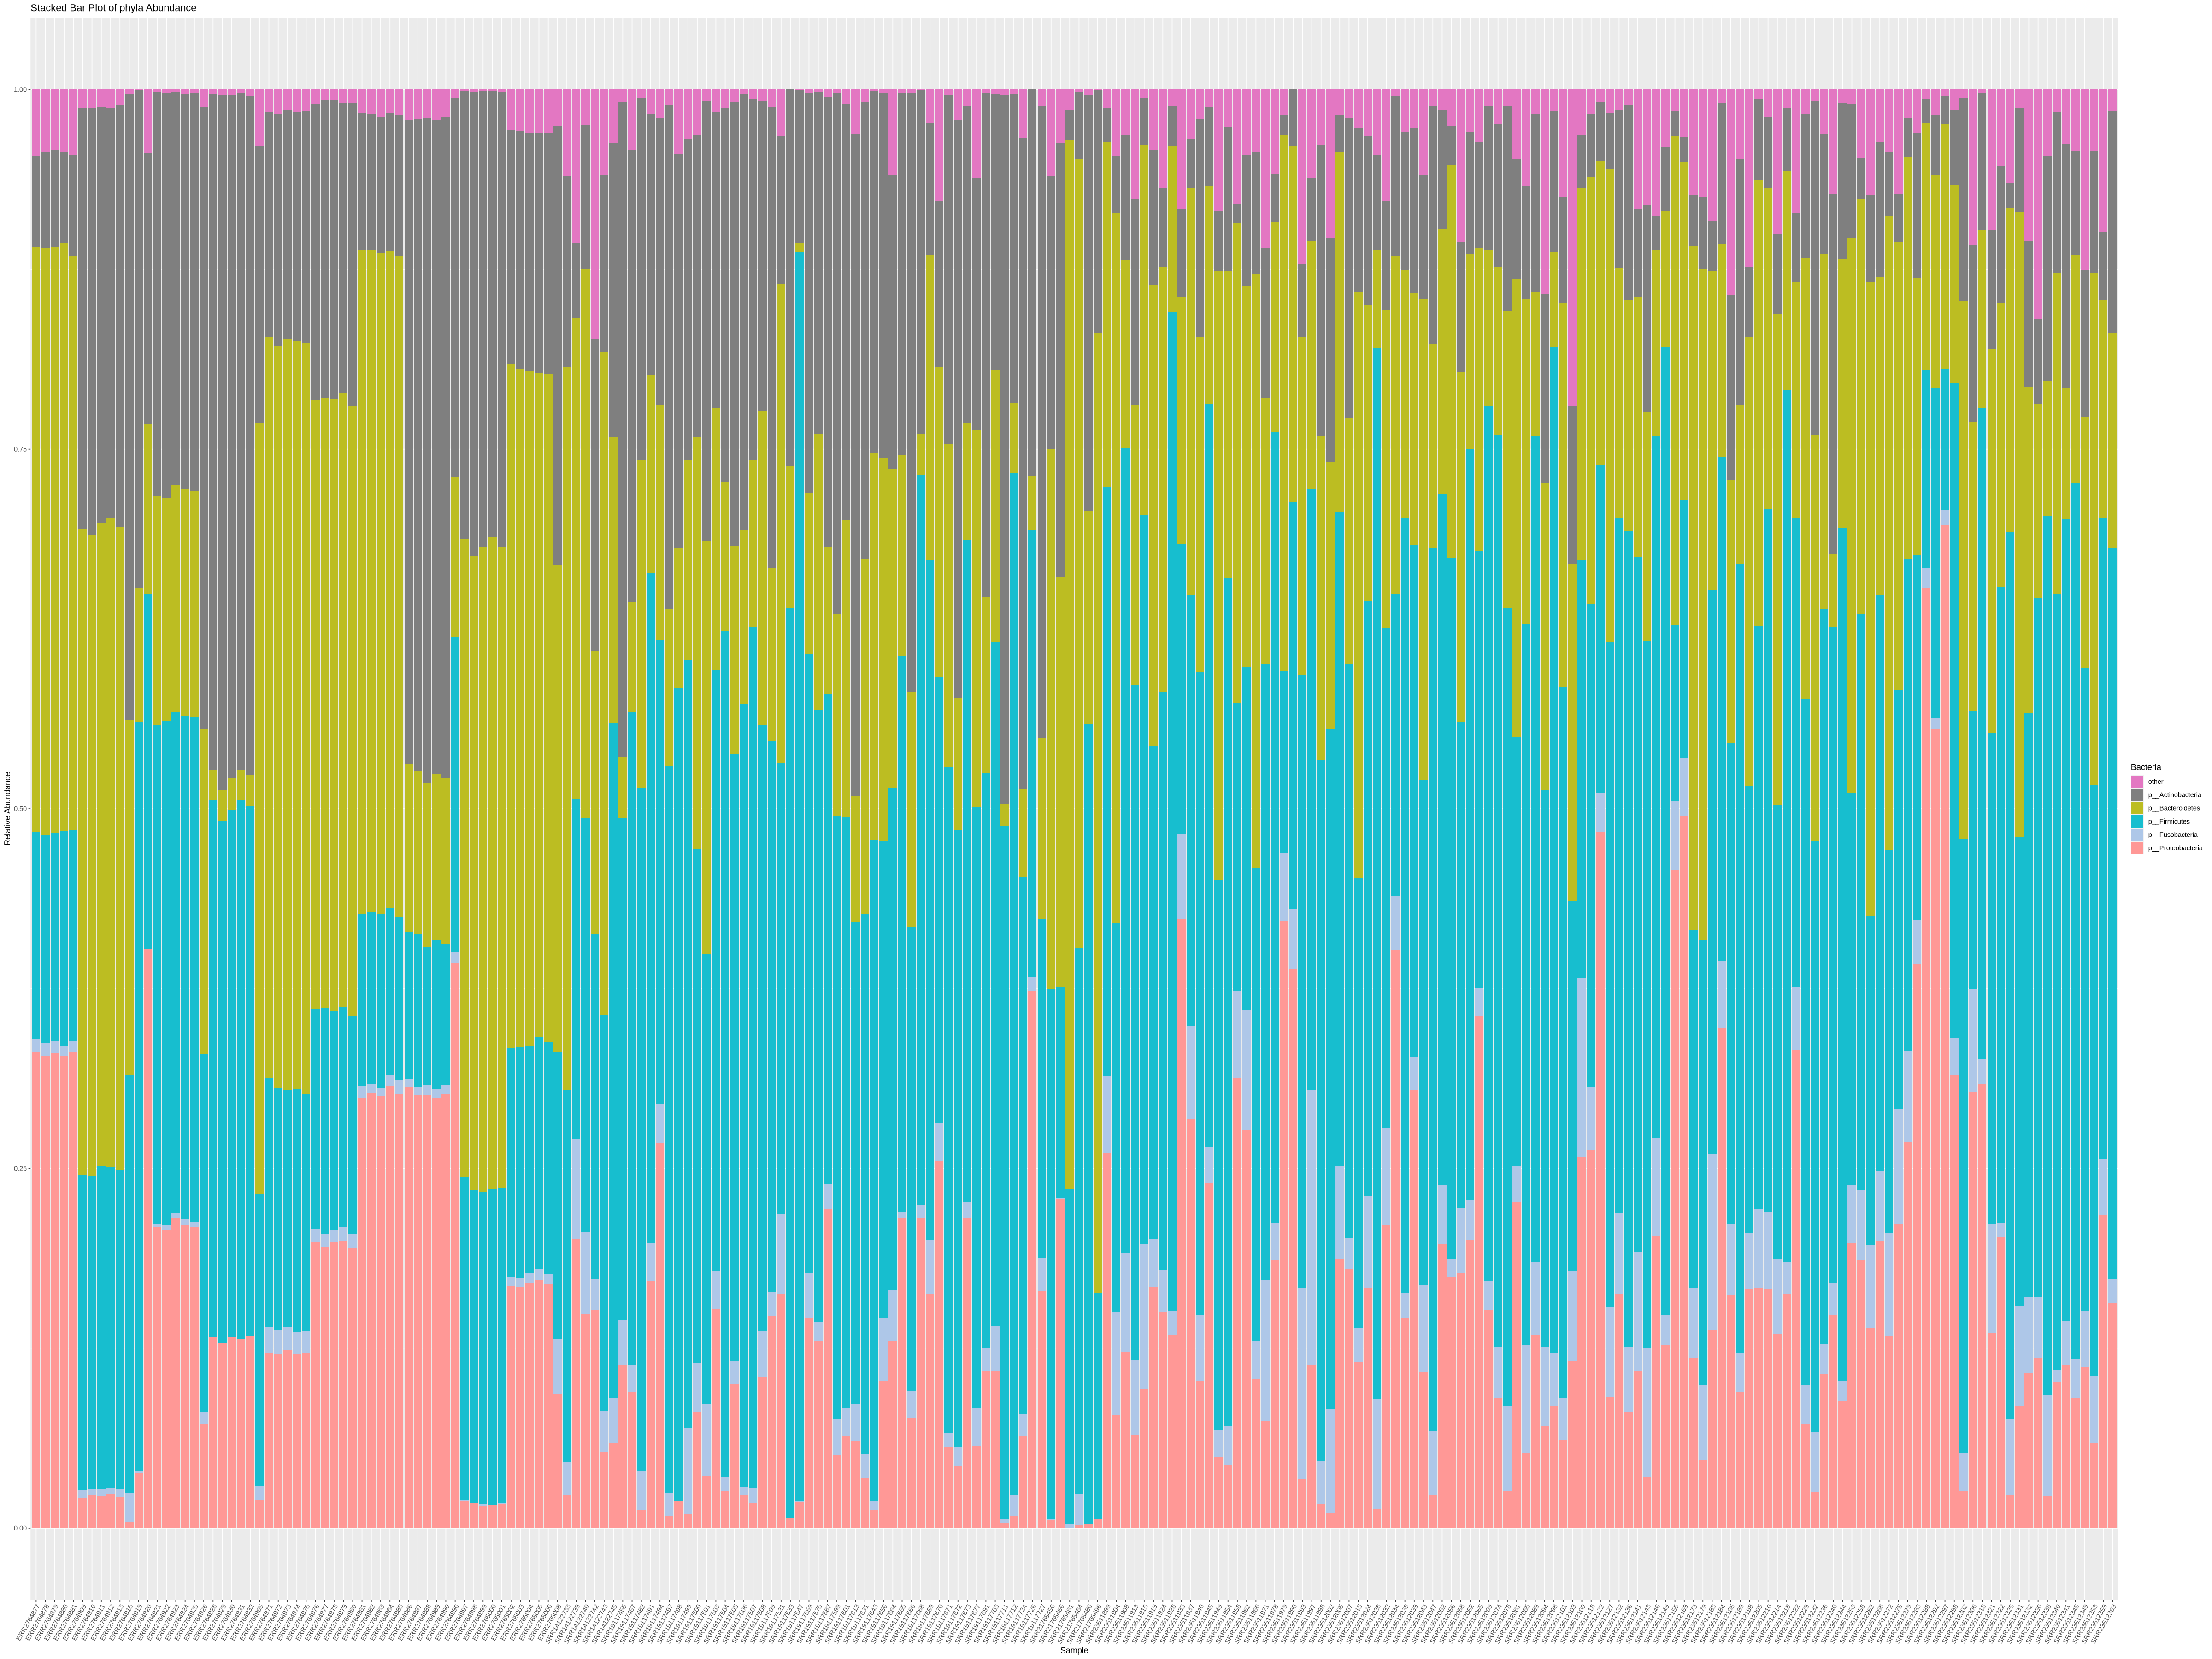

In [184]:
options(repr.plot.width=40 , repr.plot.height= 30)
ggplot(df_long, aes(x = Samples, y = Abundance, fill = Bacteria)) +
  geom_bar(stat = "identity") +
  labs(title = "Stacked Bar Plot of phyla Abundance ",
       x = "Sample",
       y = "Relative Abundance") +
scale_fill_manual(values = custom_palette) + 
  theme(axis.text.x = element_text(angle = 60, hjust = 1))


In [185]:
df_long_gr <- df_long %>%
  mutate(group = case_when(
    startsWith(Samples, "ERR276") ~ "PRJEB28422",
    startsWith(Samples, "SRR2176") ~ "PRJNA883997",
    startsWith(Samples, "ERR1474") ~ "PRJEB14383",
    startsWith(Samples, "SRR14122") ~ "PRJNA717815",
    startsWith(Samples, "SRR19117") ~ "PRJNA832909",
      startsWith(Samples, "SRR2351") ~ "PRJNA934596",
    TRUE ~ "PRJNA48479"
  ))

# Group the dataframe based on the 'group' column
df_flip_gr <- df_long_gr %>% group_by(group)
df_flip_gr <- df_flip_gr %>% relocate(group, .after = Samples)
head(df_flip_gr,10)
dim(df_flip_gr)

Samples     group       Bacteria          Abundance
1  SRR21765456 PRJNA883997 p__Firmicutes     0.3682189
2  SRR21765456 PRJNA883997 p__Bacteroidetes  0.3755938
3  SRR21765456 PRJNA883997 p__Actinobacteria 0.1898326
4  SRR21765456 PRJNA883997 p__Proteobacteria 0.0056050
5  SRR21765456 PRJNA883997 p__Fusobacteria   0.0007549
6  SRR21765456 PRJNA883997 other             0.0599948
7  SRR21765466 PRJNA883997 p__Firmicutes     0.1468007
8  SRR21765466 PRJNA883997 p__Bacteroidetes  0.2854747
9  SRR21765466 PRJNA883997 p__Actinobacteria 0.3015066
10 SRR21765466 PRJNA883997 p__Proteobacteria 0.2286540

[1] 1344    4

In [186]:
df_flip_gr$Abundance <- as.numeric(df_flip_gr$Abundance)


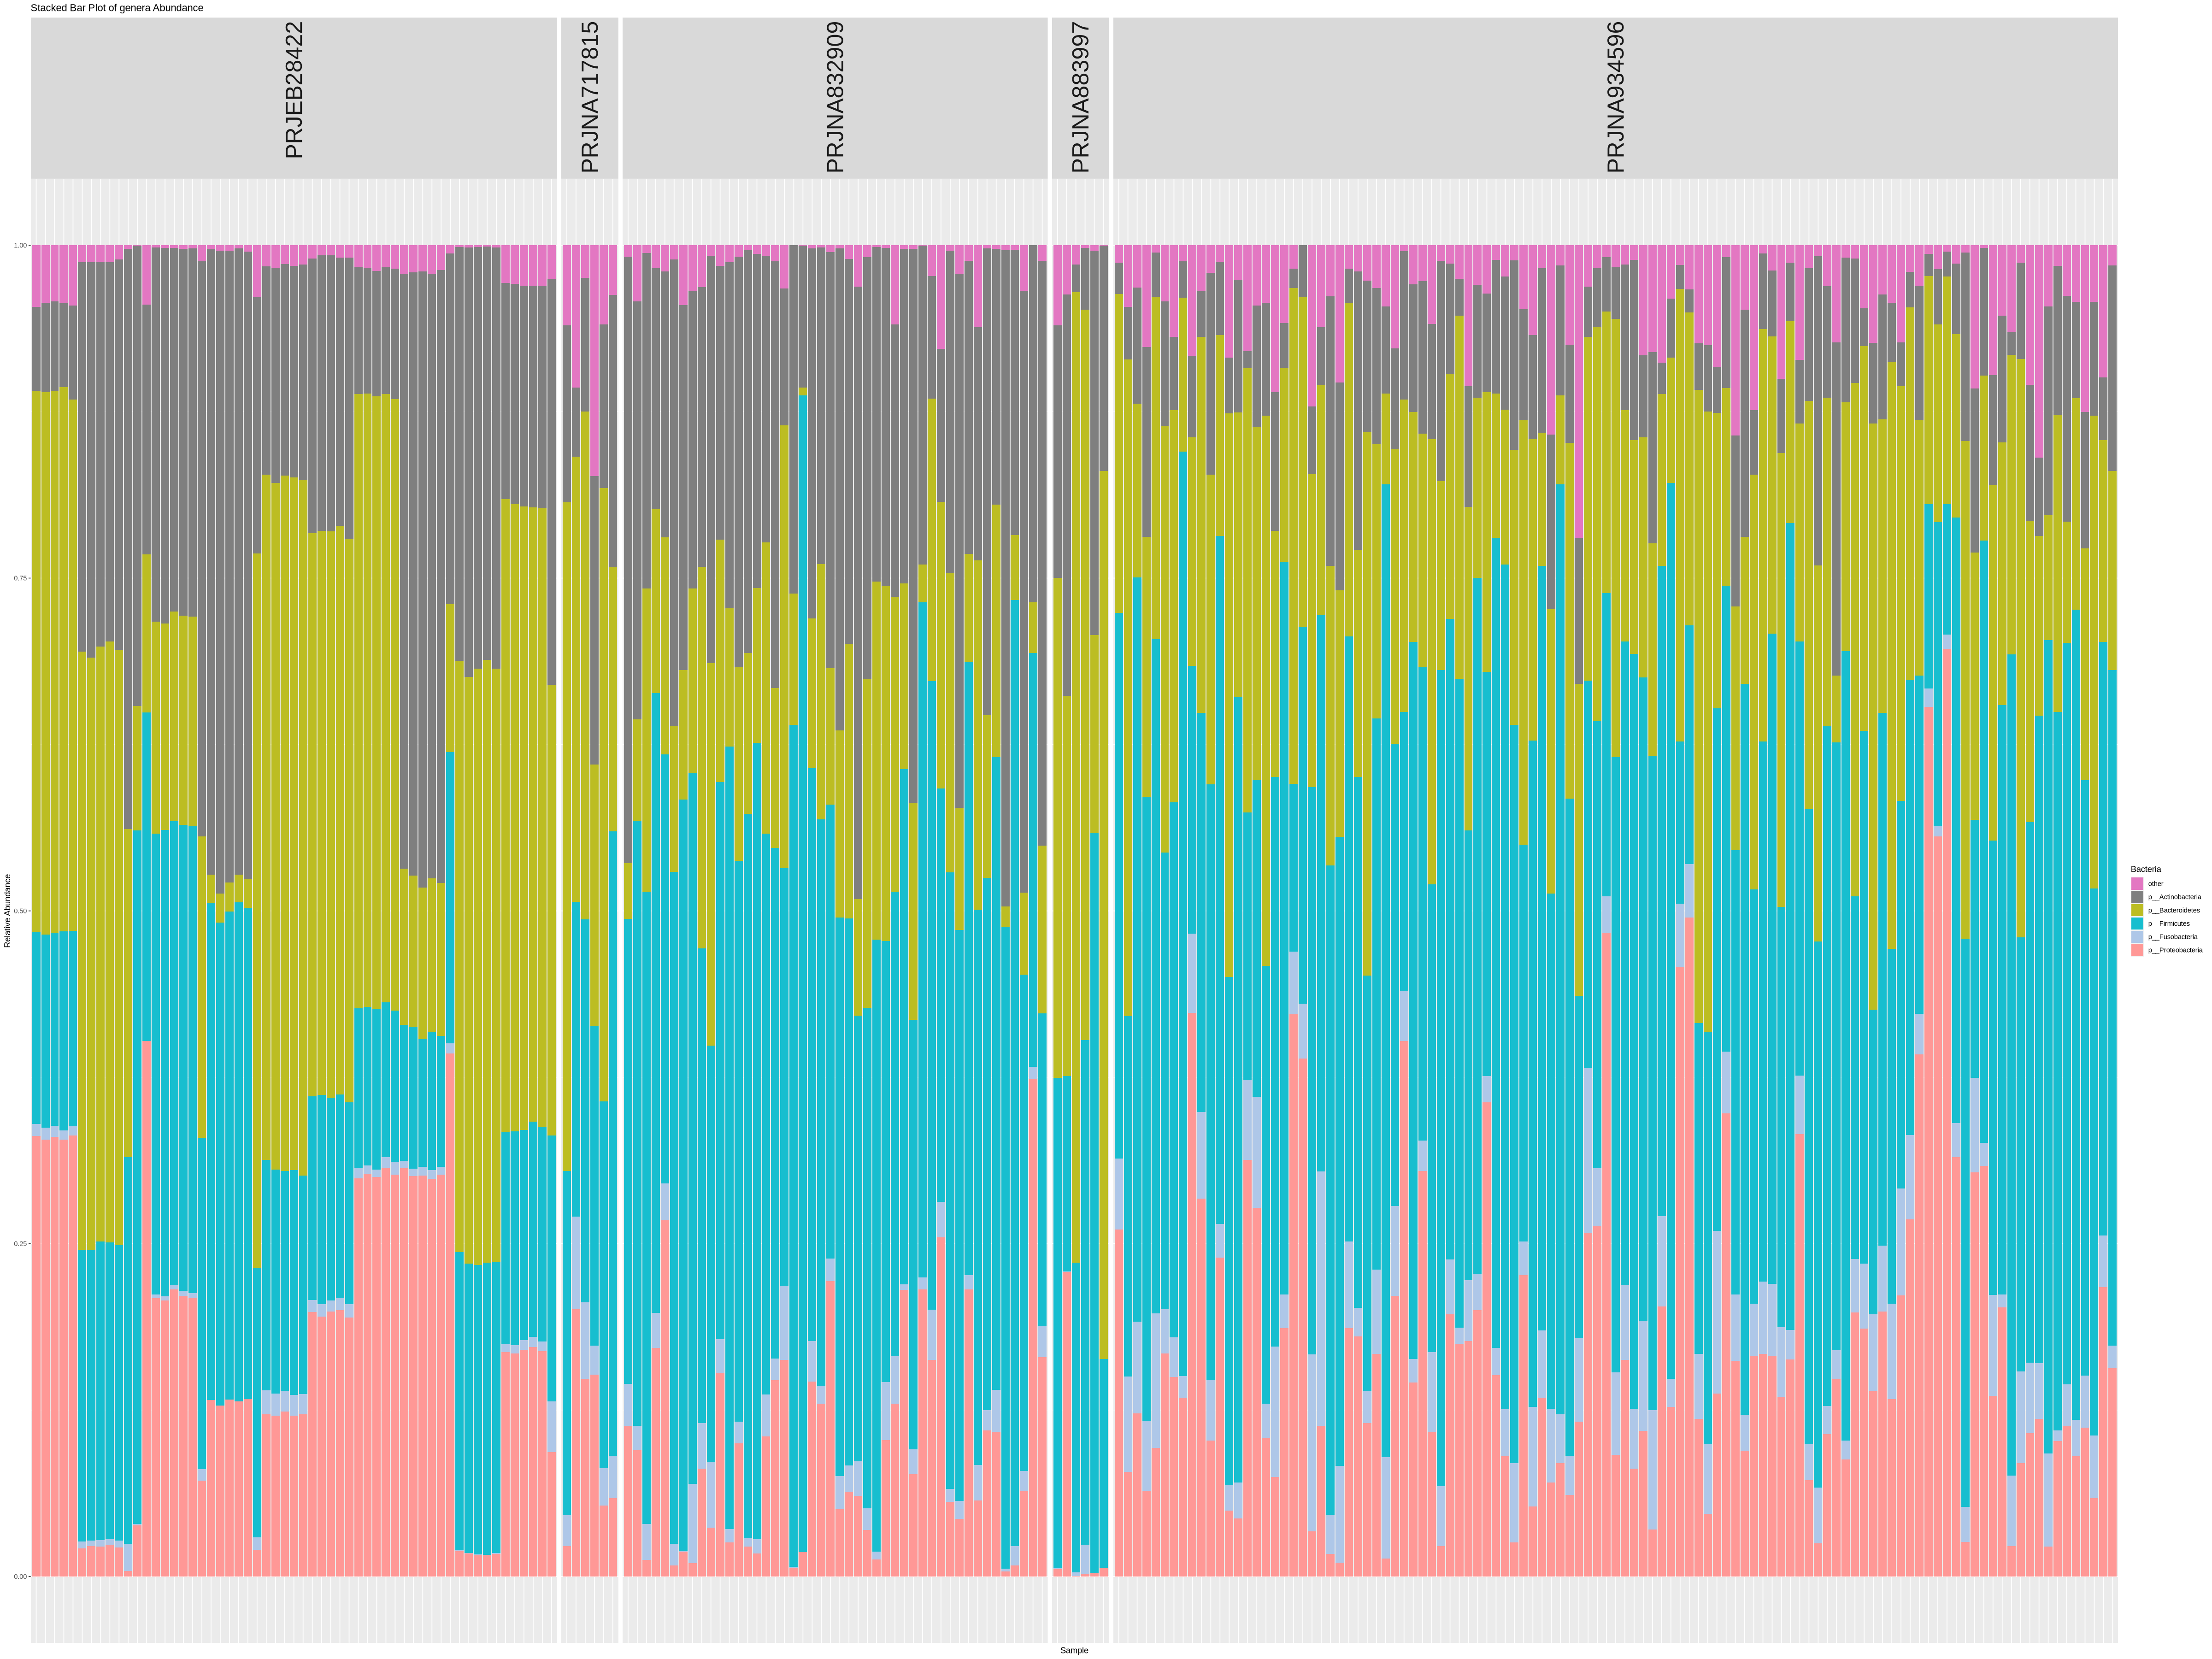

In [188]:
ggplot(df_flip_gr, aes(x = interaction(Samples, group), y = Abundance, fill = Bacteria)) +
  geom_bar(stat = "identity", position = "stack") +
  labs(title = "Stacked Bar Plot of genera Abundance ",
       x = "Sample",
       y = "Relative Abundance") +
  scale_fill_manual(values = custom_palette) + 
  theme(axis.text.x = element_blank(), # Hide the x-axis text
        axis.ticks.x = element_blank(), # Hide the x-axis ticks
        strip.text.x = element_text(angle = 90, hjust = 1, size = 30)) + # Rotate and align facet labels with larger size
  facet_grid(~ group, scales = "free_x", space = "free_x")

In [189]:
getwd()

[1] "/crex/proj/naiss2023-23-521/private/delaramb/r_notebooks/enterosignature-paper/output_reapply_healthy_SS_non"

In [194]:
pdf("phyla_top5_224unhealthy_allsep.pdf", width = 50 , height = 25)
 ggplot(df_flip_gr, aes(x = interaction(Samples, group), y = Abundance, fill = Bacteria)) +
  geom_bar(stat = "identity", position = "stack") +
  labs(title = "Stacked Bar Plot of genera Abundance ",
       x = "Sample",
       y = "Relative Abundance") +
  scale_fill_manual(values = custom_palette) + 
  theme(axis.text.x = element_blank(), # Hide the x-axis text
        axis.ticks.x = element_blank(), # Hide the x-axis ticks
        strip.text.x = element_text(angle = 90, hjust = 1, size = 30)) + # Rotate and align facet labels with larger size
  facet_grid(~ group, scales = "free_x", space = "free_x")
dev.off()

png 
  2